## Model and feature selection

### Imports for modelling

In [1]:
# !pip install imblearn
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.2.2
from imblearn.over_sampling import SMOTENC
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression, SGDClassifier, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
import pickle

# !pip install category_encoders
import category_encoders as ce
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

random_state = 42
np.random.seed(42)

### Set train and test data

In [2]:
df_train = pd.read_csv('Data/df_train_preprocessed.csv')
df_test = pd.read_csv('Data/df_test_preprocessed.csv')

### Important functions

In [3]:
def target_encoder(fit_data, transform_data, target, features_for_encoding, smoothing=100):
    target_encoder = ce.TargetEncoder(cols=features_for_encoding, smoothing=smoothing)  
    target_encoder.fit(fit_data[features_for_encoding], fit_data[target].astype(int))
    encoded_df = target_encoder.transform(transform_data[features_for_encoding])
    features_for_encoding_pass = [i + '_target' for i in features_for_encoding]
    transform_data[features_for_encoding_pass] = np.array(encoded_df)
    encoded_df = transform_data.drop(columns = features_for_encoding)
    return encoded_df, features_for_encoding_pass

In [4]:
def scaler(fit_data, transform_data, features_for_scaling, scaling_type = 'minmax'):
    if scaling_type == 'minmax':
        sc = MinMaxScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1) 
        return scaled_df
    if scaling_type == 'standard':
        sc = StandardScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1)
        return scaled_df

In [5]:
def patient_features(df_train, df_test, multiclass = False):
    df_all = pd.concat([df_train, df_test])

    list_for_scaling = []
    
    # total visits of one patient in dataset, excluding current visit
    patient_total_visits = df_train[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_train = pd.merge(df_train, patient_total_visits, how = 'left', on = 'patient_id')
    df_train['patient_total_visits'].fillna(0, inplace = True)

    patient_total_visits = df_all[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_test = pd.merge(df_test, patient_total_visits, how = 'left', on = 'patient_id')
    df_test['patient_total_visits'].fillna(0, inplace = True)

    list_for_scaling.append('patient_total_visits')

    if multiclass == False:
        # check if we know that this person was readmitted on any other visit we know and calculate number of readmissions
        was_readmitted_encounter = df_train[['patient_id', 
                                   'encounter_id',
                                   'readmitted_binary']].groupby(['patient_id','encounter_id']).max(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_encounter'}).reset_index()
        was_readmitted_patient = df_train[['patient_id', 
                                       'readmitted_binary']].groupby(['patient_id']).sum(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_patient'}).reset_index()
        was_readmitted = pd.merge(was_readmitted_encounter, was_readmitted_patient, on = 'patient_id')
        was_readmitted['patient_num_readmitted'] = (was_readmitted['was_readmitted_patient'] - was_readmitted['was_readmitted_encounter']).astype('int')
        was_readmitted['patient_was_readmitted'] = was_readmitted['patient_num_readmitted'].apply(lambda x: 1 if x > 0 else 0).astype('category')
        df_train = pd.merge(df_train, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id')
        df_train[['patient_num_readmitted', 'patient_was_readmitted']] = df_train[['patient_num_readmitted', 'patient_was_readmitted']].fillna(0)
    
        df_test = pd.merge(df_test, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id')
        df_test[['patient_num_readmitted', 'patient_was_readmitted']] = df_test[['patient_num_readmitted', 'patient_was_readmitted']].fillna(0).astype(int)
        list_for_scaling.append('patient_num_readmitted')

    return df_train, df_test, list_for_scaling

In [6]:
def upsampler(data, 
              target,  
              upsample_type = 'simple', 
              upsample_size = 1):
    majority_class_label = data[target].value_counts().idxmax()
    minority_class_labels = data[target].value_counts().index.drop(majority_class_label)
    balanced_data = pd.DataFrame()
    if upsample_type == 'simple':
        for label in minority_class_labels:
            if len(data[data[target] == majority_class_label])*upsample_size > len(data[data[target] == label]):
                minority_upsampled = resample(data[data[target] == label], replace=True, n_samples=int(len(data[data[target] == majority_class_label])*upsample_size), 
                                                  random_state = random_state)
                balanced_data = pd.concat([balanced_data, minority_upsampled])
            else:
                balanced_data = pd.concat([balanced_data, data[data[target] == label]])
        balanced_data = pd.concat([balanced_data, data[data[target] == majority_class_label]])
    if upsample_type == 'SMOTE':
        X = data.drop(columns = target)
        categorical_features = X.select_dtypes(include='category').columns
        cat_ind = [X.columns.get_loc(col) for col in categorical_features]
        smote_nc = SMOTENC(categorical_features=cat_ind, random_state=random_state)
        X_resampled, y_resampled = smote_nc.fit_resample(X, data[target])  
        balanced_data = pd.concat([X_resampled, y_resampled], axis = 1)
    return balanced_data

In [7]:
def cross_validation(data, 
                     target, 
                     model, 
                     params, 
                     multiclass = False,
                     
                     scaling = False,
                     features_for_scaling_minmax = [],
                     features_for_scaling_standard = [],

                     target_encoding = False,
                     features_for_encoding = [],
                     smoothing = 100,
                     
                     upsample = False, 
                     upsample_size = 1,
                     upsample_type = 'simple', 
                     cv=5
                     ):
    # Defining some lists to collect data
    feature_imp = []
    f1 = []
    confusion_matrix_list = []
    precision_score_list = []
    recall_score_list = []
    roc_auc_score_list = []

    # A bit of resampling just to mix data
    data = data.sample(frac=1, random_state=random_state)
    data[target] = data[target].astype(int)

    # create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
    split = list(skf.split(data.drop(columns = target), data[target]))
    all_train_index = [i[0] for i in split]
    all_val_index = [i[1] for i in split]
    
    for i in range(cv):
        val_index = all_val_index[i]
        train_index = all_train_index[i]
        train_data, val_data = data.loc[train_index], data.loc[val_index]

        #Target encoding
        if target_encoding == True:
                val_data = target_encoder(train_data, val_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)[0]
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax

        #creating features on patient level that we will use
        train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale
 
        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
                
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)

        # Defining train and val datasets
        X_train = train_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_train = train_data[target]
        
        X_val = val_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_val = val_data[target]


        # Fit and predict
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        #Feature importances if our model can do this
        try:
            try:
                feature_imp.append(model.feature_importances_)
            except:
                pass
            try:
                feature_imp.append(model.coef_)
            except:
                pass
        except:
            pass

        # Calculating f1 scores and other metrics
        if multiclass == False:
            f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
            recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
            precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
        if multiclass == True:
            f1.append([f1_score( y_train, y_pred_train, average = 'micro'), f1_score(y_val, y_pred_val, average = 'micro')])
            recall_score_list.append([recall_score( y_train, y_pred_train, average = 'micro'), recall_score(y_val, y_pred_val, average = 'micro')])
            precision_score_list.append([precision_score(y_train, y_pred_train, average = 'micro'), precision_score(y_val, y_pred_val, average = 'micro')])
            # roc_auc_score_list.append([roc_auc_score( y_train, y_pred_train.reshape(-1, 1), multi_class='ovr', average = 'micro'), roc_auc_score(y_val, y_pred_val.reshape(-1, 1), multi_class='ovr', average = 'micro')])

        
        confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])

    # Printing results
    print(model)
    print('F1 train: {:.3f}, F1_val: {:.3f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    return [model.get_params(), 
            {'f1' : np.array(f1).mean(axis = 0), 
             'recall_score' : np.array(recall_score_list).mean(axis = 0),
             'precision_score' : np.array(precision_score_list).mean(axis = 0),
             'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
            }, 
            {'f1' : f1, 
             'recall_score' : recall_score_list,
             'precision_score' : precision_score_list,
             'roc_auc_score' : roc_auc_score_list,
             'confusion_matrix': confusion_matrix_list
            },
            X_train.columns, 
            np.median(np.array(feature_imp), axis = 0),
            ]

In [8]:
def submit( X_train, 
            y_train, 
            X_test, 
            model,  
            scaling = False,
            features_for_scaling_minmax = [],
            features_for_scaling_standard = [],

            muliclass = False,
           
            target_encoding = False,
            features_for_encoding = [],
            smoothing = 100,
           
            upsample = False, 
            upsample_size = 1,
            upsample_type = 'simple'):
    
        train_data, test_data = pd.concat([X_train, y_train.astype(int)], axis = 1), X_test

        #Target encoding
        if target_encoding == True:
                test_data, _ = target_encoder(train_data, test_data, features_for_encoding = features_for_encoding, target = y_train.name, smoothing = smoothing)
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = y_train.name, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax
        # patient features
        train_data, test_data, pat_features_scale = patient_features(train_data, test_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale

        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax_full) > 0:
                test_data = scaler(train_data, test_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                test_data = scaler(train_data, test_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
    
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, y_train.name, upsample_type = upsample_type,  upsample_size = upsample_size)
    
        # Defining train and test datasets
        y_train = train_data[y_train.name]
        X_train = train_data.drop(columns=y_train.name).drop(columns = ['encounter_id', 'patient_id'])
        
        X_test = test_data.drop(columns = ['encounter_id', 'patient_id'])
            
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
    
        return (y_pred_test, y_pred_train, X_train)

In [9]:
def plot_metrics(result, params, best_models, figsize_param = (30,40)):

    fig,ax = plt.subplots(ncols = len(result[0][1]), nrows = len(params), figsize = figsize_param)
    
    for m in range(len(result[0][1])):
        for key in range(len(list(params.keys()))):
            hyperparam = list(params.keys())[key]
            metric = list(result[0][1].keys())[m]
            hyperparam_df = pd.DataFrame([(best_models[i][0][hyperparam], best_models[i][1][metric][1]) for i in range(len(best_models))], 
                                         columns = ['hyperparameter', metric]).fillna('None')
            if hyperparam_df['hyperparameter'].dtype == 'O':
                hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
            hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
            
            ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
            labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
            patch_artist=True,
            widths=0.4,         
            medianprops=dict(color='darkblue'),
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
             whiskerprops=dict(color='black'), 
             capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
                              ) 
            ax[key, m].tick_params(axis='x', labelsize=10)
            ax[key, m].set_title(hyperparam + ' - ' + metric)
    
            ax[key, m].xaxis.grid(False)
            ax[key, m].yaxis.grid(False)
    plt.tight_layout()
    
    # plt.savefig('rf_feature_selection_hyperparams.png')
    plt.show()

### Initialization of columns set

In [10]:
# categorical_columns = ['race',
#        'payer_code',  'admission_type',
#        'medical_specialty',  'discharge_disposition',
#        'admission_source', 'primary_diagnosis',
#        'secondary_diagnosis', 'additional_diagnosis', 
#        'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
#        # 'readmitted_binary', 'readmitted_multiclass',
#        'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
#        'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
#        'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
#        'payer_code_SP', 
#        'more_than_one_lab_test', 'high_admission_source',
#        'medium_admission_source', 'low_admission_source',
#        'admission_type_big_share', 'admission_type_big_share_Elective',
#        'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
#        'no_medical_specialty', 'high_medical_specialty',
#        'medium_medical_specialty', 'low_medical_specialty',
#        'discharged_home_hospice', 'expired', 'very_high_discharge_disposition', 'high_discharge_disposition',
#        'medium_discharge_disposition', 'primary_diagnosis_category',
#        'secondary_diagnosis_category', 'additional_diagnosis_category',
#        'high_primary_diagnosis_category', 'medium_primary_diagnosis_category',
#        'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',
#        'medium_secondary_diagnosis_category',
#        'low_secondary_diagnosis_category',
#        'high_additional_diagnosis_category',
#        'medium_additional_diagnosis_category',
#        'low_additional_diagnosis_category', 'diabetes_diagnosis',
#        'diabetes_diagnosis_4_digits', 'diabetes_type',
#        'diabetes_severity_group', 'diabetes_severity_group_Mild',
#        'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
#        'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
#        'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
#        'glucose_test_performed', 'a1c_test_performed', 
#        'metformin', 'rosiglitazone', 'glyburide', 'insulin', 'glipizide',
#        'repaglinide', 'glimepiride', 'pioglitazone',
#         'high_primary_diagnosis',
#        'medium_primary_diagnosis', 'low_primary_diagnosis',
#        'high_secondary_diagnosis', 'medium_secondary_diagnosis',
#        'low_secondary_diagnosis', 'high_additional_diagnosis',
#        'medium_additional_diagnosis', 'low_additional_diagnosis']

# df_train[categorical_columns] = df_train[categorical_columns].astype('category')
# df_test[[i for i in categorical_columns if i not in ['readmitted_binary', 'readmitted_multiclass']]] = df_test[[i for i in categorical_columns if i not in ['readmitted_binary', 'readmitted_multiclass']]].astype('category')

In [13]:
# #we dont use medium in any categorical since it has nothing to say about target
# columns_to_use = ['encounter_id', 'patient_id', 
                  
#                   'gender', 'age', 
#                   'has_weight',
                  
                  
#                   'outpatient_visits_in_previous_year',
#                   'emergency_visits_in_previous_year',
#                   'inpatient_visits_in_previous_year', 
#                   'total_visits', 
#                   'max_visits_of_one_type',
                  
#                   'average_pulse_bpm', 
#                   'length_of_stay_in_hospital', 
                  
#                   'number_lab_tests', 'more_than_one_lab_test',
#                   'non_lab_procedures', 
#                   'number_of_medications', 
#                   'number_diagnoses',
                  
#                   'glucose_test_result', 'glucose_test_performed', 
#                   'a1c_test_result','a1c_test_performed',
                  
#                   'change_in_meds_during_hospitalization', 
#                   'prescribed_diabetes_meds', 
                  
#                   'race_Asian', 'race_Caucasian', 'race_Hispanic',
#                   'race_Other', 'race_nan', 
                  
#                   'payer_code_HM', 'payer_code_MC',
#                   'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
#                   'payer_code_SP', 
                  
#                   'high_admission_source', 
#                   'low_admission_source',
                  
#                   'admission_type_big_share_Elective', 'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
                  
#                   'no_medical_specialty', 
                  
#                   'high_medical_specialty',
#                   'low_medical_specialty',
                  
#                   'discharged_home_hospice', 'expired', 'very_high_discharge_disposition', 'high_discharge_disposition',


#        'high_primary_diagnosis_category', 
                  
#        'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',

#        'low_secondary_diagnosis_category',
#        'high_additional_diagnosis_category',

#        'low_additional_diagnosis_category',
                   
#                   'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
#                   'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
#                   'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
#                   'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
#                   'rosiglitazone', 'glipizide', 
                  
#                   'insulin',

#                   'high_primary_diagnosis',
#                    'low_primary_diagnosis',
#        'high_secondary_diagnosis', 
#        'low_secondary_diagnosis', 'high_additional_diagnosis',
#  'low_additional_diagnosis',
#                  ]

In [14]:
# target = 'readmitted_binary'
# # target = 'readmitted_multiclass'

# features_for_encoding = [
#     # 'admission_type',
#     #    'medical_specialty', 'discharge_disposition',
#     #    'admission_source', 
#     'primary_diagnosis',
#        'secondary_diagnosis', 'additional_diagnosis',
#        #  'primary_diagnosis_category', 'secondary_diagnosis_category', 'additional_diagnosis_category'
#                         ]

# features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
#        'emergency_visits_in_previous_year',
#        'inpatient_visits_in_previous_year', 'total_visits',
#        'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
#        'non_lab_procedures', 'number_diagnoses', 
#                                'glucose_test_result',
#        'a1c_test_result'
#                               ]
# features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

# columns_to_use_full = columns_to_use #+ features_for_encoding

# X_train = df_train[columns_to_use_full]
# y_train = df_train[target]
# X_test = df_test[columns_to_use_full]

# data = pd.concat([X_train, y_train], axis = 1)



### Features selection

#### Random Forest MDI

In [67]:

# model = RandomForestClassifier(random_state = random_state)
# params = {
#     'n_estimators': np.arange(50, 300, 20),
#     'max_depth': np.arange(6, 30, 2),
#     'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
#     'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'class_weight': ['balanced', 'balanced_subsample'],
#     'max_features': np.arange(0.1,0.7,0.1),
# }

# result = []
# for i in tqdm(range(100)):
#     random_params = {}
#     for key, values in params.items():
#         random_params[key] = random.choice(values)
#     result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params,
#                      multiclass = False,
#                                    # target_encoding= True,
#                                    # features_for_encoding = features_for_encoding,
                                   
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,    
#                      upsample = False,   
#                      cv=5))

  1%|▍                                        | 1/100 [01:16<2:06:58, 76.96s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.001801, min_samples_split=0.000201,
                       n_estimators=150, random_state=42)
F1 train: 0.357, F1_val: 0.339


  2%|▊                                        | 2/100 [01:29<1:03:32, 38.90s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features=0.1, min_samples_leaf=1e-06,
                       min_samples_split=0.000701, n_estimators=110,
                       random_state=42)
F1 train: 0.348, F1_val: 0.332


  3%|█▎                                         | 3/100 [01:44<45:33, 28.18s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.2,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=50, random_state=42)
F1 train: 0.581, F1_val: 0.340


  4%|█▋                                       | 4/100 [04:06<1:56:53, 73.06s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=18, max_features=0.6000000000000001,
                       min_samples_leaf=0.001201, min_samples_split=1e-06,
                       n_estimators=250, random_state=42)
F1 train: 0.372, F1_val: 0.342


  5%|██                                       | 5/100 [05:45<2:10:17, 82.28s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=210,
                       random_state=42)
F1 train: 0.417, F1_val: 0.348


  6%|██▍                                      | 6/100 [06:04<1:35:14, 60.79s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=90,
                       random_state=42)
F1 train: 0.333, F1_val: 0.329


  7%|██▊                                      | 7/100 [06:28<1:15:38, 48.81s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, max_features=0.6000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=70,
                       random_state=42)
F1 train: 0.332, F1_val: 0.326


  8%|███▎                                     | 8/100 [07:41<1:26:57, 56.71s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=0.5,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=190, random_state=42)
F1 train: 0.355, F1_val: 0.337


  9%|███▋                                     | 9/100 [07:57<1:06:17, 43.71s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.1,
                       min_samples_leaf=0.001601, min_samples_split=0.000201,
                       n_estimators=110, random_state=42)
F1 train: 0.348, F1_val: 0.332


 10%|████▏                                     | 10/100 [08:06<49:33, 33.04s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.1,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=50,
                       random_state=42)
F1 train: 0.425, F1_val: 0.340


 11%|████▌                                     | 11/100 [08:38<48:29, 32.69s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.1,
                       min_samples_leaf=0.001401, min_samples_split=1e-06,
                       n_estimators=250, random_state=42)
F1 train: 0.350, F1_val: 0.334


 12%|█████                                     | 12/100 [09:02<44:15, 30.18s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=6, max_features=0.6000000000000001,
                       min_samples_leaf=0.001201, min_samples_split=0.000201,
                       n_estimators=70, random_state=42)
F1 train: 0.333, F1_val: 0.328


 13%|█████▏                                  | 13/100 [10:41<1:14:04, 51.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=22, max_features=0.30000000000000004,
                       min_samples_leaf=0.001001, min_samples_split=0.000201,
                       n_estimators=290, random_state=42)
F1 train: 0.375, F1_val: 0.342


 14%|█████▉                                    | 14/100 [11:00<59:07, 41.25s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=8, max_features=0.2, min_samples_leaf=0.000201,
                       min_samples_split=0.000201, n_estimators=110,
                       random_state=42)
F1 train: 0.349, F1_val: 0.334


 15%|██████                                  | 15/100 [12:35<1:21:38, 57.63s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=28, max_features=0.5,
                       min_samples_leaf=0.001401, min_samples_split=0.000501,
                       n_estimators=210, random_state=42)
F1 train: 0.365, F1_val: 0.341


 16%|██████▍                                 | 16/100 [12:44<1:00:01, 42.88s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.1, min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=50, random_state=42)
F1 train: 0.349, F1_val: 0.332


 17%|██████▊                                 | 17/100 [13:50<1:08:53, 49.80s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.000201, min_samples_split=0.000201,
                       n_estimators=150, random_state=42)
F1 train: 0.506, F1_val: 0.346


 18%|███████▏                                | 18/100 [16:19<1:48:56, 79.71s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.5, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=290, random_state=42)
F1 train: 0.410, F1_val: 0.349


 19%|███████▌                                | 19/100 [17:12<1:36:41, 71.62s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=6, max_features=0.6000000000000001,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=170,
                       random_state=42)
F1 train: 0.333, F1_val: 0.327


 20%|████████                                | 20/100 [18:30<1:37:59, 73.49s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=110, random_state=42)
F1 train: 0.629, F1_val: 0.338


 21%|████████▍                               | 21/100 [20:00<1:43:20, 78.49s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=6, max_features=0.6000000000000001,
                       min_samples_leaf=0.001801, min_samples_split=1e-06,
                       n_estimators=270, random_state=42)
F1 train: 0.333, F1_val: 0.328


 22%|████████▊                               | 22/100 [20:08<1:14:32, 57.34s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=0.1,
                       min_samples_leaf=0.001001, min_samples_split=0.000701,
                       n_estimators=50, random_state=42)
F1 train: 0.364, F1_val: 0.333


 23%|█████████▏                              | 23/100 [21:46<1:29:22, 69.64s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=230,
                       random_state=42)
F1 train: 0.417, F1_val: 0.350


 24%|█████████▎                             | 24/100 [25:56<2:36:26, 123.51s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=26, max_features=0.6000000000000001,
                       min_samples_leaf=1e-06, min_samples_split=1e-06,
                       n_estimators=290, random_state=42)
F1 train: 1.000, F1_val: 0.019


 25%|█████████▊                             | 25/100 [27:00<2:12:19, 105.86s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=290,
                       random_state=42)
F1 train: 0.372, F1_val: 0.341


 26%|██████████▍                             | 26/100 [27:38<1:45:26, 85.50s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.6000000000000001,
                       min_samples_leaf=0.001601, min_samples_split=0.000501,
                       n_estimators=70, random_state=42)
F1 train: 0.361, F1_val: 0.339


 27%|██████████▊                             | 27/100 [28:46<1:37:33, 80.19s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.5, min_samples_leaf=0.001801,
                       min_samples_split=0.000701, n_estimators=150,
                       random_state=42)
F1 train: 0.356, F1_val: 0.337


 28%|███████████▏                            | 28/100 [29:18<1:18:58, 65.81s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=12, max_features=0.2,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.364, F1_val: 0.339


 29%|███████████▌                            | 29/100 [29:54<1:07:22, 56.93s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.1, min_samples_leaf=1e-06,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=210, random_state=42)
F1 train: 0.445, F1_val: 0.342


 30%|████████████                            | 30/100 [31:23<1:17:20, 66.30s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.5,
                       min_samples_leaf=0.000201, min_samples_split=0.000701,
                       n_estimators=170, random_state=42)
F1 train: 0.426, F1_val: 0.345


 31%|████████████▍                           | 31/100 [31:58<1:05:38, 57.08s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.1,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.358, F1_val: 0.335


 32%|█████████████▍                            | 32/100 [32:18<51:53, 45.79s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.1,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.364, F1_val: 0.335


 33%|█████████████▏                          | 33/100 [33:35<1:01:44, 55.29s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.4,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=190, random_state=42)
F1 train: 0.365, F1_val: 0.341


 34%|█████████████▌                          | 34/100 [35:37<1:22:43, 75.20s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.4, min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=270, random_state=42)
F1 train: 0.391, F1_val: 0.347


 35%|██████████████                          | 35/100 [37:47<1:39:15, 91.63s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=26, max_features=0.4, min_samples_leaf=1e-06,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.668, F1_val: 0.335


 36%|██████████████                         | 36/100 [39:47<1:46:54, 100.22s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.5, min_samples_leaf=1e-06,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.640, F1_val: 0.320


 37%|██████████████▍                        | 37/100 [41:34<1:47:27, 102.34s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.5,
                       min_samples_leaf=0.001601, min_samples_split=1e-06,
                       n_estimators=250, random_state=42)
F1 train: 0.358, F1_val: 0.339


 38%|███████████████▏                        | 38/100 [42:47<1:36:39, 93.54s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=190, random_state=42)
F1 train: 0.596, F1_val: 0.343


 39%|███████████████▌                        | 39/100 [43:28<1:18:53, 77.59s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=28, max_features=0.2,
                       min_samples_leaf=0.001801, min_samples_split=0.000501,
                       n_estimators=190, random_state=42)
F1 train: 0.349, F1_val: 0.336


 40%|████████████████                        | 40/100 [44:02<1:04:42, 64.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.6000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.0008010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.506, F1_val: 0.344


 41%|█████████████████▏                        | 41/100 [44:20<49:39, 50.50s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.378, F1_val: 0.344


 42%|████████████████▊                       | 42/100 [45:52<1:01:04, 63.18s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=170, random_state=42)
F1 train: 0.467, F1_val: 0.353


 43%|██████████████████                        | 43/100 [46:53<59:19, 62.45s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.2, min_samples_leaf=1e-06,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=210, random_state=42)
F1 train: 0.570, F1_val: 0.344


 44%|██████████████████▍                       | 44/100 [47:27<50:08, 53.73s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.1,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=210,
                       random_state=42)
F1 train: 0.391, F1_val: 0.341


 45%|██████████████████▉                       | 45/100 [47:54<42:06, 45.94s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.4,
                       min_samples_leaf=0.001601, min_samples_split=1e-06,
                       n_estimators=70, random_state=42)
F1 train: 0.358, F1_val: 0.339


 46%|███████████████████▎                      | 46/100 [48:09<32:48, 36.46s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.1,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=90,
                       random_state=42)
F1 train: 0.374, F1_val: 0.338


 47%|███████████████████▋                      | 47/100 [50:17<56:31, 63.99s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.30000000000000004, min_samples_leaf=1e-06,
                       min_samples_split=0.000501, n_estimators=290,
                       random_state=42)
F1 train: 0.776, F1_val: 0.280


 48%|████████████████████▏                     | 48/100 [51:09<52:14, 60.29s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.2,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.353, F1_val: 0.336


 49%|████████████████████▌                     | 49/100 [51:25<40:05, 47.17s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.2,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=70, random_state=42)
F1 train: 0.354, F1_val: 0.337


 50%|█████████████████████                     | 50/100 [52:17<40:31, 48.63s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=190, random_state=42)
F1 train: 0.376, F1_val: 0.343


 51%|█████████████████████▍                    | 51/100 [52:34<32:01, 39.22s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.2,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=70,
                       random_state=42)
F1 train: 0.381, F1_val: 0.342


 52%|█████████████████████▊                    | 52/100 [53:03<28:52, 36.10s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=14, max_features=0.1,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=170, random_state=42)
F1 train: 0.352, F1_val: 0.332


 53%|██████████████████████▎                   | 53/100 [53:44<29:21, 37.49s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=110,
                       random_state=42)
F1 train: 0.437, F1_val: 0.349


 54%|██████████████████████▋                   | 54/100 [54:22<28:52, 37.67s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.1,
                       min_samples_leaf=0.001201, min_samples_split=0.000101,
                       n_estimators=270, random_state=42)
F1 train: 0.358, F1_val: 0.335


 55%|███████████████████████                   | 55/100 [55:23<33:34, 44.76s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.2,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=290, random_state=42)
F1 train: 0.357, F1_val: 0.338


 56%|███████████████████████▌                  | 56/100 [55:46<27:58, 38.15s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=0.1,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=190, random_state=42)
F1 train: 0.345, F1_val: 0.332


 57%|███████████████████████▉                  | 57/100 [56:20<26:20, 36.75s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=22, max_features=0.2,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=150, random_state=42)
F1 train: 0.361, F1_val: 0.339


 58%|████████████████████████▎                 | 58/100 [58:27<44:40, 63.81s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.6000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=190,
                       random_state=42)
F1 train: 0.494, F1_val: 0.351


 59%|██████████████████████▍               | 59/100 [1:01:09<1:03:47, 93.35s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18, max_features=0.5,
                       min_samples_leaf=1e-06, min_samples_split=1e-06,
                       n_estimators=250, random_state=42)
F1 train: 0.931, F1_val: 0.179


 60%|████████████████████████                | 60/100 [1:01:42<50:13, 75.35s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.1,
                       min_samples_leaf=0.000201, min_samples_split=0.000701,
                       n_estimators=190, random_state=42)
F1 train: 0.481, F1_val: 0.345


 61%|████████████████████████▍               | 61/100 [1:02:36<44:44, 68.83s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000101, n_estimators=150,
                       random_state=42)
F1 train: 0.388, F1_val: 0.346


 62%|████████████████████████▊               | 62/100 [1:02:56<34:20, 54.22s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004, min_samples_leaf=1e-06,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=50, random_state=42)
F1 train: 0.696, F1_val: 0.295


 63%|█████████████████████████▏              | 63/100 [1:03:38<31:07, 50.47s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.30000000000000004,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.356, F1_val: 0.337


 64%|█████████████████████████▌              | 64/100 [1:05:56<46:08, 76.92s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=16, max_features=0.6000000000000001,
                       min_samples_leaf=0.001001, min_samples_split=0.000501,
                       n_estimators=250, random_state=42)
F1 train: 0.382, F1_val: 0.344


 65%|██████████████████████████              | 65/100 [1:06:13<34:18, 58.83s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=0.1,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.330, F1_val: 0.327


 66%|██████████████████████████▍             | 66/100 [1:07:52<40:13, 70.99s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.5,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000101, n_estimators=190,
                       random_state=42)
F1 train: 0.395, F1_val: 0.347


 67%|██████████████████████████▊             | 67/100 [1:08:24<32:31, 59.13s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.1,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=230, random_state=42)
F1 train: 0.349, F1_val: 0.332


 68%|███████████████████████████▏            | 68/100 [1:08:37<24:10, 45.31s/it]

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=0.1,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=150, random_state=42)
F1 train: 0.330, F1_val: 0.327


 69%|███████████████████████████▌            | 69/100 [1:09:57<28:47, 55.72s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.4, min_samples_leaf=0.001401,
                       min_samples_split=0.000701, n_estimators=230,
                       random_state=42)
F1 train: 0.356, F1_val: 0.338


 70%|████████████████████████████            | 70/100 [1:10:10<21:30, 43.02s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.1,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000101, n_estimators=70,
                       random_state=42)
F1 train: 0.407, F1_val: 0.341


 71%|████████████████████████████▍           | 71/100 [1:11:33<26:31, 54.89s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.4,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=170, random_state=42)
F1 train: 0.613, F1_val: 0.341


 72%|████████████████████████████▊           | 72/100 [1:12:03<22:13, 47.62s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, max_features=0.1, min_samples_leaf=0.001001,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=230, random_state=42)
F1 train: 0.340, F1_val: 0.330


 73%|█████████████████████████████▏          | 73/100 [1:13:56<30:13, 67.16s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, max_features=0.5, min_samples_leaf=1e-06,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=250, random_state=42)
F1 train: 0.392, F1_val: 0.342


 74%|█████████████████████████████▌          | 74/100 [1:14:53<27:44, 64.04s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.2, min_samples_leaf=0.001001,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=230, random_state=42)
F1 train: 0.369, F1_val: 0.341


 75%|██████████████████████████████          | 75/100 [1:16:21<29:38, 71.12s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=26, max_features=0.4,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=210, random_state=42)
F1 train: 0.378, F1_val: 0.343


 76%|██████████████████████████████▍         | 76/100 [1:17:24<27:28, 68.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=24, max_features=0.30000000000000004,
                       min_samples_leaf=0.001201, min_samples_split=0.000201,
                       n_estimators=190, random_state=42)
F1 train: 0.366, F1_val: 0.341


 77%|██████████████████████████████▊         | 77/100 [1:18:07<23:25, 61.13s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.1, min_samples_leaf=0.001601,
                       min_samples_split=1e-06, n_estimators=270,
                       random_state=42)
F1 train: 0.349, F1_val: 0.332


 78%|███████████████████████████████▏        | 78/100 [1:19:59<28:02, 76.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26,
                       max_features=0.30000000000000004, min_samples_leaf=1e-06,
                       min_samples_split=0.000501, n_estimators=270,
                       random_state=42)
F1 train: 0.798, F1_val: 0.276


 79%|███████████████████████████████▌        | 79/100 [1:21:04<25:29, 72.83s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.5, min_samples_leaf=0.001201,
                       min_samples_split=0.000501, n_estimators=130,
                       random_state=42)
F1 train: 0.371, F1_val: 0.342


 80%|████████████████████████████████        | 80/100 [1:21:42<20:48, 62.42s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=14, max_features=0.2,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000701, n_estimators=150,
                       random_state=42)
F1 train: 0.378, F1_val: 0.343


 81%|████████████████████████████████▍       | 81/100 [1:22:38<19:09, 60.48s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=8, max_features=0.6000000000000001,
                       min_samples_leaf=0.001001, min_samples_split=0.000501,
                       n_estimators=130, random_state=42)
F1 train: 0.348, F1_val: 0.335


 82%|████████████████████████████████▊       | 82/100 [1:23:35<17:53, 59.65s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_features=0.4,
                       min_samples_leaf=0.001801, min_samples_split=1e-06,
                       n_estimators=150, random_state=42)
F1 train: 0.354, F1_val: 0.337


 83%|█████████████████████████████████▏      | 83/100 [1:25:05<19:26, 68.62s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=26, max_features=0.6000000000000001,
                       min_samples_leaf=0.001801, min_samples_split=0.000701,
                       n_estimators=170, random_state=42)
F1 train: 0.357, F1_val: 0.338


 84%|█████████████████████████████████▌      | 84/100 [1:25:33<15:04, 56.51s/it]

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.1,
                       min_samples_leaf=0.001001, min_samples_split=1e-06,
                       n_estimators=270, random_state=42)
F1 train: 0.340, F1_val: 0.331


 85%|██████████████████████████████████      | 85/100 [1:28:02<21:01, 84.13s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.4, min_samples_leaf=1e-06,
                       min_samples_split=0.000701, n_estimators=270,
                       random_state=42)
F1 train: 0.708, F1_val: 0.319


 86%|██████████████████████████████████▍     | 86/100 [1:28:11<14:23, 61.69s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=26, max_features=0.1,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0009010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.424, F1_val: 0.341


 87%|██████████████████████████████████▊     | 87/100 [1:30:04<16:43, 77.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.001401, min_samples_split=0.000201,
                       n_estimators=250, random_state=42)
F1 train: 0.359, F1_val: 0.339


 88%|███████████████████████████████████▏    | 88/100 [1:31:43<16:42, 83.54s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, max_features=0.5, min_samples_leaf=0.001601,
                       min_samples_split=0.000201, n_estimators=270,
                       random_state=42)
F1 train: 0.346, F1_val: 0.335


 89%|███████████████████████████████████▌    | 89/100 [1:32:20<12:46, 69.71s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.1, min_samples_leaf=0.001601,
                       min_samples_split=0.000501, n_estimators=230,
                       random_state=42)
F1 train: 0.349, F1_val: 0.332


 90%|████████████████████████████████████    | 90/100 [1:34:34<14:48, 88.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.6000000000000001,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.368, F1_val: 0.342


 91%|████████████████████████████████████▍   | 91/100 [1:35:59<13:10, 87.81s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=170,
                       random_state=42)
F1 train: 0.412, F1_val: 0.347


 92%|████████████████████████████████████▊   | 92/100 [1:37:16<11:16, 84.58s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.30000000000000004,
                       min_samples_leaf=0.001801, min_samples_split=0.000101,
                       n_estimators=250, random_state=42)
F1 train: 0.353, F1_val: 0.336


 93%|█████████████████████████████████████▏  | 93/100 [1:38:23<09:14, 79.15s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=6, max_features=0.4,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=1e-06, n_estimators=270,
                       random_state=42)
F1 train: 0.332, F1_val: 0.328


 94%|█████████████████████████████████████▌  | 94/100 [1:39:16<07:09, 71.53s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=0.4,
                       min_samples_leaf=0.001401, min_samples_split=0.000201,
                       n_estimators=150, random_state=42)
F1 train: 0.361, F1_val: 0.339


 95%|██████████████████████████████████████  | 95/100 [1:39:44<04:52, 58.48s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=22, max_features=0.1,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.349, F1_val: 0.331


 96%|██████████████████████████████████████▍ | 96/100 [1:40:18<03:23, 50.88s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.4, min_samples_leaf=0.001601,
                       min_samples_split=0.000501, n_estimators=130,
                       random_state=42)
F1 train: 0.333, F1_val: 0.328


 97%|██████████████████████████████████████▊ | 97/100 [1:40:38<02:05, 41.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=28, max_features=0.1,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=110,
                       random_state=42)
F1 train: 0.374, F1_val: 0.338


 98%|███████████████████████████████████████▏| 98/100 [1:41:06<01:15, 37.55s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.4, min_samples_leaf=0.000201,
                       min_samples_split=1e-06, n_estimators=110,
                       random_state=42)
F1 train: 0.334, F1_val: 0.328


 99%|███████████████████████████████████████▌| 99/100 [1:41:20<00:30, 30.48s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=8, max_features=0.1, min_samples_leaf=0.001001,
                       min_samples_split=0.000701, n_estimators=130,
                       random_state=42)
F1 train: 0.340, F1_val: 0.330


100%|███████████████████████████████████████| 100/100 [1:42:27<00:00, 61.47s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=0.5,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.357, F1_val: 0.338


In [68]:
# import pickle


# # Store the list using pickle
# with open('Learning_results/rf_feature_selection.pkl', 'wb') as file:
#     pickle.dump(result, file)

pick n best models of RF and build average rankings of features used there - then pick n best features

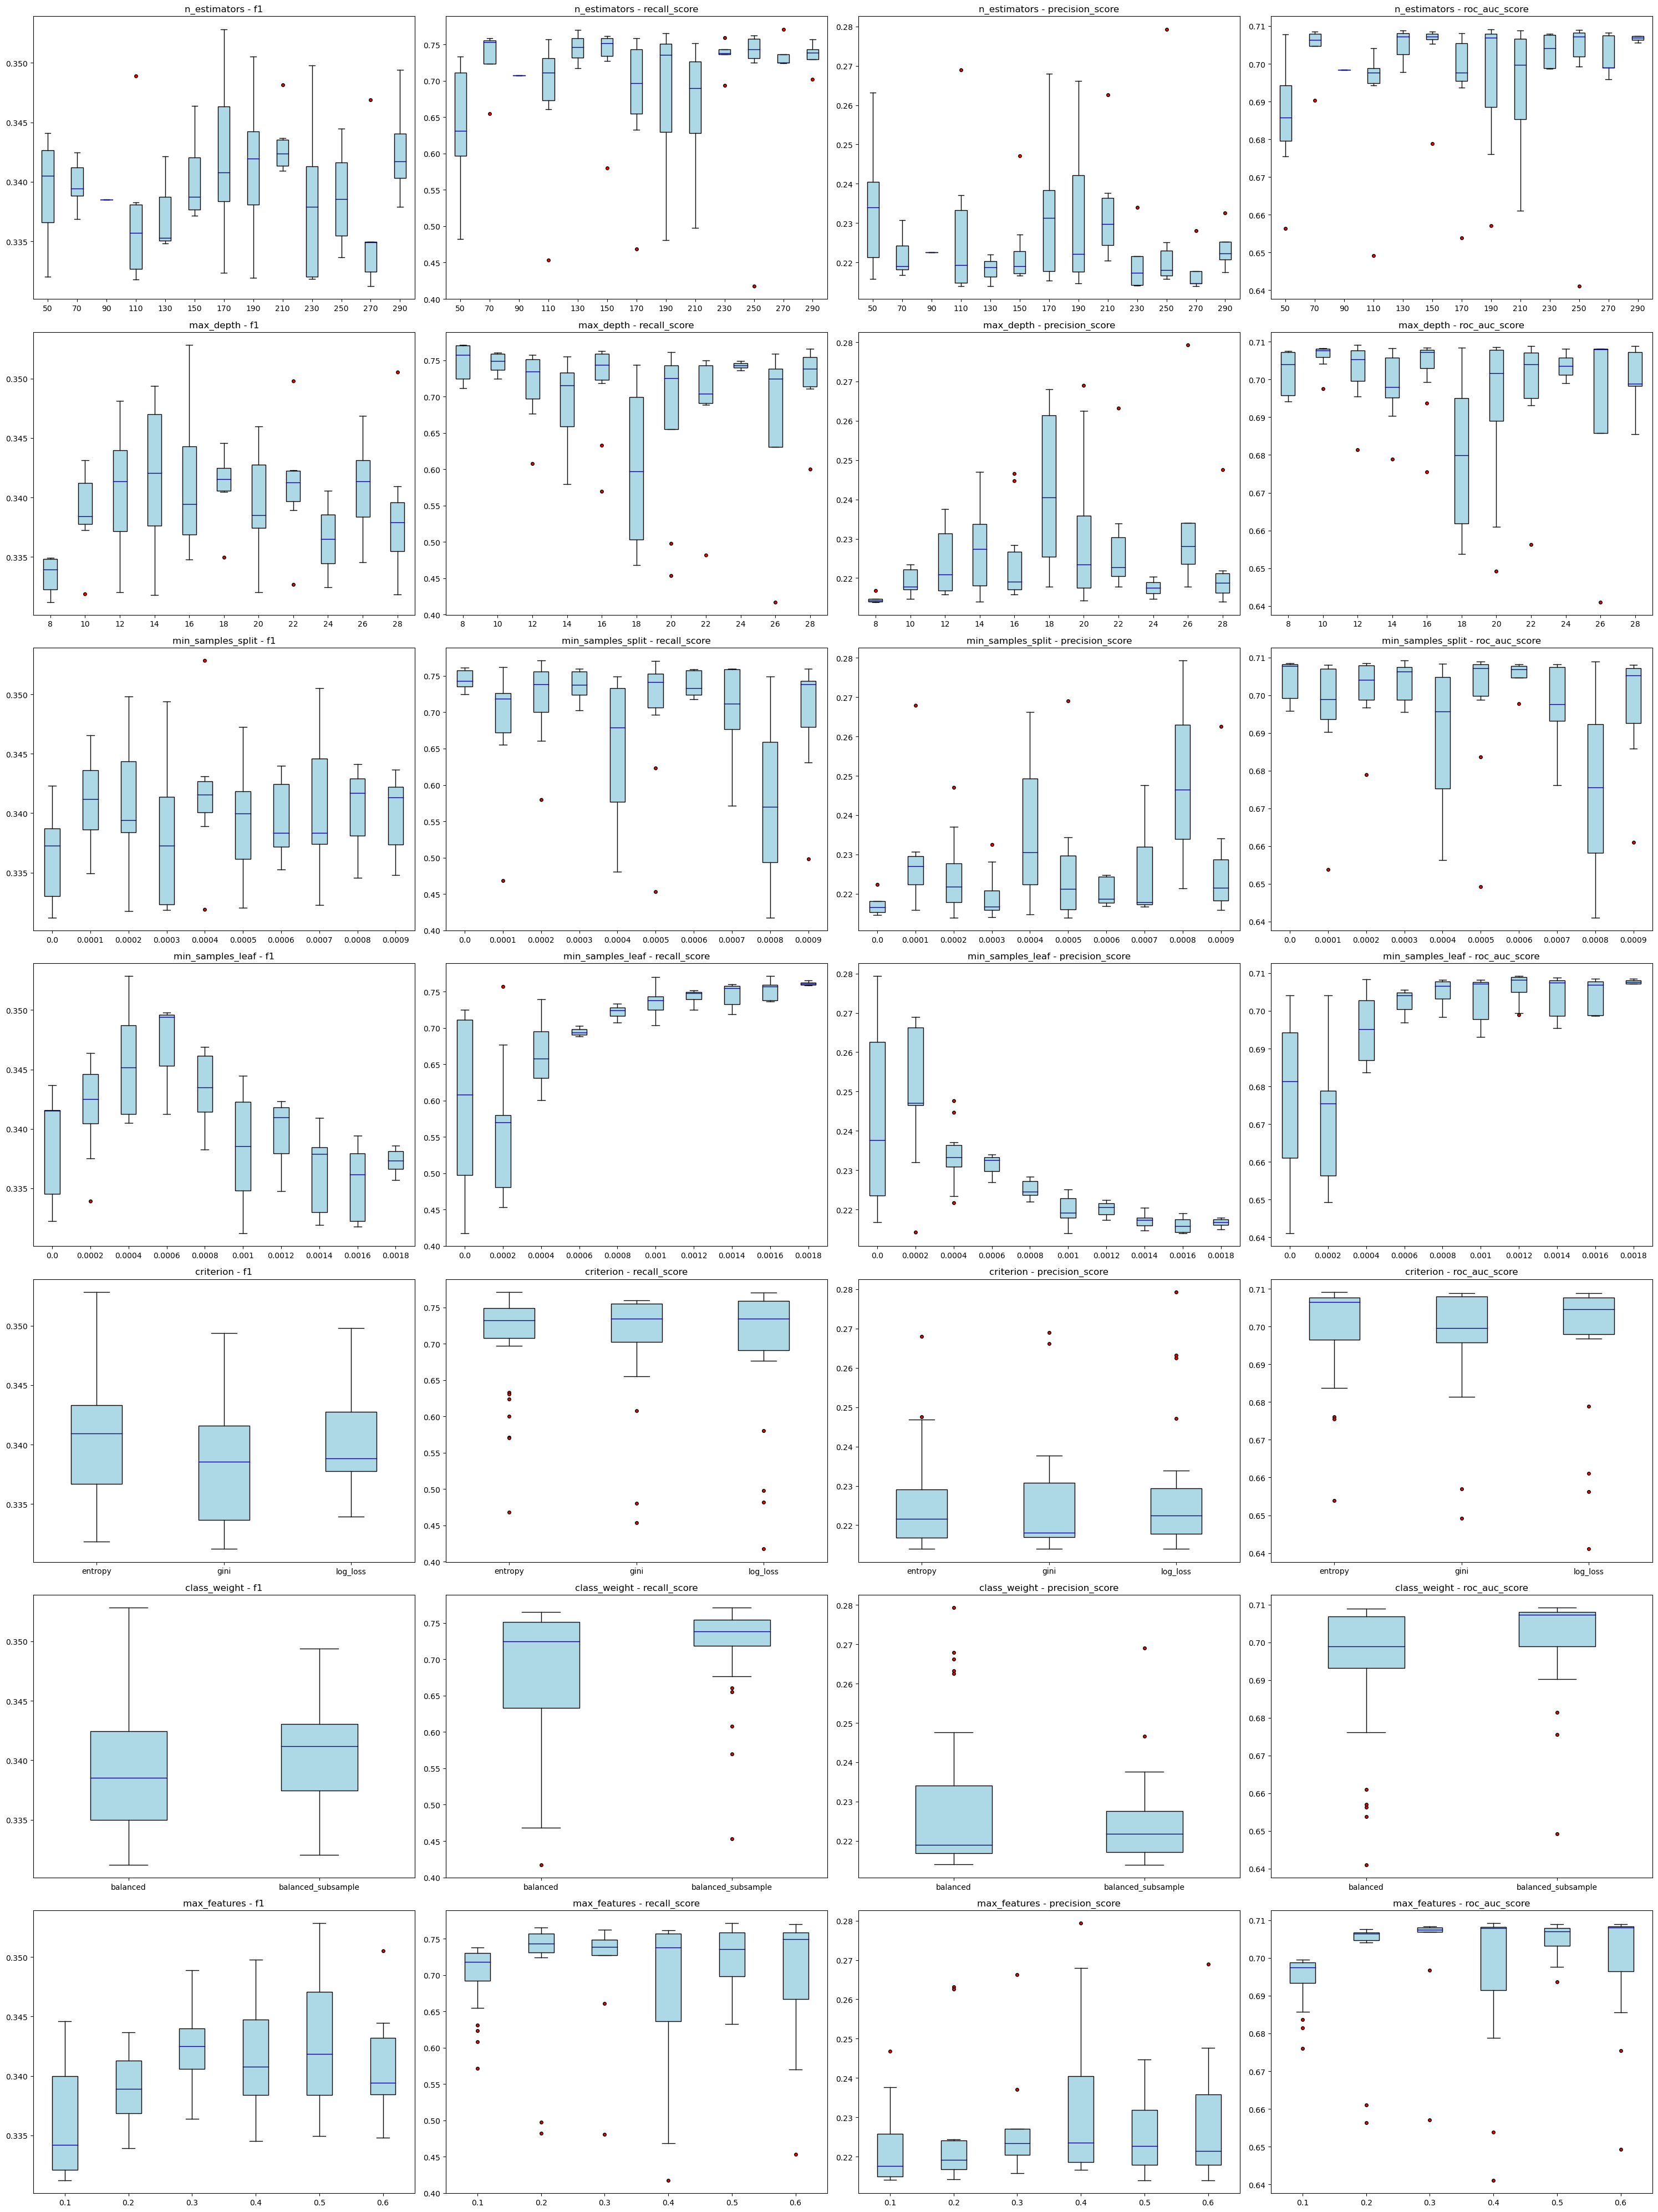

In [74]:
# num_best_models = 80

# best_models = sorted(result, key = lambda x: -x[1]['f1'][1])[:num_best_models]
# fig,ax = plt.subplots(ncols = len(result[0][1]), nrows = len(params), figsize = (30,40))

# plot_metrics(result, params, best_models, figsize_param = (30,40))

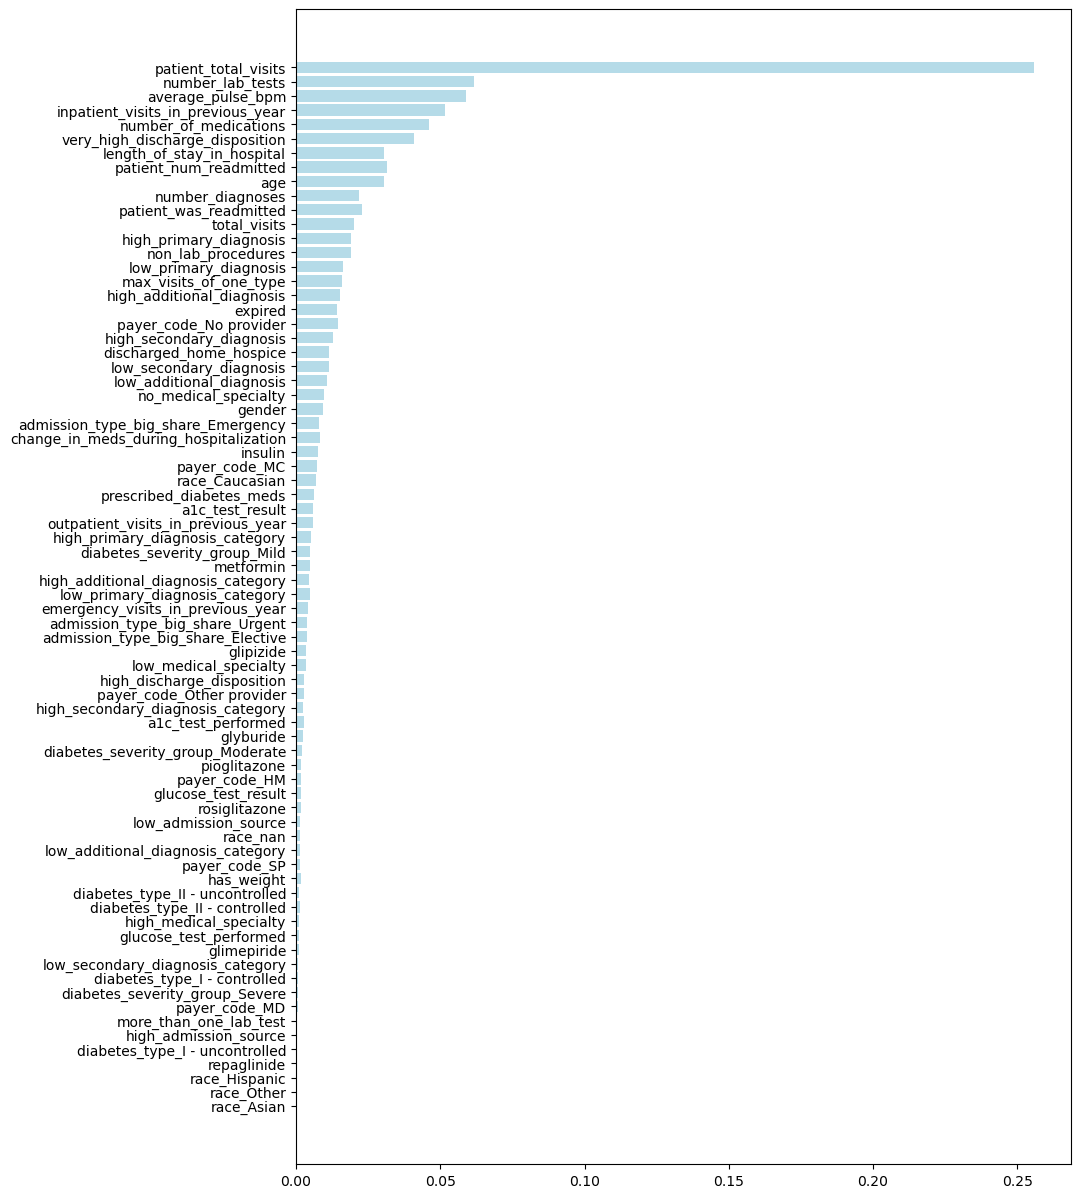

In [75]:
# num_best_models = 10

# best_models = sorted(result, key = lambda x: -x[1]['f1'][1])[:num_best_models]



# fdf = pd.DataFrame(np.array([best_models[k][4] for k in range(len(best_models))]).T)
# fdf['features'] = best_models[0][3]
# fdf.set_index('features', inplace = True)
# ranked_df = fdf.rank(ascending=False)
# ranked_df['median_rank'] = ranked_df.median(axis=1)
# ranked_df['median_feature_importance'] = fdf.median(axis=1)
# ranked_df.reset_index(inplace = True)
# ranked_df = ranked_df[['features', 'median_rank', 'median_feature_importance']]
# features = ranked_df.sort_values(by = 'median_rank').head(30)['features']


# plt.figure(figsize=(10, 15))
# plt.barh(ranked_df.sort_values(by = 'median_rank', ascending = False)['features'], 
#          ranked_df.sort_values(by = 'median_rank', ascending = False)['median_feature_importance'],
#          color='lightblue',  alpha=0.9, linewidth=0, height=0.8, align='center')
         
# # plt.tight_layout()
# plt.show()

In [85]:
# #since we see that all patient level features are important we will not change function of it anyhow
# # we will check on n random models what is best amount of features
# target = 'readmitted_binary'
    
# model = RandomForestClassifier(random_state = random_state)
# params = {
#     'n_estimators': np.arange(50, 100, 10),
#     'max_depth': np.arange(15, 25, 2),
#     'min_samples_split': np.arange(0, 0.001, 0.0002) + 0.000001,
#     'min_samples_leaf': np.arange(0.0004, 0.0008, 0.0002) + 0.000001,
#     'class_weight': ['balanced', 'balanced_subsample'],
#     'max_features': np.arange(0.3,0.5,0.1),
# }

# result_feature_selection = []
# for i in tqdm(range(10)):
#     random_params = {}
#     for key, values in params.items():
#         random_params[key] = random.choice(values)
        
#     for j in tqdm(range(0,80, 10)):

#         features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
#         features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))

#         columns_to_use_full = list(set(columns_to_use).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
#         columns_to_use_full.extend(['patient_id', 'encounter_id'])
                                   
#         X_train = df_train[columns_to_use_full]
#         y_train = df_train[target]
#         X_test = df_test[columns_to_use_full]

#         data = pd.concat([X_train, y_train], axis = 1)
    
#         result_feature_selection.append(
#             (
#                 len(ranked_df)- j,
#              cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params,
                                   
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
                              
#                      upsample = False,   
#                      cv=5)[1]
#             )
#         )

 12%|█████▋                                       | 1/8 [00:33<03:54, 33.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.415, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [01:05<03:15, 32.52s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.414, F1_val: 0.351



 38%|████████████████▉                            | 3/8 [01:35<02:36, 31.30s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.414, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [02:02<01:59, 29.76s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.412, F1_val: 0.350



 62%|████████████████████████████▏                | 5/8 [02:27<01:23, 27.86s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.409, F1_val: 0.348



 75%|█████████████████████████████████▊           | 6/8 [02:46<00:50, 25.16s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.401, F1_val: 0.348



 88%|███████████████████████████████████████▍     | 7/8 [03:02<00:22, 22.15s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.389, F1_val: 0.338



 10%|████▎                                      | 1/10 [03:12<28:55, 192.85s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.353, F1_val: 0.331



 12%|█████▋                                       | 1/8 [00:22<02:40, 22.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.467, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [00:44<02:12, 22.08s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.469, F1_val: 0.350



 38%|████████████████▉                            | 3/8 [01:04<01:45, 21.13s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.468, F1_val: 0.351



 50%|██████████████████████▌                      | 4/8 [01:22<01:20, 20.10s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.467, F1_val: 0.350



 62%|████████████████████████████▏                | 5/8 [01:39<00:56, 18.79s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.460, F1_val: 0.350



 75%|█████████████████████████████████▊           | 6/8 [01:52<00:34, 17.00s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.446, F1_val: 0.348



 88%|███████████████████████████████████████▍     | 7/8 [02:03<00:15, 15.01s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.427, F1_val: 0.340



 20%|████████▌                                  | 2/10 [05:23<20:51, 156.40s/it]

RandomForestClassifier(class_weight='balanced', max_depth=21, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.368, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:27<03:10, 27.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.462, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [00:52<02:36, 26.02s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.462, F1_val: 0.348



 38%|████████████████▉                            | 3/8 [01:16<02:04, 24.96s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.464, F1_val: 0.349



 50%|██████████████████████▌                      | 4/8 [01:37<01:34, 23.71s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.462, F1_val: 0.349



 62%|████████████████████████████▏                | 5/8 [01:57<01:06, 22.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.457, F1_val: 0.351



 75%|█████████████████████████████████▊           | 6/8 [02:13<00:40, 20.07s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.445, F1_val: 0.349



 88%|███████████████████████████████████████▍     | 7/8 [02:25<00:17, 17.63s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.424, F1_val: 0.340



 30%|████████████▉                              | 3/10 [07:57<18:06, 155.15s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=60, random_state=42)
F1 train: 0.366, F1_val: 0.331



 12%|█████▋                                       | 1/8 [00:23<02:46, 23.86s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.462, F1_val: 0.349



 25%|███████████▎                                 | 2/8 [00:46<02:18, 23.13s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.463, F1_val: 0.347



 38%|████████████████▉                            | 3/8 [01:07<01:51, 22.23s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.464, F1_val: 0.351



 50%|██████████████████████▌                      | 4/8 [01:28<01:27, 21.78s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.462, F1_val: 0.351



 62%|████████████████████████████▏                | 5/8 [01:47<01:01, 20.63s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.457, F1_val: 0.351



 75%|█████████████████████████████████▊           | 6/8 [02:02<00:37, 18.83s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.444, F1_val: 0.348



 88%|███████████████████████████████████████▍     | 7/8 [02:15<00:16, 16.71s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.423, F1_val: 0.340



 40%|█████████████████▏                         | 4/10 [10:20<15:02, 150.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.365, F1_val: 0.331



 12%|█████▋                                       | 1/8 [00:38<04:28, 38.31s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.451, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [01:13<03:39, 36.59s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.453, F1_val: 0.348



 38%|████████████████▉                            | 3/8 [01:47<02:55, 35.11s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.456, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [02:18<02:14, 33.55s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.454, F1_val: 0.351



 62%|████████████████████████████▏                | 5/8 [02:45<01:34, 31.38s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.452, F1_val: 0.349



 75%|█████████████████████████████████▊           | 6/8 [03:08<00:56, 28.44s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.437, F1_val: 0.350



 88%|███████████████████████████████████████▍     | 7/8 [03:26<00:25, 25.12s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.418, F1_val: 0.340



 50%|█████████████████████▌                     | 5/10 [13:59<14:35, 175.00s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.363, F1_val: 0.332



 12%|█████▋                                       | 1/8 [00:18<02:12, 18.94s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.453, F1_val: 0.350



 25%|███████████▎                                 | 2/8 [00:36<01:49, 18.27s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.454, F1_val: 0.350



 38%|████████████████▉                            | 3/8 [00:53<01:27, 17.51s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.455, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [01:08<01:06, 16.64s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.454, F1_val: 0.349



 62%|████████████████████████████▏                | 5/8 [01:22<00:46, 15.62s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.449, F1_val: 0.350



 75%|█████████████████████████████████▊           | 6/8 [01:33<00:28, 14.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.436, F1_val: 0.349



 88%|███████████████████████████████████████▍     | 7/8 [01:43<00:12, 12.63s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.415, F1_val: 0.338



 60%|█████████████████████████▊                 | 6/10 [15:48<10:10, 152.62s/it]

RandomForestClassifier(class_weight='balanced', max_depth=17, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.363, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:28<03:18, 28.35s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.414, F1_val: 0.349



 25%|███████████▎                                 | 2/8 [00:54<02:43, 27.32s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.414, F1_val: 0.349



 38%|████████████████▉                            | 3/8 [01:19<02:10, 26.06s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.415, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [01:42<01:38, 24.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.413, F1_val: 0.349



 62%|████████████████████████████▏                | 5/8 [02:02<01:09, 23.16s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.409, F1_val: 0.348



 75%|█████████████████████████████████▊           | 6/8 [02:19<00:42, 21.02s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.401, F1_val: 0.346



 88%|███████████████████████████████████████▍     | 7/8 [02:33<00:18, 18.64s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.389, F1_val: 0.339



 70%|██████████████████████████████             | 7/10 [18:30<07:47, 155.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=60,
                       random_state=42)
F1 train: 0.352, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:36<04:18, 36.94s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.415, F1_val: 0.349



 25%|███████████▎                                 | 2/8 [01:12<03:35, 36.00s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.415, F1_val: 0.349



 38%|████████████████▉                            | 3/8 [01:44<02:52, 34.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.415, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [02:14<02:10, 32.65s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.412, F1_val: 0.350



 62%|████████████████████████████▏                | 5/8 [02:41<01:31, 30.55s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.409, F1_val: 0.349



 75%|█████████████████████████████████▊           | 6/8 [03:03<00:55, 27.76s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.400, F1_val: 0.348



 88%|███████████████████████████████████████▍     | 7/8 [03:22<00:24, 24.66s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.390, F1_val: 0.338



 80%|██████████████████████████████████▍        | 8/10 [22:04<05:48, 174.40s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=21,
                       max_features=0.4, min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0008010000000000001, n_estimators=80,
                       random_state=42)
F1 train: 0.352, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:21<02:32, 21.73s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.409, F1_val: 0.349



 25%|███████████▎                                 | 2/8 [00:42<02:05, 20.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.410, F1_val: 0.348



 38%|████████████████▉                            | 3/8 [01:00<01:39, 19.94s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.409, F1_val: 0.347



 50%|██████████████████████▌                      | 4/8 [01:18<01:15, 18.90s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.408, F1_val: 0.347



 62%|████████████████████████████▏                | 5/8 [01:33<00:53, 17.67s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.406, F1_val: 0.347



 75%|█████████████████████████████████▊           | 6/8 [01:46<00:31, 15.98s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.399, F1_val: 0.347



 88%|███████████████████████████████████████▍     | 7/8 [01:56<00:14, 14.02s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.385, F1_val: 0.339



 90%|██████████████████████████████████████▋    | 9/10 [24:07<02:38, 158.16s/it]

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.4,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.0006010000000000001, n_estimators=50,
                       random_state=42)
F1 train: 0.350, F1_val: 0.330



 12%|█████▋                                       | 1/8 [00:22<02:40, 22.91s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.461, F1_val: 0.351



 25%|███████████▎                                 | 2/8 [00:44<02:11, 21.96s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.461, F1_val: 0.350



 38%|████████████████▉                            | 3/8 [01:04<01:44, 20.99s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.458, F1_val: 0.350



 50%|██████████████████████▌                      | 4/8 [01:22<01:19, 19.91s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.456, F1_val: 0.351



 62%|████████████████████████████▏                | 5/8 [01:39<00:56, 18.78s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.450, F1_val: 0.350



 75%|█████████████████████████████████▊           | 6/8 [01:52<00:34, 17.08s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.437, F1_val: 0.349



 88%|███████████████████████████████████████▍     | 7/8 [02:04<00:15, 15.23s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.419, F1_val: 0.341



100%|██████████████████████████████████████████| 10/10 [26:18<00:00, 157.90s/it]

RandomForestClassifier(class_weight='balanced', max_depth=23, max_features=0.3,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=60,
                       random_state=42)
F1 train: 0.366, F1_val: 0.329


In [ ]:
# with open('Learning_results/rf_feature_selection_num_features.pkl', 'wb') as file:
#     pickle.dump(result_feature_selection, file)

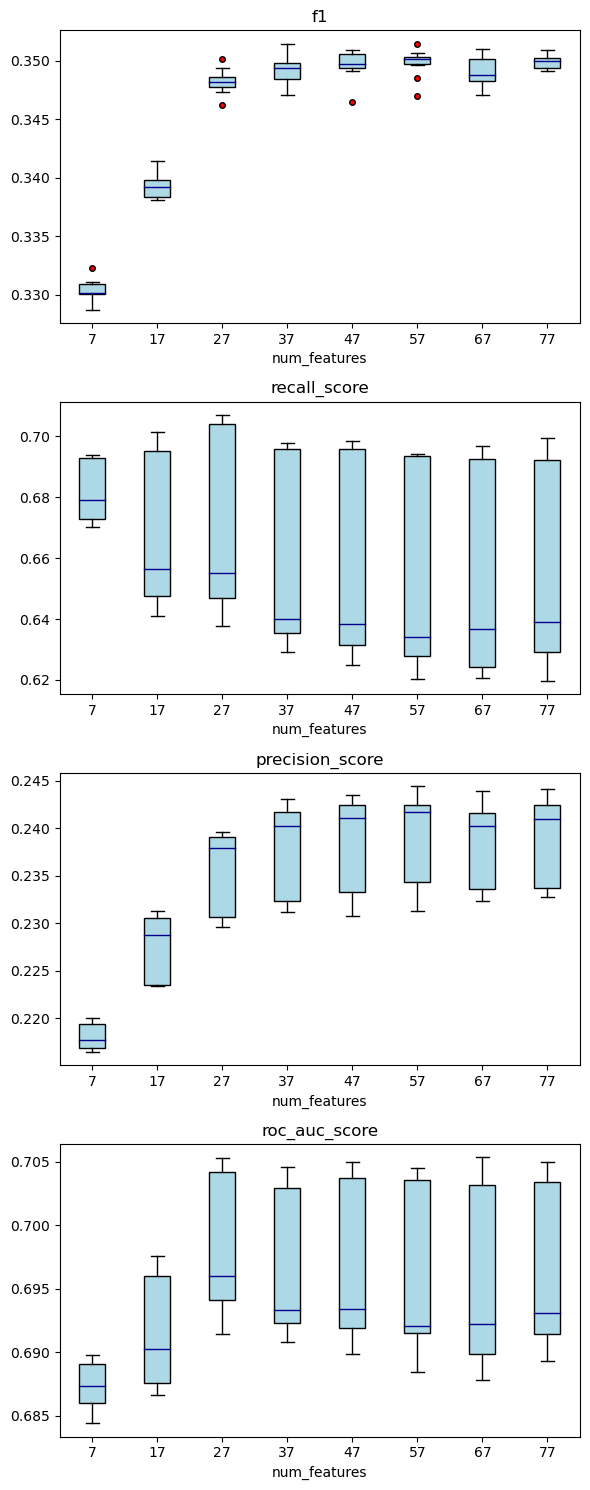

In [86]:
# result_feature_selection_df = pd.DataFrame(result_feature_selection)

# result_feature_selection_df[list(result_feature_selection_df[1][0].keys())] = pd.DataFrame(result_feature_selection_df[1].apply(lambda x: [x[i][1] for i in x.keys()]).apply(pd.Series)
# )

# result_feature_selection_df.rename(columns={0: 'num_features'}, inplace=True)
# fig,ax = plt.subplots( nrows = len(list(result_feature_selection_df[1][0].keys())), figsize = (6,15))
# result_feature_selection_df = result_feature_selection_df.sort_values(by='num_features')

# for m in range(len(list(result_feature_selection_df[1][0].keys()))):
#     metric = list(result_feature_selection_df[1][0].keys())[m]
#     # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).max())
#     # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).min())
#     # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).median())

#     ax[m].boxplot([group[1][metric].values for group in result_feature_selection_df.groupby('num_features')],
#             labels = result_feature_selection_df['num_features'].unique()+3,
#             patch_artist=True,
#             widths=0.4,         
#             medianprops=dict(color='darkblue'),
#             boxprops=dict(facecolor='lightblue', edgecolor='black'),
#              whiskerprops=dict(color='black'), 
#              capprops=dict(color='black'),
#             flierprops=dict(markerfacecolor='red', marker='o', markersize=4) )
                       
#     ax[m].set_title(metric)
#     ax[m].set_xlabel('num_features')

# plt.tight_layout()
# plt.show()

In [29]:
# #We gonna go for 40 best features according to plot, since this amount tends to give more stable results 
# # and there is no real improve further
# # Redefine data with new selected columns

# #firstly save it

# # features =  list(set(list(ranked_df.sort_values(by = 'median_rank').head(40)['features'])).intersection(set(columns_to_use)))
# # features.extend(['encounter_id', 'patient_id'])
# # with open('Learning_results/selected_features_rf.pkl', 'wb') as file:
# #     pickle.dump(features, file)

# with open('Learning_results/selected_features_rf.pkl', 'rb') as file:
#     # Load the pickled data
#     features = pickle.load(file)

# X_train = df_train[features]
# y_train = df_train[target]
# X_test = df_test[features]

# features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(set(features)))
# features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(set(features)))

# data = pd.concat([X_train, y_train], axis = 1)

# target = 'readmitted_binary'



#### Logreg Lasso Coef

In [162]:
# features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
#        'emergency_visits_in_previous_year',
#        'inpatient_visits_in_previous_year', 'total_visits',
#        'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
#        'non_lab_procedures', 'number_diagnoses', 'glucose_test_result','a1c_test_result'
#                               ]
# features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

# columns_to_use_full = columns_to_use #+ features_for_encoding

# X_train = df_train[columns_to_use_full]
# y_train = df_train[target]
# X_test = df_test[columns_to_use_full]

# data = pd.concat([X_train, y_train], axis = 1)

# target = 'readmitted_binary'

In [164]:
# model = LogisticRegression(solver='saga', max_iter = 200, 
#                            class_weight = 'balanced', random_state = random_state )
# params = {
#     'penalty': 'l1',
#     'max_iter': 1000
# }

# result_log_reg = []
# result_log_reg.append(cross_validation(data, 
#                  target, 
#                  model, 
#                  params,                
#                  scaling = True,
#                  features_for_scaling_minmax = features_for_scaling_minmax,
#                  features_for_scaling_standard = features_for_scaling_standard,
#                  cv=5))

/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.315, F1_val: 0.316


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


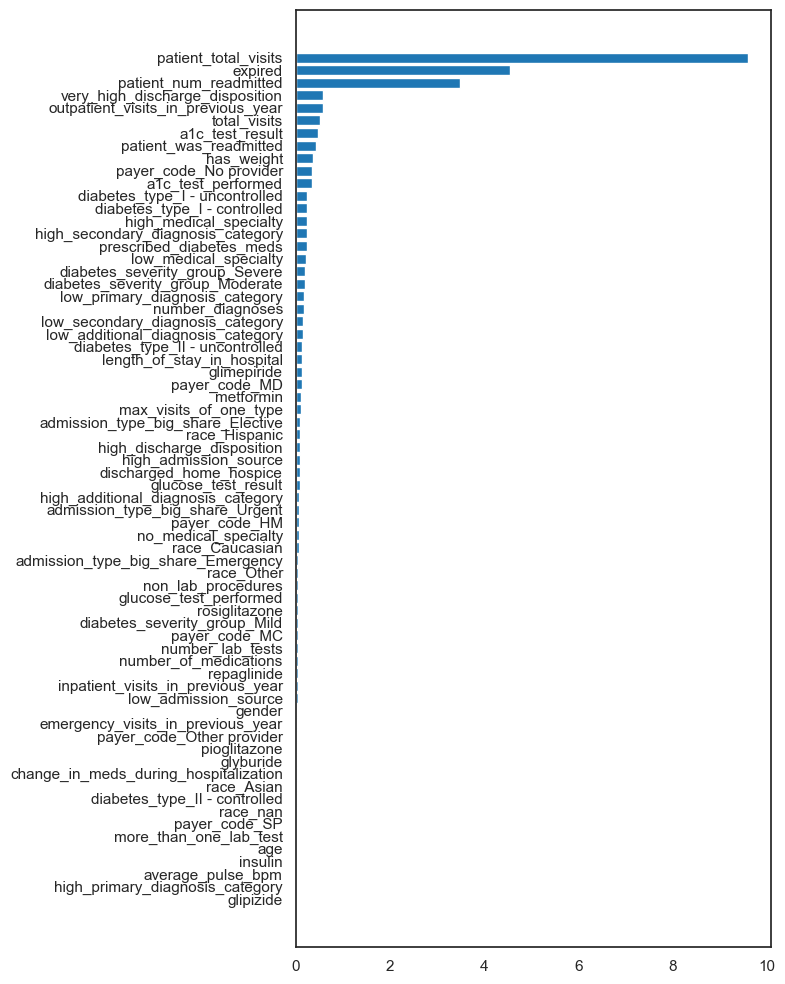

In [167]:

# fdf = pd.DataFrame(np.abs(result_log_reg[0][-1][0]), columns = ['coef'])
# fdf['features'] = result_log_reg[0][3]
# fdf.set_index('features', inplace = True)
# fdf['rank'] = fdf.rank(ascending=False)
# fdf.reset_index(inplace = True)

# plt.figure(figsize=(8, 10))
# plt.barh(fdf.sort_values(by = 'rank', ascending = False)['features'], fdf.sort_values(by = 'rank', ascending = False)['coef'])
# plt.tight_layout()
# plt.show()

In [180]:
# model = LogisticRegression(solver='saga', max_iter = 200, 
#                            class_weight = 'balanced', random_state = random_state )
# params = {
#     'penalty': 'l1',
#     'max_iter': 1000
# }
# result_feature_selection = []

# for j in tqdm(range(40,70, 3)):

#     features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
#     features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))

#     columns_to_use_full = list(set(columns_to_use).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
#     columns_to_use_full.extend(['patient_id', 'encounter_id'])
                               
#     X_train = df_train[columns_to_use_full]
#     y_train = df_train[target]
#     X_test = df_test[columns_to_use_full]

#     data = pd.concat([X_train, y_train], axis = 1)

#     result_feature_selection.append(
#         (
#             len(ranked_df)- j,
#          cross_validation(data, 
#                  target, 
#                  model, 
#                  params,
                               
#                  scaling = True,
#                  features_for_scaling_minmax = features_for_scaling_minmax,
#                  features_for_scaling_standard = features_for_scaling_standard,
                          
#                  upsample = False,   
#                  cv=5)[1]
#         )
#     )

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.313, F1_val: 0.317


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 20%|████████▊           

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.314, F1_val: 0.317


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 30%|█████████████▏      

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.314, F1_val: 0.318


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 40%|█████████████████▌  

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.314, F1_val: 0.316


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|████████████████████

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.306, F1_val: 0.311


 60%|██████████████████████████▍                 | 6/10 [04:05<02:07, 31.82s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.301, F1_val: 0.307


 70%|██████████████████████████████▊             | 7/10 [04:11<01:10, 23.61s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.302, F1_val: 0.309


 80%|███████████████████████████████████▏        | 8/10 [04:17<00:35, 17.77s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.304, F1_val: 0.311


 90%|███████████████████████████████████████▌    | 9/10 [04:21<00:13, 13.61s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.297, F1_val: 0.298


100%|███████████████████████████████████████████| 10/10 [04:22<00:00, 26.29s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
F1 train: 0.312, F1_val: 0.313


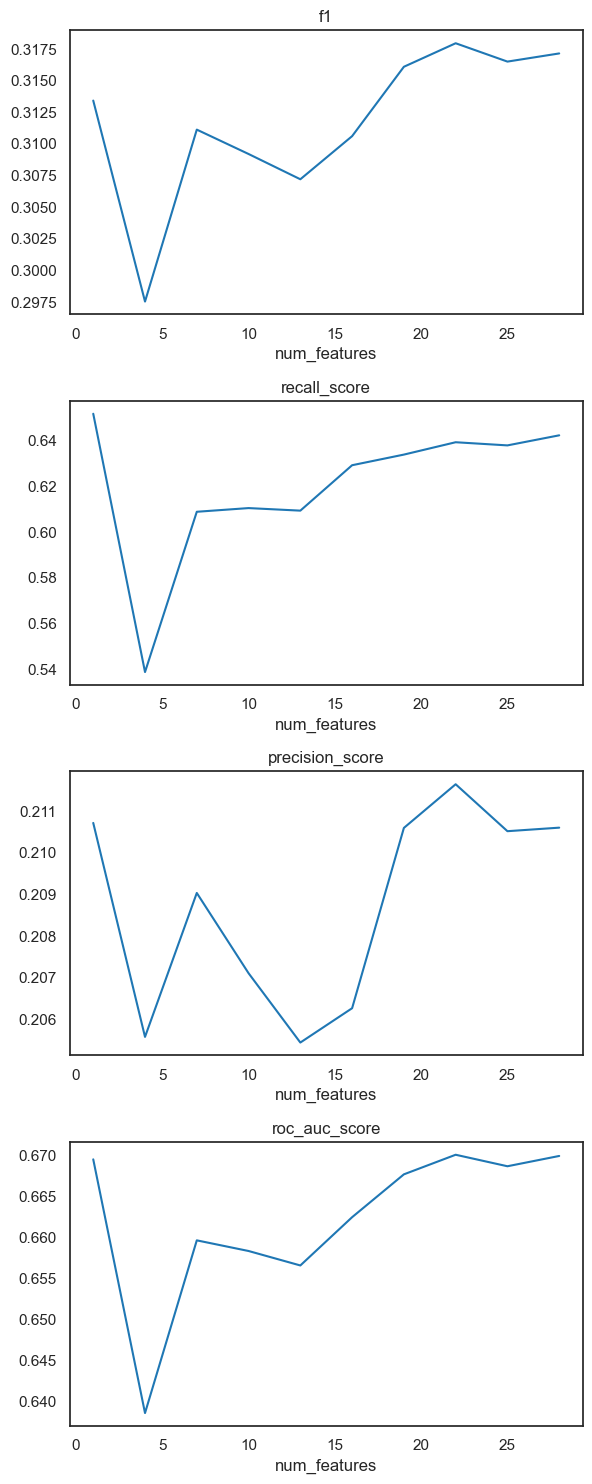

In [181]:
# result_feature_selection_df = pd.DataFrame(result_feature_selection)

# result_feature_selection_df[list(result_feature_selection_df[1][0].keys())] = pd.DataFrame(result_feature_selection_df[1].apply(lambda x: [x[i][1] for i in x.keys()]).apply(pd.Series)
# )

# result_feature_selection_df.rename(columns={0: 'num_features'}, inplace=True)
# fig,ax = plt.subplots( nrows = len(list(result_feature_selection_df[1][0].keys())), figsize = (6,15))
# result_feature_selection_df = result_feature_selection_df.sort_values(by='num_features')

# for m in range(len(list(result_feature_selection_df[1][0].keys()))):
#     metric = list(result_feature_selection_df[1][0].keys())[m]
#     # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).max())
#     # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).min())
#     ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).median())

#     # ax[m].boxplot([group[1][metric].values for group in result_feature_selection_df.groupby('num_features')],
#     #         labels = result_feature_selection_df['num_features'].unique(),
#     #         patch_artist=True,
#     #         widths=0.4,         
#     #         medianprops=dict(color='darkblue'),
#     #         boxprops=dict(facecolor='lightblue', edgecolor='black'),
#     #          whiskerprops=dict(color='black'), 
#     #          capprops=dict(color='black'),
#     #         flierprops=dict(markerfacecolor='red', marker='o', markersize=4) )
                       
#     ax[m].set_title(metric)
#     ax[m].set_xlabel('num_features')

# plt.tight_layout()
# plt.show()

### Model selection

In [172]:
# with open('Learning_results/selected_features_rf.pkl', 'rb') as file:
#     # Load the pickled data
#     features = pickle.load(file)

# df_train = pd.read_csv('Data/df_train_preprocessed.csv')
# df_test = pd.read_csv('Data/df_test_preprocessed.csv')

# features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
#        'emergency_visits_in_previous_year',
#        'inpatient_visits_in_previous_year', 'total_visits',
#        'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
#        'non_lab_procedures', 'number_diagnoses', 'glucose_test_result','a1c_test_result'
#                               ]
# features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

# X_train = df_train[features]
# y_train = df_train[target]
# X_test = df_test[features]

# features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(set(features)))
# features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(set(features)))

# data = pd.concat([X_train, y_train], axis = 1)

# target = 'readmitted_binary'

#### RF

In [173]:
# #change grid based on knowledge from feature selection

# model = RandomForestClassifier(random_state = random_state)
# rf_params = {
#     'n_estimators': np.arange(150, 200, 10),
#     'max_depth': np.arange(10, 30, 2),
#     'min_samples_split': np.arange(0.0002, 0.001, 0.0001),
#     'min_samples_leaf': np.arange(0.0002, 0.001, 0.0001),
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'class_weight': ['balanced', 'balanced_subsample'],
#     'max_features': np.arange(0.3,0.9,0.1),
# }

# rf_result = []
# for i in tqdm(range(100)):
#     random_params = {}
#     for key, values in rf_params.items():
#         random_params[key] = random.choice(values)
#     rf_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params,
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,    
#                      upsample = False,   
#                      cv=5))

  1%|▍                                       | 1/100 [02:06<3:29:28, 126.96s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.8000000000000002,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.486, F1_val: 0.349


  2%|▊                                        | 2/100 [03:12<2:28:31, 90.94s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=24, max_features=0.5,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=170, random_state=42)
F1 train: 0.387, F1_val: 0.344


  3%|█▏                                      | 3/100 [05:04<2:42:18, 100.40s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=18, max_features=0.9000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0005, n_estimators=170,
                       random_state=42)
F1 train: 0.405, F1_val: 0.346


  4%|█▌                                      | 4/100 [07:17<3:01:38, 113.53s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=18, max_features=0.9000000000000001,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.460, F1_val: 0.349


  5%|██                                       | 5/100 [08:12<2:26:07, 92.28s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.3, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=190, random_state=42)
F1 train: 0.396, F1_val: 0.345


  6%|██▍                                      | 6/100 [08:54<1:57:40, 75.11s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, max_features=0.3,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.368, F1_val: 0.338


  7%|██▊                                      | 7/100 [10:29<2:06:28, 81.60s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=12, max_features=0.8000000000000002,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=170, random_state=42)
F1 train: 0.410, F1_val: 0.344


  8%|███▎                                     | 8/100 [11:58<2:08:55, 84.08s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.7000000000000002, min_samples_leaf=0.0002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.548, F1_val: 0.339


  9%|███▋                                     | 9/100 [13:05<1:59:30, 78.80s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.5, min_samples_leaf=0.0002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.555, F1_val: 0.343


 10%|████                                    | 10/100 [13:44<1:39:32, 66.36s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.3, min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.363, F1_val: 0.339


 11%|████▍                                   | 11/100 [14:58<1:41:55, 68.71s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=28, max_features=0.5,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.421, F1_val: 0.348


 12%|████▊                                   | 12/100 [16:16<1:44:56, 71.55s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.5,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=190, random_state=42)
F1 train: 0.421, F1_val: 0.348


 13%|█████▏                                  | 13/100 [17:31<1:45:10, 72.53s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=28, max_features=0.6000000000000001,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.411, F1_val: 0.347


 14%|█████▌                                  | 14/100 [19:42<2:09:20, 90.23s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=18, max_features=0.8000000000000002,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.665, F1_val: 0.326


 15%|██████                                  | 15/100 [20:44<1:55:43, 81.68s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.385, F1_val: 0.341


 16%|██████▍                                 | 16/100 [21:55<1:49:50, 78.46s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=18, max_features=0.5,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.521, F1_val: 0.349


 17%|██████▊                                 | 17/100 [22:55<1:41:08, 73.12s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.492, F1_val: 0.349


 18%|███████▏                                | 18/100 [23:36<1:26:26, 63.25s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.3,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.397, F1_val: 0.344


 19%|███████▌                                | 19/100 [24:43<1:26:49, 64.32s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.4, min_samples_leaf=0.0002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.451, F1_val: 0.344


 20%|████████                                | 20/100 [26:07<1:33:46, 70.33s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=18, max_features=0.6000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.537, F1_val: 0.348


 21%|████████▍                               | 21/100 [28:18<1:56:37, 88.58s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=18, max_features=0.9000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.405, F1_val: 0.346


 22%|████████▊                               | 22/100 [29:39<1:52:07, 86.25s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.397, F1_val: 0.345


 23%|█████████▏                              | 23/100 [30:35<1:39:14, 77.34s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=28, max_features=0.4,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0005, n_estimators=160,
                       random_state=42)
F1 train: 0.393, F1_val: 0.345


 24%|█████████▌                              | 24/100 [32:04<1:42:15, 80.74s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.6000000000000001,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=190,
                       random_state=42)
F1 train: 0.410, F1_val: 0.346


 25%|██████████                              | 25/100 [33:06<1:34:01, 75.23s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.4,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=160, random_state=42)
F1 train: 0.504, F1_val: 0.348


 26%|██████████▍                             | 26/100 [34:37<1:38:31, 79.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features=0.7000000000000002,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.395, F1_val: 0.344


 27%|██████████▊                             | 27/100 [36:37<1:51:52, 91.96s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.9000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.422, F1_val: 0.347


 28%|███████████▏                            | 28/100 [37:57<1:45:55, 88.26s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.7000000000000002,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=150,
                       random_state=42)
F1 train: 0.442, F1_val: 0.347


 29%|███████████▌                            | 29/100 [39:34<1:47:29, 90.83s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=12, max_features=0.8000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0005, n_estimators=180,
                       random_state=42)
F1 train: 0.388, F1_val: 0.343


 30%|████████████                            | 30/100 [40:12<1:27:34, 75.06s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_features=0.3,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0002, n_estimators=150,
                       random_state=42)
F1 train: 0.379, F1_val: 0.342


 31%|████████████▍                           | 31/100 [41:00<1:16:54, 66.87s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=26, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=150, random_state=42)
F1 train: 0.474, F1_val: 0.349


 32%|████████████▊                           | 32/100 [42:33<1:24:53, 74.91s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=22, max_features=0.6000000000000001,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.450, F1_val: 0.348


 33%|█████████████▏                          | 33/100 [43:25<1:15:41, 67.79s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=14, max_features=0.4,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.389, F1_val: 0.344


 34%|█████████████▌                          | 34/100 [44:08<1:06:23, 60.36s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.3,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.387, F1_val: 0.343


 35%|██████████████                          | 35/100 [45:13<1:07:02, 61.89s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.425, F1_val: 0.346


 36%|██████████████▍                         | 36/100 [46:04<1:02:38, 58.73s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=180, random_state=42)
F1 train: 0.471, F1_val: 0.351


 37%|██████████████▊                         | 37/100 [47:54<1:17:41, 74.00s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.8000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0002, n_estimators=170,
                       random_state=42)
F1 train: 0.432, F1_val: 0.348


 38%|███████████████▏                        | 38/100 [48:59<1:13:45, 71.37s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=18, max_features=0.5,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=160, random_state=42)
F1 train: 0.422, F1_val: 0.348


 39%|███████████████▌                        | 39/100 [50:05<1:10:44, 69.59s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.4, min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.391, F1_val: 0.344


 40%|████████████████                        | 40/100 [51:39<1:16:57, 76.96s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features=0.9000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.442, F1_val: 0.344


 41%|████████████████▍                       | 41/100 [52:39<1:10:44, 71.93s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.5, min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.386, F1_val: 0.342


 42%|████████████████▊                       | 42/100 [54:08<1:14:28, 77.05s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=24, max_features=0.6000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.550, F1_val: 0.347


 43%|█████████████████▏                      | 43/100 [55:45<1:18:46, 82.92s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.9000000000000001,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.410, F1_val: 0.346


 44%|█████████████████▌                      | 44/100 [56:36<1:08:24, 73.30s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.4, min_samples_leaf=0.0005,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=170, random_state=42)
F1 train: 0.378, F1_val: 0.340


 45%|██████████████████                      | 45/100 [57:53<1:08:20, 74.56s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.5, min_samples_leaf=0.0002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.657, F1_val: 0.329


 46%|██████████████████▍                     | 46/100 [59:38<1:15:19, 83.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.7000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=190, random_state=42)
F1 train: 0.401, F1_val: 0.346


 47%|█████████████████▊                    | 47/100 [1:01:02<1:14:05, 83.88s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.9000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.373, F1_val: 0.340


 48%|██████████████████▏                   | 48/100 [1:02:35<1:14:53, 86.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.378, F1_val: 0.340


 49%|██████████████████▌                   | 49/100 [1:03:53<1:11:24, 84.01s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.379, F1_val: 0.341


 50%|███████████████████                   | 50/100 [1:05:27<1:12:31, 87.03s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0005, n_estimators=150,
                       random_state=42)
F1 train: 0.430, F1_val: 0.348


 51%|███████████████████▍                  | 51/100 [1:06:54<1:10:57, 86.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=190,
                       random_state=42)
F1 train: 0.409, F1_val: 0.347


 52%|███████████████████▊                  | 52/100 [1:08:20<1:09:24, 86.75s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_features=0.7000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.429, F1_val: 0.348


 53%|████████████████████▏                 | 53/100 [1:09:36<1:05:20, 83.41s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features=0.6000000000000001, min_samples_leaf=0.0002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.452, F1_val: 0.345


 54%|█████████████████████▌                  | 54/100 [1:10:24<55:46, 72.74s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=0.3, min_samples_leaf=0.0005,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.418, F1_val: 0.347


 55%|██████████████████████                  | 55/100 [1:11:56<59:01, 78.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=18, max_features=0.8000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=150, random_state=42)
F1 train: 0.403, F1_val: 0.346


 56%|██████████████████████▍                 | 56/100 [1:13:25<59:50, 81.60s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, max_features=0.7000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.374, F1_val: 0.340


 57%|██████████████████████▊                 | 57/100 [1:14:48<58:56, 82.24s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.5, min_samples_leaf=0.0002,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.599, F1_val: 0.342


 58%|██████████████████████                | 58/100 [1:16:33<1:02:17, 88.99s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=22, max_features=0.7000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.401, F1_val: 0.346


 59%|███████████████████████▌                | 59/100 [1:17:19<51:57, 76.04s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features=0.4,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0002, n_estimators=150,
                       random_state=42)
F1 train: 0.383, F1_val: 0.340


 60%|████████████████████████                | 60/100 [1:19:07<57:01, 85.55s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.430, F1_val: 0.348


 61%|████████████████████████▍               | 61/100 [1:20:07<50:43, 78.05s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=28, max_features=0.5,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.408, F1_val: 0.346


 62%|████████████████████████▊               | 62/100 [1:21:05<45:31, 71.88s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features=0.4, min_samples_leaf=0.0005,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=170, random_state=42)
F1 train: 0.404, F1_val: 0.345


 63%|█████████████████████████▏              | 63/100 [1:22:44<49:25, 80.15s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.384, F1_val: 0.342


 64%|█████████████████████████▌              | 64/100 [1:24:20<50:51, 84.76s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.7000000000000002,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=160,
                       random_state=42)
F1 train: 0.525, F1_val: 0.345


 65%|██████████████████████████              | 65/100 [1:25:26<46:10, 79.15s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4, min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=190, random_state=42)
F1 train: 0.407, F1_val: 0.346


 66%|██████████████████████████▍             | 66/100 [1:27:14<49:52, 88.01s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26,
                       max_features=0.7000000000000002, min_samples_leaf=0.0002,
                       min_samples_split=0.0005, n_estimators=180,
                       random_state=42)
F1 train: 0.650, F1_val: 0.330


 67%|██████████████████████████▊             | 67/100 [1:29:05<52:11, 94.88s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=16, max_features=0.8000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.403, F1_val: 0.345


 68%|██████████████████████████▌            | 68/100 [1:31:08<54:58, 103.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.9000000000000001,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.454, F1_val: 0.348


 69%|███████████████████████████▌            | 69/100 [1:32:28<49:46, 96.33s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24,
                       max_features=0.6000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=180, random_state=42)
F1 train: 0.397, F1_val: 0.344


 70%|███████████████████████████▎           | 70/100 [1:34:21<50:42, 101.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.9000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=170, random_state=42)
F1 train: 0.404, F1_val: 0.345


 71%|████████████████████████████▍           | 71/100 [1:35:04<40:27, 83.72s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=28, max_features=0.3,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0005, n_estimators=150,
                       random_state=42)
F1 train: 0.379, F1_val: 0.342


 72%|████████████████████████████▊           | 72/100 [1:36:26<38:49, 83.20s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features=0.8000000000000002,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0002, n_estimators=170,
                       random_state=42)
F1 train: 0.372, F1_val: 0.340


 73%|█████████████████████████████▏          | 73/100 [1:37:41<36:18, 80.70s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.6000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.420, F1_val: 0.345


 74%|█████████████████████████████▌          | 74/100 [1:38:34<31:28, 72.64s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.5, min_samples_leaf=0.0005,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.380, F1_val: 0.340


 75%|██████████████████████████████          | 75/100 [1:39:33<28:28, 68.32s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=16, max_features=0.4,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=180, random_state=42)
F1 train: 0.392, F1_val: 0.345


 76%|██████████████████████████████▍         | 76/100 [1:40:46<27:54, 69.75s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.5,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=190, random_state=42)
F1 train: 0.387, F1_val: 0.344


 77%|██████████████████████████████▊         | 77/100 [1:41:52<26:20, 68.70s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=18, max_features=0.4,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.496, F1_val: 0.348


 78%|███████████████████████████████▏        | 78/100 [1:43:28<28:10, 76.84s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=20, max_features=0.7000000000000002,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.414, F1_val: 0.347


 79%|███████████████████████████████▌        | 79/100 [1:44:37<26:06, 74.59s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=0.7000000000000002,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.367, F1_val: 0.339


 80%|████████████████████████████████        | 80/100 [1:45:23<21:56, 65.81s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=160,
                       random_state=42)
F1 train: 0.425, F1_val: 0.347


 81%|████████████████████████████████▍       | 81/100 [1:47:11<24:55, 78.74s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=26, max_features=0.8000000000000002,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.704, F1_val: 0.323


 82%|████████████████████████████████▊       | 82/100 [1:48:42<24:38, 82.14s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=20, max_features=0.6000000000000001,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.554, F1_val: 0.345


 83%|█████████████████████████████████▏      | 83/100 [1:50:11<23:51, 84.19s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=18, max_features=0.6000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.538, F1_val: 0.347


 84%|█████████████████████████████████▌      | 84/100 [1:51:09<20:25, 76.59s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=12, max_features=0.4, min_samples_leaf=0.0005,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.404, F1_val: 0.345


 85%|██████████████████████████████████      | 85/100 [1:52:03<17:27, 69.81s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=24, max_features=0.3,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.408, F1_val: 0.346


 86%|██████████████████████████████████▍     | 86/100 [1:53:12<16:12, 69.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.5,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=160, random_state=42)
F1 train: 0.491, F1_val: 0.348


 87%|██████████████████████████████████▊     | 87/100 [1:54:56<17:18, 79.89s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.8000000000000002,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.547, F1_val: 0.344


 88%|███████████████████████████████████▏    | 88/100 [1:56:11<15:38, 78.21s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features=0.6000000000000001,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=180, random_state=42)
F1 train: 0.377, F1_val: 0.341


 89%|███████████████████████████████████▌    | 89/100 [1:57:45<15:12, 82.94s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.6000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.519, F1_val: 0.349


 90%|████████████████████████████████████    | 90/100 [2:00:02<16:31, 99.16s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.9000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0002, n_estimators=180,
                       random_state=42)
F1 train: 0.508, F1_val: 0.350


 91%|███████████████████████████████████▍   | 91/100 [2:01:52<15:22, 102.49s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.9000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0002, n_estimators=150,
                       random_state=42)
F1 train: 0.507, F1_val: 0.346


 92%|████████████████████████████████████▊   | 92/100 [2:02:52<11:58, 89.76s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=26, max_features=0.4,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0002, n_estimators=170,
                       random_state=42)
F1 train: 0.392, F1_val: 0.344


 93%|█████████████████████████████████████▏  | 93/100 [2:03:34<08:49, 75.58s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=26, max_features=0.3,
                       min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0008000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.379, F1_val: 0.343


 94%|█████████████████████████████████████▌  | 94/100 [2:05:04<07:58, 79.72s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.7000000000000002,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=160, random_state=42)
F1 train: 0.455, F1_val: 0.348


 95%|██████████████████████████████████████  | 95/100 [2:06:18<06:30, 78.06s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features=0.8000000000000002, min_samples_leaf=0.0005,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.383, F1_val: 0.341


 96%|██████████████████████████████████████▍ | 96/100 [2:08:03<05:44, 86.10s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=20, max_features=0.6000000000000001,
                       min_samples_leaf=0.0002, min_samples_split=0.0002,
                       n_estimators=180, random_state=42)
F1 train: 0.672, F1_val: 0.328


 97%|██████████████████████████████████████▊ | 97/100 [2:09:56<04:43, 94.36s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28,
                       max_features=0.9000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0002, n_estimators=170,
                       random_state=42)
F1 train: 0.432, F1_val: 0.348


 98%|███████████████████████████████████████▏| 98/100 [2:10:46<02:42, 81.01s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.4, min_samples_leaf=0.0009000000000000002,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=170, random_state=42)
F1 train: 0.366, F1_val: 0.339


 99%|███████████████████████████████████████▌| 99/100 [2:12:33<01:28, 88.73s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=26, max_features=0.8000000000000002,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.566, F1_val: 0.345


100%|███████████████████████████████████████| 100/100 [2:13:55<00:00, 80.35s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=16, max_features=0.6000000000000001,
                       min_samples_leaf=0.0008000000000000001,
                       min_samples_split=0.0005, n_estimators=170,
                       random_state=42)
F1 train: 0.397, F1_val: 0.346


In [174]:
# with open('Learning_results/rf_model_selection.pkl', 'wb') as file:
#     pickle.dump(rf_result, file)

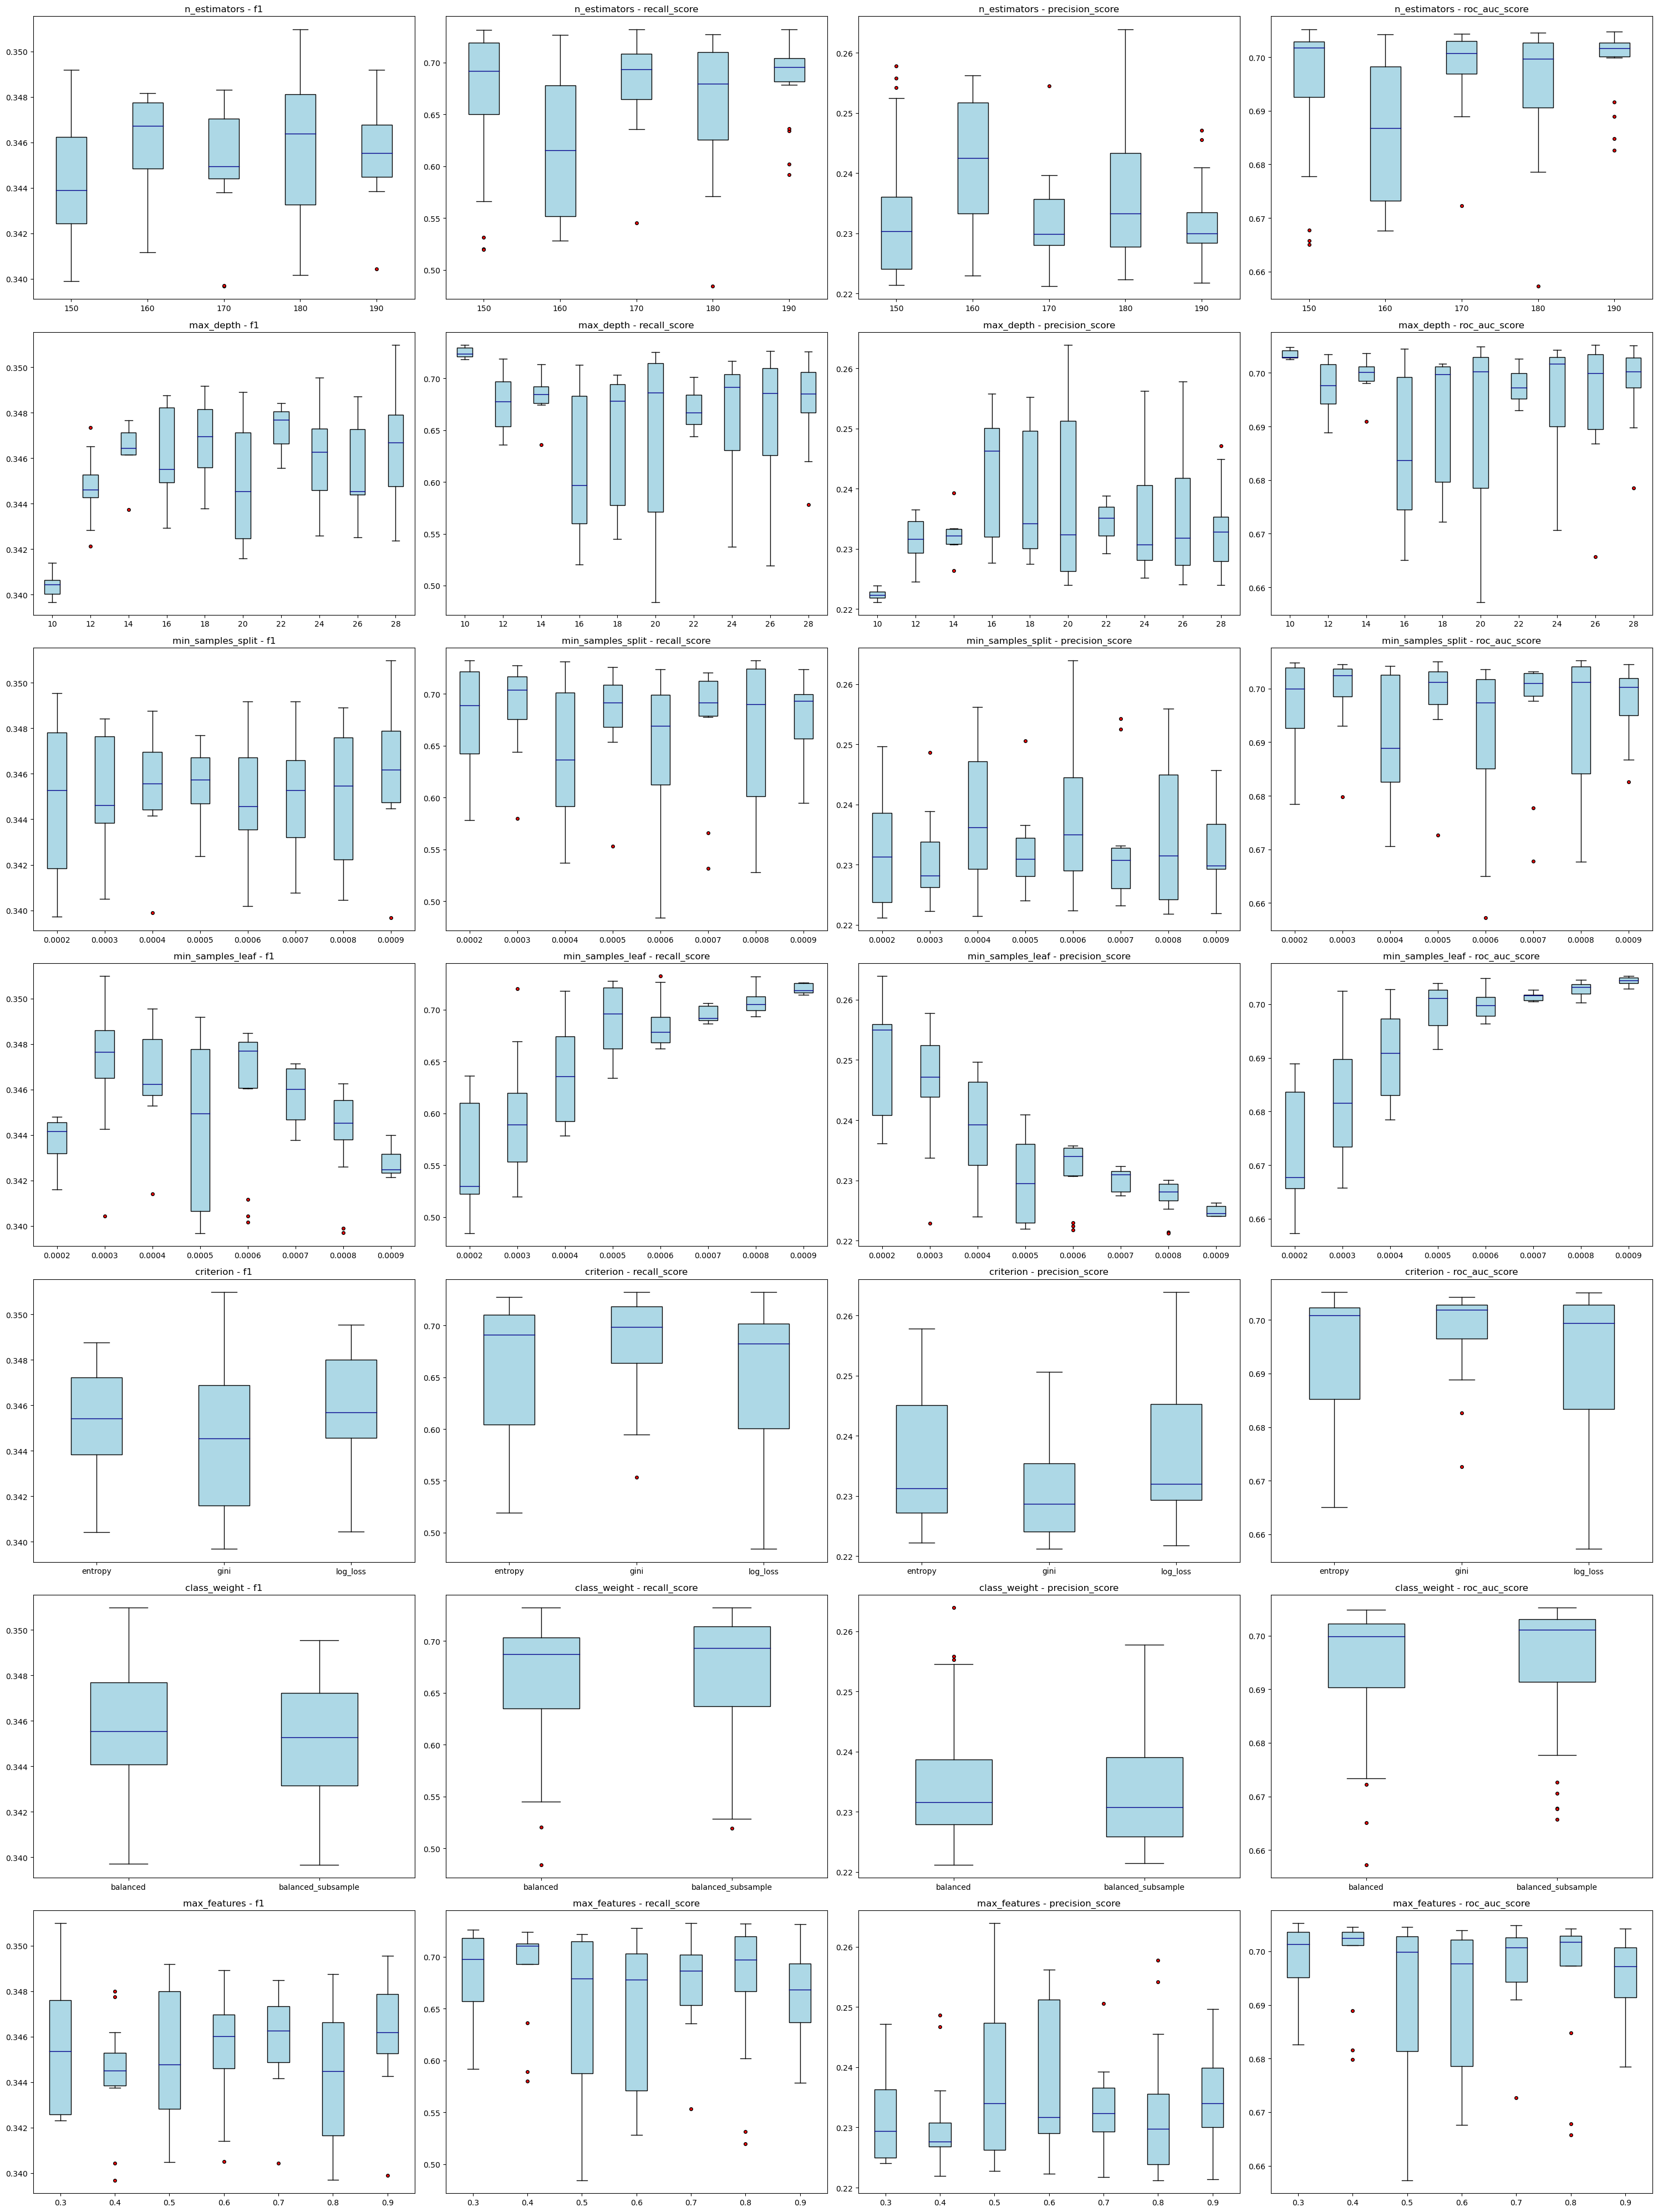

In [175]:
# num_best_models = 90

# best_models = sorted(rf_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

# plot_metrics(rf_result, rf_params, best_models, figsize_param = (30,40))

In [176]:
# best_rf = sorted(rf_result, key = lambda x: -x[1]['f1'][1])[0]
# print('Best Model: {}'.format(RandomForestClassifier(**best_rf[0])))
# print('F1: {}'.format(round(best_rf[1]['f1'][1],4)))

Best Model: RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=180, random_state=42)
F1: 0.351


#### GB

In [218]:
# model = GradientBoostingClassifier(random_state = random_state)

# gb_params = {
#     'n_estimators': np.arange(50, 300, 20),
#     'max_depth': np.arange(1, 10, 1),
#     'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
#     'subsample': np.arange(0.5,1.0,0.1),
#     'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
#     'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
#     'loss': ['exponential', 'log_loss'],
#     'max_features': np.arange(0.1,0.7,0.1),
# }

# gb_upsample_params = []
# gb_result = []
# for i in tqdm(range(30)):
#     random_params = {}
#     for key, values in gb_params.items():
#         random_params[key] = random.choice(values)
        
#     upsample = random.choice([True,False])
#     if upsample == True:
#        upsample_type = random.choice(['simple', 'SMOTE'])
#     else:
#        upsample_type = None
#     gb_upsample_params.append([upsample, upsample_type])
#     print(upsample, upsample_type)
#     gb_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params, 
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = upsample, 
#                      upsample_type = upsample_type,
#                      cv=5))
    

  0%|                                                    | 0/30 [00:00<?, ?it/s]

False None


  3%|█▍                                          | 1/30 [00:12<06:01, 12.47s/it]

GradientBoostingClassifier(max_depth=4, max_features=0.2,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000201, n_estimators=150,
                           random_state=42, subsample=0.5)
F1 train: 0.070, F1_val: 0.011
True simple


  7%|██▉                                         | 2/30 [01:27<23:02, 49.39s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=7, max_features=0.5,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000101, n_estimators=130,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.720, F1_val: 0.330
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, loss='exponential',
                           max_features=0.2, min_samples_leaf=0.001201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42, subsample=0.5)
F1 train: 0.000, F1_val: 0.000
True simple


 13%|█████▊                                      | 4/30 [02:04<12:43, 29.37s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=1,
                           max_features=0.5, min_samples_leaf=0.001801,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.677, F1_val: 0.327
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, max_depth=7, max_features=0.1,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.000201, n_estimators=210,
                           random_state=42, subsample=0.6)
F1 train: 0.000, F1_val: 0.000
True SMOTE


 20%|████████▊                                   | 6/30 [04:47<26:06, 65.28s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000201, n_estimators=230,
                           random_state=42, subsample=0.5)
F1 train: 0.848, F1_val: 0.201
True simple


 23%|██████████▎                                 | 7/30 [05:33<22:37, 59.01s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=5,
                           max_features=0.2, min_samples_leaf=0.001601,
                           min_samples_split=0.000701, n_estimators=270,
                           random_state=42, subsample=0.5)
F1 train: 0.794, F1_val: 0.326
True simple


 27%|███████████▋                                | 8/30 [06:35<22:02, 60.10s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.4, min_samples_leaf=0.001401,
                           min_samples_split=0.000701, n_estimators=250,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.734, F1_val: 0.332
True SMOTE


 30%|█████████████▏                              | 9/30 [07:44<22:01, 62.95s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=230, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.744, F1_val: 0.238
False None


 33%|██████████████▎                            | 10/30 [08:04<16:35, 49.76s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=2,
                           max_features=0.4, min_samples_leaf=0.001401,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=230, random_state=42, subsample=0.7)
F1 train: 0.067, F1_val: 0.033
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                           max_features=0.30000000000000004,
                           min_samples_leaf=1e-06, min_samples_split=1e-06,
                           n_estimators=50, random_state=42, subsample=0.7)
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=5,
                           max_features=0.30000000000000004,
                           min_samples_leaf=1e-06,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.000, F1_val: 0.000
False None


 43%|██████████████████▋                        | 13/30 [09:06<09:03, 31.96s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.000701, n_estimators=290,
                           random_state=42, subsample=0.5)
F1 train: 0.064, F1_val: 0.031
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=9,
                           max_features=0.5, min_samples_leaf=1e-06,
                           min_samples_split=0.000101, n_estimators=70,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=4,
                           max_features=0.1, min_samples_leaf=0.001001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)
F1 train: 0.000, F1_val: 0.000
True SMOTE


 53%|██████████████████████▉                    | 16/30 [10:50<08:22, 35.91s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=90, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.784, F1_val: 0.222
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 57%|████████████████████████▎                  | 17/30 [11:03<06:1

GradientBoostingClassifier(loss='exponential', max_depth=2, max_features=0.4,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000701, n_estimators=150,
                           random_state=42, subsample=0.7)
F1 train: 0.031, F1_val: 0.002
True SMOTE


 60%|█████████████████████████▊                 | 18/30 [11:52<07:00, 35.04s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_features=0.4,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=230, random_state=42, subsample=0.5)
F1 train: 0.896, F1_val: 0.174
False None


 63%|███████████████████████████▏               | 19/30 [12:20<06:00, 32.78s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=6,
                           max_features=0.4, min_samples_leaf=0.001001,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=130, random_state=42, subsample=0.7)
F1 train: 0.183, F1_val: 0.072
False None


 67%|████████████████████████████▋              | 20/30 [12:35<04:34, 27.48s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.4,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=110, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.076, F1_val: 0.028
True SMOTE


 70%|██████████████████████████████             | 21/30 [13:55<06:31, 43.45s/it]

GradientBoostingClassifier(max_depth=8, max_features=0.30000000000000004,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=130, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.924, F1_val: 0.177
False None


 73%|███████████████████████████████▌           | 22/30 [15:46<08:29, 63.74s/it]

GradientBoostingClassifier(max_depth=9, max_features=0.6000000000000001,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=270, random_state=42, subsample=0.7)
F1 train: 0.575, F1_val: 0.104
True simple


 77%|████████████████████████████████▉          | 23/30 [15:55<05:30, 47.27s/it]

GradientBoostingClassifier(max_features=0.2, min_samples_leaf=0.001001,
                           min_samples_split=0.000701, n_estimators=50,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.704, F1_val: 0.330
True SMOTE


 80%|██████████████████████████████████▍        | 24/30 [17:00<05:15, 52.56s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features=0.5,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000201, n_estimators=150,
                           random_state=42, subsample=0.5)
F1 train: 0.851, F1_val: 0.219
False None


 83%|███████████████████████████████████▊       | 25/30 [17:33<03:53, 46.62s/it]

GradientBoostingClassifier(loss='exponential', max_depth=4, max_features=0.5,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=170, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.065, F1_val: 0.012
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, max_features=0.1,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000201, n_estimators=90,
                           random_state=42, subsample=0.6)
F1 train: 0.000, F1_val: 0.000
True SMOTE


 90%|██████████████████████████████████████▋    | 27/30 [18:11<01:41, 33.81s/it]

GradientBoostingClassifier(loss='exponential', max_features=0.5,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000701, n_estimators=50,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.863, F1_val: 0.220
True SMOTE


 93%|████████████████████████████████████████▏  | 28/30 [19:54<01:49, 54.60s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, max_features=0.4,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.000701, n_estimators=270,
                           random_state=42, subsample=0.7)
F1 train: 0.925, F1_val: 0.188
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

GradientBoostingClassifier(learning_rate=0.001, max_depth=2, max_features=0.5,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=130, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|███████████████████████████████████████████| 30/30 [20:19<00:00, 40.63s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential',
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001201, min_samples_split=1e-06,
                           n_estimators=70, random_state=42, subsample=0.5)
F1 train: 0.047, F1_val: 0.009


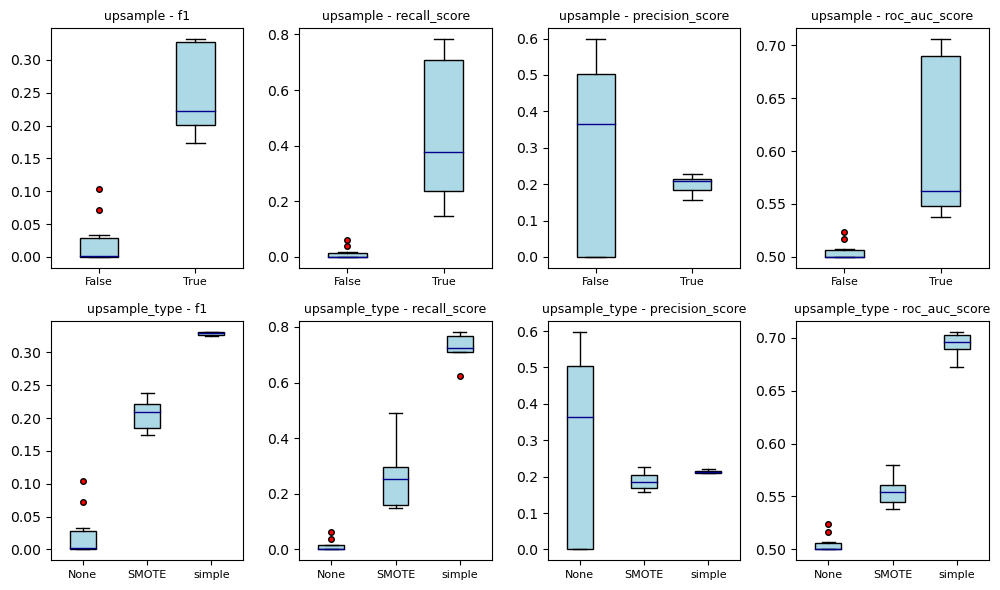

In [219]:
# upsample_list = ['upsample', 'upsample_type']

# fig,ax = plt.subplots(ncols = len(gb_result[0][1]), nrows = len(upsample_list), figsize = (10,6))
    
# for m in range(len(gb_result[0][1])):
#     for key in range(len(upsample_list)):
#         hyperparam = upsample_list[key]
#         metric = list(gb_result[0][1].keys())[m]
#         hyperparam_df = pd.DataFrame(list(zip([i[key] for i in gb_upsample_params], [( gb_result[i][1][metric][1]) for i in range(len(gb_result))])),
#                                      columns = ['hyperparameter', metric]).fillna('None')
#         if hyperparam_df['hyperparameter'].dtype == 'O':
#             hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
#         hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
        
#         ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
#         labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
#         patch_artist=True,
#         widths=0.4,         
#         medianprops=dict(color='darkblue'),
#         boxprops=dict(facecolor='lightblue', edgecolor='black'),
#          whiskerprops=dict(color='black'), 
#          capprops=dict(color='black'),
#         flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
#                           ) 
#         ax[key, m].tick_params(axis='x', labelsize=8)
#         ax[key, m].set_title(hyperparam + ' - ' + metric, fontsize=9)

#         ax[key, m].xaxis.grid(False)
#         ax[key, m].yaxis.grid(False)
# plt.tight_layout()
# plt.savefig('Images/gradient_boosting_upsample_results.png')
# plt.show()

In [221]:
# #simple upsampling is the best approach here

# model = GradientBoostingClassifier(random_state = random_state)

# gb_params = {
#     'n_estimators': np.arange(50, 300, 20),
#     'max_depth': np.arange(1, 10, 1),
#     'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
#     'subsample': np.arange(0.5,1.1,0.1),
#     'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
#     'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
#     'loss': ['exponential', 'log_loss'],
#     'max_features': np.arange(0.1,0.7,0.1),
# }

# gb_result = []
# for i in tqdm(range(100)):
#     random_params = {}
#     for key, values in gb_params.items():
#         random_params[key] = random.choice(values)
        
#     gb_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params, 
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = True, 
#                      upsample_type = 'simple',
#                      cv=5))
    

  1%|▍                                          | 1/100 [00:32<54:03, 32.77s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=2,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=230, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.711, F1_val: 0.331


  2%|▊                                        | 2/100 [01:12<1:00:29, 37.03s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=1e-06, n_estimators=230,
                           random_state=42, subsample=0.5)
F1 train: 0.717, F1_val: 0.332


  3%|█▎                                         | 3/100 [01:46<57:13, 35.39s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.5,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000701, n_estimators=110,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.725, F1_val: 0.331


  4%|█▋                                       | 4/100 [03:24<1:36:18, 60.19s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=8,
                           max_features=0.5, min_samples_leaf=0.001201,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=150, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.737, F1_val: 0.336


  5%|██                                       | 5/100 [03:41<1:10:40, 44.63s/it]

GradientBoostingClassifier(max_features=0.1, min_samples_leaf=0.001401,
                           min_samples_split=0.000701, n_estimators=150,
                           random_state=42, subsample=0.7)
F1 train: 0.706, F1_val: 0.331


  6%|██▌                                        | 6/100 [03:48<50:04, 31.96s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=1,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=70, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.672, F1_val: 0.326


  7%|███                                        | 7/100 [04:28<53:13, 34.33s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=8,
                           max_features=0.4,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=70,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.834, F1_val: 0.335


  8%|███▍                                       | 8/100 [04:35<39:22, 25.68s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=4,
                           max_features=0.1,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=50, random_state=42, subsample=0.7)
F1 train: 0.709, F1_val: 0.330


  9%|███▊                                       | 9/100 [04:54<35:50, 23.63s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=4,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=90, random_state=42, subsample=0.6)
F1 train: 0.731, F1_val: 0.332


 10%|████▏                                     | 10/100 [05:48<49:28, 32.99s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=9,
                           max_features=0.1, min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=210, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.961, F1_val: 0.296


 11%|████▌                                     | 11/100 [06:18<47:27, 31.99s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=0.1,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000701, n_estimators=130,
                           random_state=42, subsample=0.7)
F1 train: 0.723, F1_val: 0.334


 12%|█████                                     | 12/100 [06:31<38:36, 26.33s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=4, max_features=0.4,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000701, n_estimators=50,
                           random_state=42, subsample=0.6)
F1 train: 0.693, F1_val: 0.321


 13%|█████▍                                    | 13/100 [07:22<48:53, 33.72s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=6, max_features=0.5,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=110,
                           random_state=42, subsample=0.7)
F1 train: 0.715, F1_val: 0.327


 14%|█████▌                                  | 14/100 [08:23<1:00:21, 42.11s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)
F1 train: 0.751, F1_val: 0.340


 15%|██████                                  | 15/100 [09:42<1:15:31, 53.32s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential',
                           max_features=0.5, min_samples_leaf=0.001201,
                           min_samples_split=0.000701, n_estimators=290,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.732, F1_val: 0.332


 16%|██████▋                                   | 16/100 [09:55<57:16, 40.92s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=2,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=90, random_state=42, subsample=0.6)
F1 train: 0.667, F1_val: 0.317


 17%|███████▏                                  | 17/100 [10:42<59:31, 43.03s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=7,
                           max_features=0.1, min_samples_leaf=0.001201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=270, random_state=42, subsample=0.5)
F1 train: 0.703, F1_val: 0.327


 18%|███████▏                                | 18/100 [12:34<1:26:45, 63.48s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=270, random_state=42, subsample=0.5)
F1 train: 0.725, F1_val: 0.335


 19%|███████▌                                | 19/100 [14:03<1:36:08, 71.21s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=8,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=250, random_state=42, subsample=0.6)
F1 train: 0.736, F1_val: 0.338


 20%|████████                                | 20/100 [14:11<1:09:51, 52.40s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.2,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=50, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.712, F1_val: 0.331


 21%|████████▍                               | 21/100 [15:06<1:09:52, 53.07s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=8, max_features=0.1,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=270, random_state=42, subsample=0.6)
F1 train: 0.937, F1_val: 0.293


 22%|████████▊                               | 22/100 [15:52<1:06:11, 50.91s/it]

GradientBoostingClassifier(learning_rate=0.2, max_features=0.4,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000101, n_estimators=250,
                           random_state=42, subsample=0.5)
F1 train: 0.732, F1_val: 0.333


 23%|█████████▋                                | 23/100 [16:11<53:03, 41.35s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=4,
                           max_features=0.1,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=150,
                           random_state=42, subsample=0.6)
F1 train: 0.670, F1_val: 0.323


 24%|██████████                                | 24/100 [16:24<41:35, 32.84s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=1, max_features=0.4,
                           min_samples_leaf=0.000201, min_samples_split=1e-06,
                           n_estimators=110, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.678, F1_val: 0.326


 25%|██████████▌                               | 25/100 [17:16<48:10, 38.54s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=7,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.000101, n_estimators=70,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.792, F1_val: 0.336


 26%|██████████▍                             | 26/100 [19:34<1:24:34, 68.58s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=7,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=230, random_state=42, subsample=0.7)
F1 train: 0.962, F1_val: 0.291


 27%|██████████▊                             | 27/100 [21:02<1:30:30, 74.39s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=4,
                           max_features=0.5, min_samples_leaf=0.001601,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=230, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.708, F1_val: 0.327


 28%|███████████▏                            | 28/100 [21:42<1:16:50, 64.03s/it]

GradientBoostingClassifier(max_depth=2, max_features=0.5,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=250, random_state=42, subsample=0.5)
F1 train: 0.707, F1_val: 0.330


 29%|███████████▌                            | 29/100 [22:02<1:00:11, 50.87s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000201, n_estimators=110,
                           random_state=42, subsample=0.7)
F1 train: 0.721, F1_val: 0.333


 30%|████████████                            | 30/100 [23:44<1:16:58, 65.98s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=8,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=230, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.945, F1_val: 0.298


 31%|█████████████                             | 31/100 [23:55<57:08, 49.69s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=2,
                           max_features=0.1, min_samples_leaf=0.001801,
                           min_samples_split=0.000501, n_estimators=130,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.653, F1_val: 0.318


 32%|█████████████▍                            | 32/100 [24:07<43:31, 38.40s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=1, max_features=0.4,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=110, random_state=42, subsample=0.6)
F1 train: 0.677, F1_val: 0.327


 33%|█████████████▊                            | 33/100 [24:25<35:54, 32.16s/it]

GradientBoostingClassifier(loss='exponential', max_depth=1, max_features=0.1,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=270, random_state=42, subsample=0.7)
F1 train: 0.674, F1_val: 0.326


 34%|██████████████▎                           | 34/100 [25:06<38:22, 34.89s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=130, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.726, F1_val: 0.333


 35%|██████████████▋                           | 35/100 [25:20<30:59, 28.60s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=1,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=150, random_state=42, subsample=0.6)
F1 train: 0.661, F1_val: 0.316


 36%|██████████████▍                         | 36/100 [27:33<1:03:57, 59.96s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=6,
                           max_features=0.4, min_samples_leaf=0.001401,
                           min_samples_split=0.000101, n_estimators=290,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.725, F1_val: 0.334


 37%|███████████████▌                          | 37/100 [27:53<50:08, 47.76s/it]

GradientBoostingClassifier(max_depth=1, max_features=0.2,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=230, random_state=42, subsample=0.6)
F1 train: 0.677, F1_val: 0.326


 38%|███████████████▉                          | 38/100 [28:15<41:26, 40.10s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001201, min_samples_split=1e-06,
                           n_estimators=170, random_state=42, subsample=0.6)
F1 train: 0.668, F1_val: 0.317


 39%|████████████████▍                         | 39/100 [29:41<54:46, 53.88s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.6000000000000001,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=270, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.747, F1_val: 0.329


 40%|████████████████▊                         | 40/100 [30:39<55:03, 55.06s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=4,
                           max_features=0.5, min_samples_leaf=1e-06,
                           min_samples_split=0.000501, n_estimators=150,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.704, F1_val: 0.323


 41%|████████████████▍                       | 41/100 [32:37<1:12:57, 74.19s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=4,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000201, n_estimators=270,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.759, F1_val: 0.332


 42%|█████████████████▋                        | 42/100 [32:59<56:35, 58.55s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=1,
                           max_features=0.5,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=1e-06, n_estimators=190,
                           random_state=42, subsample=0.7)
F1 train: 0.679, F1_val: 0.328


 43%|██████████████████                        | 43/100 [33:43<51:27, 54.16s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=7,
                           max_features=0.1,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=230,
                           random_state=42, subsample=0.7)
F1 train: 0.889, F1_val: 0.315


 44%|██████████████████▍                       | 44/100 [34:58<56:13, 60.23s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=9, max_features=0.2,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=270, random_state=42, subsample=0.5)
F1 train: 0.951, F1_val: 0.302


 45%|██████████████████▉                       | 45/100 [35:10<42:03, 45.89s/it]

GradientBoostingClassifier(max_depth=4, max_features=0.1,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=90, random_state=42, subsample=0.7)
F1 train: 0.709, F1_val: 0.330


 46%|███████████████████▎                      | 46/100 [35:37<36:04, 40.09s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           max_features=0.4, min_samples_leaf=1e-06,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=150, random_state=42, subsample=0.5)
F1 train: 0.726, F1_val: 0.331


 47%|███████████████████▋                      | 47/100 [36:20<36:10, 40.95s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=130, random_state=42, subsample=0.6)
F1 train: 0.853, F1_val: 0.324


 48%|████████████████████▏                     | 48/100 [37:19<40:11, 46.38s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=4,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=230, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.746, F1_val: 0.332


 49%|████████████████████▌                     | 49/100 [37:59<37:52, 44.55s/it]

GradientBoostingClassifier(max_depth=5, max_features=0.4,
                           min_samples_leaf=0.001601, min_samples_split=1e-06,
                           n_estimators=110, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.735, F1_val: 0.337


 50%|█████████████████████                     | 50/100 [39:23<47:00, 56.41s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=9,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.000501, n_estimators=150,
                           random_state=42, subsample=0.5)
F1 train: 0.946, F1_val: 0.300


 51%|█████████████████████▍                    | 51/100 [40:02<41:50, 51.23s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=8, max_features=0.1,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)
F1 train: 0.713, F1_val: 0.330


 52%|█████████████████████▊                    | 52/100 [41:12<45:20, 56.68s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=8,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=190, random_state=42, subsample=0.6)
F1 train: 0.722, F1_val: 0.332


 53%|█████████████████████▏                  | 53/100 [43:35<1:04:46, 82.68s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=8,
                           max_features=0.4, min_samples_leaf=0.001801,
                           min_samples_split=0.000101, n_estimators=290,
                           random_state=42, subsample=0.7)
F1 train: 0.934, F1_val: 0.309


 54%|██████████████████████▋                   | 54/100 [43:52<48:23, 63.11s/it]

GradientBoostingClassifier(learning_rate=0.3, max_features=0.2,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000201, n_estimators=110,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.722, F1_val: 0.332


 55%|███████████████████████                   | 55/100 [45:21<52:58, 70.63s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=6,
                           max_features=0.4, min_samples_leaf=0.001401,
                           min_samples_split=0.000501, n_estimators=210,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.825, F1_val: 0.332


 56%|██████████████████████▍                 | 56/100 [47:47<1:08:31, 93.45s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=5,
                           max_features=0.6000000000000001,
                           min_samples_leaf=1e-06, min_samples_split=0.000501,
                           n_estimators=270, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.710, F1_val: 0.320


 57%|███████████████████████▉                  | 57/100 [48:09<51:31, 71.89s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=70, random_state=42, subsample=0.5)
F1 train: 0.783, F1_val: 0.335


 58%|████████████████████████▎                 | 58/100 [48:17<36:55, 52.74s/it]

GradientBoostingClassifier(max_depth=1, max_features=0.1,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=110, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.665, F1_val: 0.324


 59%|████████████████████████▊                 | 59/100 [48:40<30:02, 43.97s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.000201, n_estimators=130,
                           random_state=42, subsample=0.5)
F1 train: 0.670, F1_val: 0.318


 60%|█████████████████████████▏                | 60/100 [49:21<28:37, 42.93s/it]

GradientBoostingClassifier(max_depth=2, max_features=0.5,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=210, random_state=42, subsample=0.7)
F1 train: 0.706, F1_val: 0.329


 61%|█████████████████████████▌                | 61/100 [51:22<43:07, 66.35s/it]

GradientBoostingClassifier(max_depth=8, max_features=0.5,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=230, random_state=42, subsample=0.6)
F1 train: 0.876, F1_val: 0.334


 62%|██████████████████████████                | 62/100 [53:12<50:21, 79.51s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=250, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.738, F1_val: 0.336


 63%|██████████████████████████▍               | 63/100 [54:40<50:39, 82.14s/it]

GradientBoostingClassifier(loss='exponential', max_depth=6, max_features=0.4,
                           min_samples_leaf=0.001801,
                           min_samples_split=0.000101, n_estimators=190,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.771, F1_val: 0.340


 64%|██████████████████████████▉               | 64/100 [56:25<53:19, 88.87s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=4,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=250, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.770, F1_val: 0.331


 65%|███████████████████████████▎              | 65/100 [56:45<39:46, 68.19s/it]

GradientBoostingClassifier(max_features=0.5, min_samples_leaf=0.001801,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=90, random_state=42, subsample=0.5)
F1 train: 0.713, F1_val: 0.332


 66%|███████████████████████████▋              | 66/100 [57:09<31:04, 54.82s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=9, max_features=0.4,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.000501, n_estimators=50,
                           random_state=42, subsample=0.5)
F1 train: 0.895, F1_val: 0.308


 67%|████████████████████████████▏             | 67/100 [58:30<34:29, 62.70s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000101, n_estimators=270,
                           random_state=42, subsample=0.5)
F1 train: 0.711, F1_val: 0.329


 68%|████████████████████████████▌             | 68/100 [59:03<28:43, 53.85s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=9, max_features=0.5,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=50, random_state=42, subsample=0.7)
F1 train: 0.832, F1_val: 0.334


 69%|████████████████████████████▉             | 69/100 [59:37<24:47, 47.99s/it]

GradientBoostingClassifier(max_depth=1, max_features=0.6000000000000001,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=270, random_state=42, subsample=0.6)
F1 train: 0.679, F1_val: 0.326


 70%|████████████████████████████            | 70/100 [1:01:13<31:14, 62.47s/it]

GradientBoostingClassifier(learning_rate=0.3, max_depth=8, max_features=0.4,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=210, random_state=42, subsample=0.6)
F1 train: 0.989, F1_val: 0.257


 71%|████████████████████████████▍           | 71/100 [1:01:31<23:39, 48.97s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=4, max_features=0.1,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=130, random_state=42, subsample=0.7)
F1 train: 0.671, F1_val: 0.321


 72%|████████████████████████████▊           | 72/100 [1:03:01<28:34, 61.24s/it]

GradientBoostingClassifier(max_depth=7, max_features=0.5,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.000201, n_estimators=170,
                           random_state=42, subsample=0.7)
F1 train: 0.818, F1_val: 0.336


 73%|█████████████████████████████▏          | 73/100 [1:03:31<23:25, 52.07s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=2,
                           max_features=0.4,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42, subsample=0.7)
F1 train: 0.664, F1_val: 0.317


 74%|█████████████████████████████▌          | 74/100 [1:04:19<21:56, 50.63s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=8,
                           max_features=0.2, min_samples_leaf=0.001401,
                           min_samples_split=0.000101, n_estimators=170,
                           random_state=42, subsample=0.6)
F1 train: 0.863, F1_val: 0.327


 75%|██████████████████████████████          | 75/100 [1:05:38<24:42, 59.29s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=4,
                           max_features=0.4,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=290, random_state=42, subsample=0.7)
F1 train: 0.697, F1_val: 0.321


 76%|██████████████████████████████▍         | 76/100 [1:05:51<18:09, 45.41s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000701, n_estimators=70,
                           random_state=42, subsample=0.5)
F1 train: 0.661, F1_val: 0.316


 77%|██████████████████████████████▊         | 77/100 [1:07:47<25:31, 66.59s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=6,
                           max_features=0.4, min_samples_leaf=1e-06,
                           min_samples_split=1e-06, n_estimators=250,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.726, F1_val: 0.334


 78%|███████████████████████████████▏        | 78/100 [1:10:30<34:58, 95.39s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=9,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=190, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.995, F1_val: 0.264


 79%|██████████████████████████████▊        | 79/100 [1:12:24<35:23, 101.14s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=5,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=230, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.817, F1_val: 0.322


 80%|████████████████████████████████        | 80/100 [1:12:36<24:45, 74.28s/it]

GradientBoostingClassifier(loss='exponential', max_depth=2, max_features=0.1,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=130, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.689, F1_val: 0.327


 81%|████████████████████████████████▍       | 81/100 [1:13:46<23:08, 73.08s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001201,
                           min_samples_split=0.0006010000000000001,
                           n_estimators=210, random_state=42, subsample=0.6)
F1 train: 0.729, F1_val: 0.336


 82%|████████████████████████████████▊       | 82/100 [1:15:32<24:49, 82.75s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=5,
                           max_features=0.5,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000101, n_estimators=270,
                           random_state=42, subsample=0.7)
F1 train: 0.710, F1_val: 0.321


 83%|█████████████████████████████████▏      | 83/100 [1:16:02<19:00, 67.10s/it]

GradientBoostingClassifier(learning_rate=0.3, loss='exponential', max_depth=8,
                           max_features=0.1,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.000701, n_estimators=150,
                           random_state=42, subsample=0.6)
F1 train: 0.884, F1_val: 0.314


 84%|█████████████████████████████████▌      | 84/100 [1:16:13<13:25, 50.35s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=6,
                           max_features=0.2, min_samples_leaf=1e-06,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=50, random_state=42, subsample=0.5)
F1 train: 0.711, F1_val: 0.327


 85%|██████████████████████████████████      | 85/100 [1:17:10<13:02, 52.15s/it]

GradientBoostingClassifier(learning_rate=0.001, max_features=0.6000000000000001,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.000501, n_estimators=190,
                           random_state=42, subsample=0.7)
F1 train: 0.678, F1_val: 0.320


 86%|██████████████████████████████████▍     | 86/100 [1:17:34<10:10, 43.63s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2, max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000101, n_estimators=230,
                           random_state=42, subsample=0.5)
F1 train: 0.657, F1_val: 0.318


 87%|██████████████████████████████████▊     | 87/100 [1:18:31<10:21, 47.83s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.000201,
                           min_samples_split=0.000501, n_estimators=170,
                           random_state=42, subsample=0.6)
F1 train: 0.731, F1_val: 0.335


 88%|███████████████████████████████████▏    | 88/100 [1:18:56<08:12, 41.02s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=5,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.000201, n_estimators=90,
                           random_state=42, subsample=0.7)
F1 train: 0.708, F1_val: 0.328


 89%|███████████████████████████████████▌    | 89/100 [1:20:46<11:16, 61.53s/it]

GradientBoostingClassifier(loss='exponential', max_depth=9,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=270, random_state=42, subsample=0.6)
F1 train: 0.946, F1_val: 0.317


 90%|████████████████████████████████████    | 90/100 [1:22:32<12:30, 75.04s/it]

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=7,
                           max_features=0.30000000000000004,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=250, random_state=42,
                           subsample=0.8999999999999999)
F1 train: 0.730, F1_val: 0.337


 91%|████████████████████████████████████▍   | 91/100 [1:23:46<11:13, 74.79s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=9,
                           max_features=0.6000000000000001,
                           min_samples_leaf=0.001001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=130, random_state=42, subsample=0.5)
F1 train: 0.731, F1_val: 0.333


 92%|████████████████████████████████████▊   | 92/100 [1:24:29<08:41, 65.14s/it]

GradientBoostingClassifier(max_depth=4, max_features=0.2,
                           min_samples_leaf=0.00040100000000000004,
                           min_samples_split=0.000701, n_estimators=210,
                           random_state=42, subsample=0.8999999999999999)
F1 train: 0.732, F1_val: 0.336


 93%|█████████████████████████████████████▏  | 93/100 [1:24:48<05:58, 51.15s/it]

GradientBoostingClassifier(learning_rate=0.001, max_depth=2, max_features=0.1,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.000501, n_estimators=210,
                           random_state=42, subsample=0.7999999999999999)
F1 train: 0.640, F1_val: 0.313


 94%|█████████████████████████████████████▌  | 94/100 [1:24:54<03:46, 37.67s/it]

GradientBoostingClassifier(max_features=0.1,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=50, random_state=42, subsample=0.6)
F1 train: 0.689, F1_val: 0.325


 95%|██████████████████████████████████████  | 95/100 [1:25:57<03:46, 45.33s/it]

GradientBoostingClassifier(learning_rate=0.2, loss='exponential',
                           max_features=0.4,
                           min_samples_leaf=0.0008010000000000001,
                           min_samples_split=0.0008010000000000001,
                           n_estimators=270, random_state=42,
                           subsample=0.7999999999999999)
F1 train: 0.731, F1_val: 0.332


 96%|██████████████████████████████████████▍ | 96/100 [1:26:38<02:56, 44.06s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=9, max_features=0.4,
                           min_samples_leaf=1e-06,
                           min_samples_split=0.00030100000000000005,
                           n_estimators=70, random_state=42, subsample=0.7)
F1 train: 0.758, F1_val: 0.337


 97%|██████████████████████████████████████▊ | 97/100 [1:27:06<01:57, 39.30s/it]

GradientBoostingClassifier(loss='exponential', max_features=0.1,
                           min_samples_leaf=0.001001, min_samples_split=1e-06,
                           n_estimators=270, random_state=42, subsample=0.7)
F1 train: 0.712, F1_val: 0.332


 98%|███████████████████████████████████████▏| 98/100 [1:27:19<01:02, 31.37s/it]

GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features=0.1,
                           min_samples_leaf=0.001401,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=190, random_state=42, subsample=0.7)
F1 train: 0.636, F1_val: 0.315


 99%|███████████████████████████████████████▌| 99/100 [1:28:07<00:36, 36.21s/it]

GradientBoostingClassifier(learning_rate=0.001, loss='exponential', max_depth=6,
                           max_features=0.2, min_samples_leaf=0.001401,
                           min_samples_split=0.000101, n_estimators=190,
                           random_state=42, subsample=0.7)
F1 train: 0.709, F1_val: 0.328


100%|███████████████████████████████████████| 100/100 [1:28:35<00:00, 53.16s/it]

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_features=0.2,
                           min_samples_leaf=0.001601,
                           min_samples_split=0.00040100000000000004,
                           n_estimators=250, random_state=42, subsample=0.7)
F1 train: 0.707, F1_val: 0.330


In [222]:
# with open('Learning_results/gb_model_selection.pkl', 'wb') as file:
#     pickle.dump(gb_result, file)

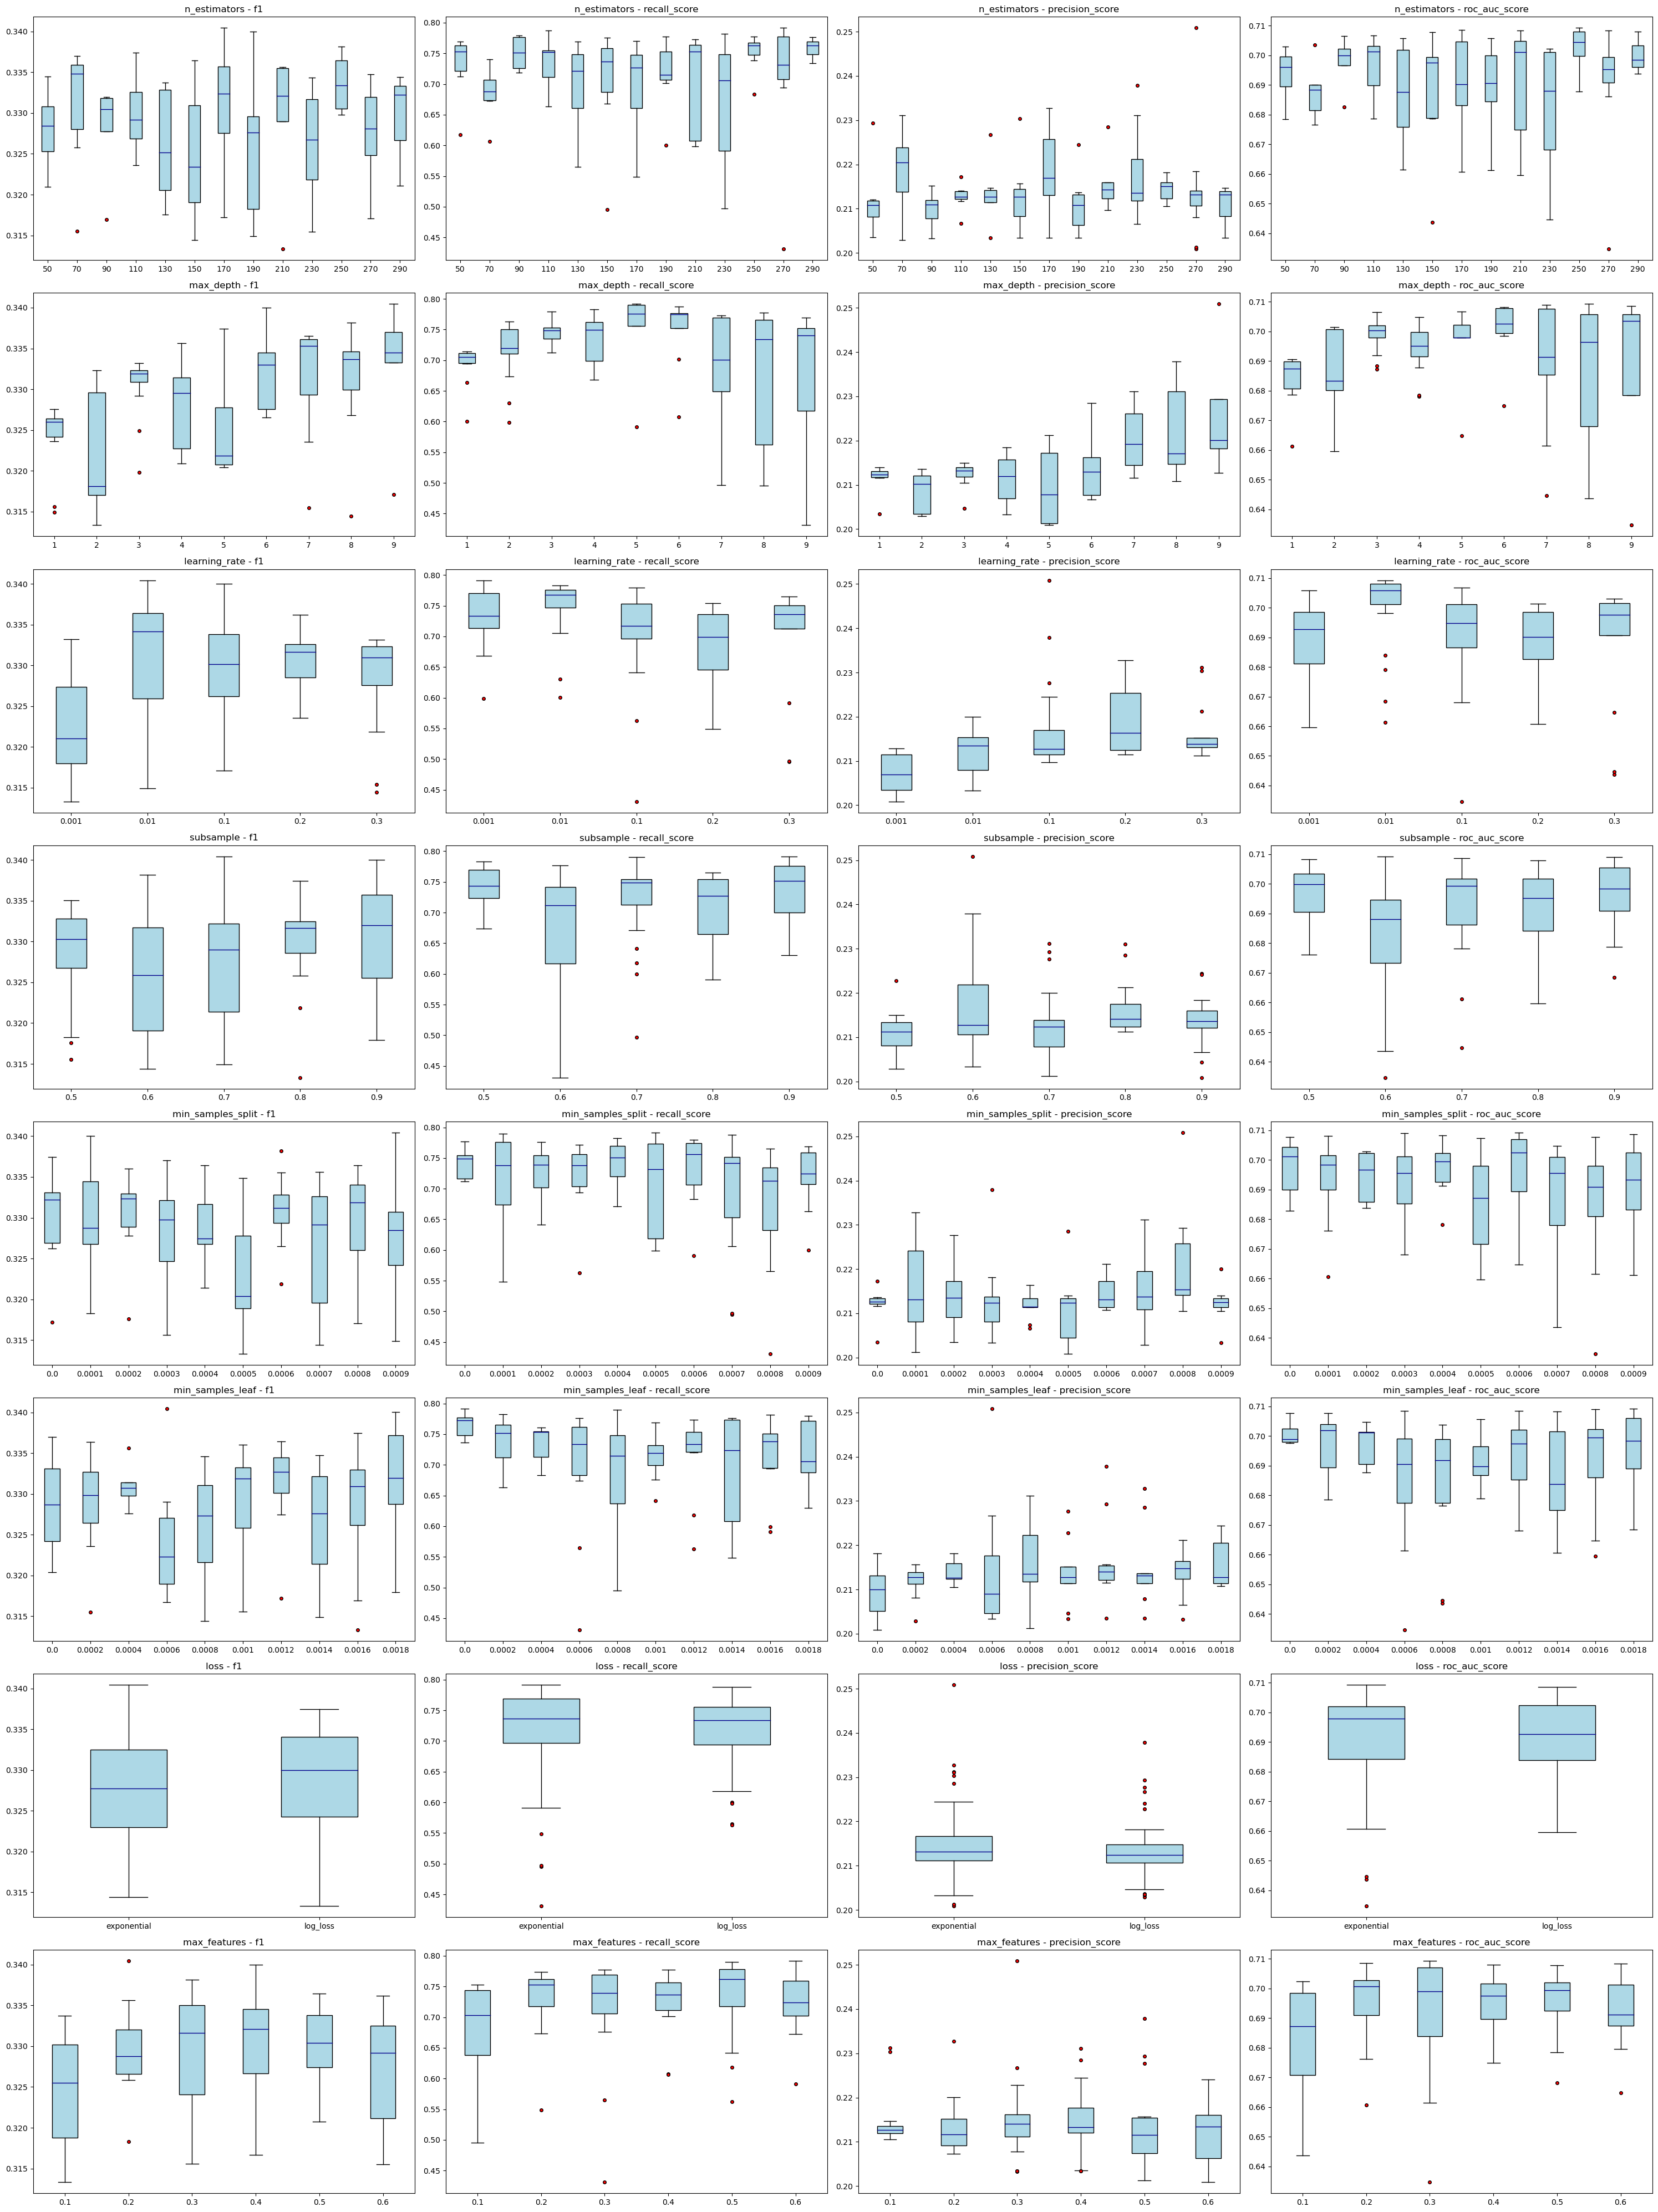

In [223]:
# num_best_models = 90

# best_models = sorted(gb_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

# plot_metrics(gb_result, gb_params, best_models, figsize_param = (30,40))

In [224]:
# best_gb = sorted(gb_result, key = lambda x: -x[1]['f1'][1])[0]
# print('Best Model: {}'.format(GradientBoostingClassifier(**best_gb[0])))
# print('F1: {}'.format(round(best_gb[1]['f1'][1],4)))

Best Model: GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)
F1: 0.3404


#### Adaboost

In [234]:
# from sklearn.tree import DecisionTreeClassifier

# model = AdaBoostClassifier(random_state = random_state, estimator = DecisionTreeClassifier())


# adaboost_params = {
#     'n_estimators': np.arange(50, 200, 10),
#     'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
#     'algorithm': ['SAMME', 'SAMME.R'],
#     'estimator__max_depth': np.arange(1, 10, 1),  # Adjust based on your base estimator
#     'estimator__min_samples_split': np.arange(0.0002, 0.001, 0.0001),  # Adjust based on your base estimator
#     'estimator__min_samples_leaf': np.arange(0.0002, 0.001, 0.0001),  # Adjust based on your base estimator
# }


# adaboost_upsample_params = []
# adaboost_result = []
# for i in tqdm(range(30)):
#     random_params = {}
#     for key, values in adaboost_params.items():
#         random_params[key] = random.choice(values)
        
#     upsample = random.choice([True,False])
#     if upsample == True:
#        upsample_type = random.choice(['simple', 'SMOTE'])
#     else:
#        upsample_type = None
#     adaboost_upsample_params.append([upsample, upsample_type])
#     print(upsample, upsample_type)
#     adaboost_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params, 
#                      scaling = False,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = upsample, 
#                      upsample_type = upsample_type,
#                      cv=5))
   

  0%|                                                    | 0/30 [00:00<?, ?it/s]

False None


  3%|█▍                                          | 1/30 [00:46<22:36, 46.77s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0004000000000000001),
                   learning_rate=0.01, n_estimators=60, random_state=42)
F1 train: 0.064, F1_val: 0.015
False None


  7%|██▉                                         | 2/30 [01:59<28:59, 62.11s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=1, n_estimators=90, random_state=42)
F1 train: 0.990, F1_val: 0.176
True SMOTE


 10%|████▍                                       | 3/30 [03:56<39:16, 87.27s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0004000000000000001),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.776, F1_val: 0.224
False None


 13%|█████▊                                      | 4/30 [05:02<34:05, 78.69s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0007000000000000001),
                   learning_rate=0.5, n_estimators=110, random_state=42)
F1 train: 0.139, F1_val: 0.078
True simple


 17%|███████▎                                    | 5/30 [06:25<33:27, 80.30s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=140, random_state=42)
F1 train: 0.697, F1_val: 0.329
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|████████▊                                   | 6/30 [07:25<29:24, 73.52s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0008000000000000001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.001, n_estimators=100, random_state=42)
F1 train: 0.048, F1_val: 0.005
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0004000000000000001),
                   learning_rate=0.1, n_estimators=100, random_state=42)
F1 train: 0.021, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 27%|███████████▋                                | 8/30 [09:14<24:13, 66.05s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0008000000000000001,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=0.01, n_estimators=140, random_state=42)
F1 train: 0.040, F1_val: 0.003
False None


 30%|█████████████▏                              | 9/30 [10:26<23:42, 67.75s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9,
                                                    min_samples_leaf=0.0009000000000000002,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, n_estimators=80, random_state=42)
F1 train: 0.346, F1_val: 0.047
False None


 33%|██████████████▎                            | 10/30 [12:03<25:37, 76.88s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=7,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0007000000000000001),
                   learning_rate=0.1, n_estimators=140, random_state=42)
F1 train: 0.118, F1_val: 0.050
True SMOTE


 37%|███████████████▍                          | 11/30 [15:25<36:26, 115.06s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0002),
                   learning_rate=0.5, n_estimators=160, random_state=42)
F1 train: 0.945, F1_val: 0.199
True SMOTE


 40%|████████████████▊                         | 12/30 [18:58<43:26, 144.79s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=0.001, n_estimators=170, random_state=42)
F1 train: 0.811, F1_val: 0.212
False None


 43%|██████████████████▏                       | 13/30 [19:33<31:38, 111.69s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.1, n_estimators=80, random_state=42)
F1 train: 0.051, F1_val: 0.021
False None


 47%|████████████████████                       | 14/30 [19:58<22:47, 85.46s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=100, random_state=42)
F1 train: 0.060, F1_val: 0.022
True simple


 50%|█████████████████████                     | 15/30 [22:49<27:46, 111.11s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.001, n_estimators=120, random_state=42)
F1 train: 0.720, F1_val: 0.326
False None


 53%|██████████████████████▍                   | 16/30 [24:21<24:34, 105.35s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=100, random_state=42)
F1 train: 1.000, F1_val: 0.139
True simple


 57%|███████████████████████▊                  | 17/30 [25:49<21:42, 100.16s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0008000000000000001),
                   learning_rate=1, n_estimators=60, random_state=42)
F1 train: 0.865, F1_val: 0.281
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 60%|█████████████████████████▊                 | 18/30 [26:16<15:39, 78.33s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0004000000000000001),
                   learning_rate=0.5, n_estimators=120, random_state=42)
F1 train: 0.046, F1_val: 0.005
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.001, n_estimators=110, random_state=42)
F1 train: 0.028, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.01, n_estimators=90, random_state=42)
F1 train: 0.023, F1_val: 0.000
False None


 70%|██████████████████████████████             | 21/30 [28:20<07:39, 51.04s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0009000000000000002,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.5, n_estimators=80, random_state=42)
F1 train: 0.052, F1_val: 0.014
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0007000000000000001),
                   learning_rate=0.001, n_estimators=100, random_state=42)
F1 train: 0.019, F1_val: 0.000
False None


 77%|████████████████████████████████▉          | 23/30 [30:06<06:09, 52.84s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=9,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0007000000000000001),
                   learning_rate=0.5, n_estimators=70, random_state=42)
F1 train: 0.288, F1_val: 0.121
True simple


 80%|██████████████████████████████████▍        | 24/30 [30:34<04:32, 45.47s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.01, n_estimators=60, random_state=42)
F1 train: 0.672, F1_val: 0.320
True SMOTE


 83%|███████████████████████████████████▊       | 25/30 [32:02<04:50, 58.15s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0009000000000000002,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.001, n_estimators=110, random_state=42)
F1 train: 0.743, F1_val: 0.233
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007000000000000001,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=0.01, n_estimators=100, random_state=42)
F1 train: 0.009, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0009000000000000002,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, n_estimators=110, random_state=42)
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0005),
                   learning_rate=1, random_state=42)
F1 train: 0.001, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 97%|█████████████████████████████████████████▌ | 29/30 [34:53<00:54, 54.02s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7,
                                                    min_samples_leaf=0.0008000000000000001,
                                                    min_samples_split=0.0009000000000000002),
                   learning_rate=0.01, n_estimators=150, random_state=42)
F1 train: 0.052, F1_val: 0.002
True SMOTE


100%|███████████████████████████████████████████| 30/30 [36:19<00:00, 72.66s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0002),
                   learning_rate=0.01, n_estimators=150, random_state=42)
F1 train: 0.809, F1_val: 0.217


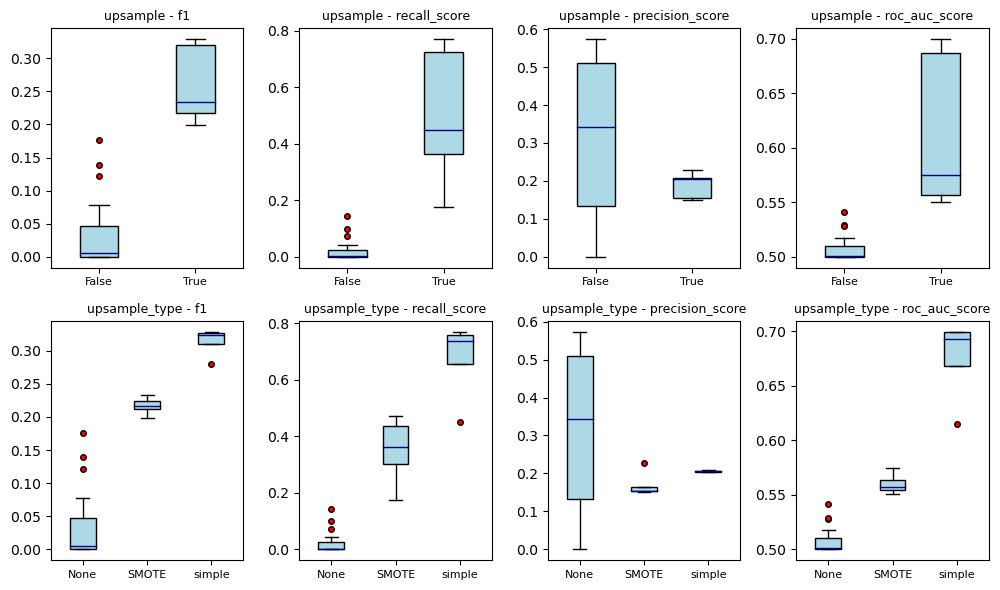

In [235]:
# upsample_list = ['upsample', 'upsample_type']

# fig,ax = plt.subplots(ncols = len(adaboost_result[0][1]), nrows = len(upsample_list), figsize = (10,6))
    
# for m in range(len(adaboost_result[0][1])):
#     for key in range(len(upsample_list)):
#         hyperparam = upsample_list[key]
#         metric = list(adaboost_result[0][1].keys())[m]
#         hyperparam_df = pd.DataFrame(list(zip([i[key] for i in adaboost_upsample_params], [( adaboost_result[i][1][metric][1]) for i in range(len(adaboost_result))])),
#                                      columns = ['hyperparameter', metric]).fillna('None')
#         if hyperparam_df['hyperparameter'].dtype == 'O':
#             hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
#         hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
        
#         ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
#         labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
#         patch_artist=True,
#         widths=0.4,         
#         medianprops=dict(color='darkblue'),
#         boxprops=dict(facecolor='lightblue', edgecolor='black'),
#          whiskerprops=dict(color='black'), 
#          capprops=dict(color='black'),
#         flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
#                           ) 
#         ax[key, m].tick_params(axis='x', labelsize=8)
#         ax[key, m].set_title(hyperparam + ' - ' + metric, fontsize=9)

#         ax[key, m].xaxis.grid(False)
#         ax[key, m].yaxis.grid(False)
# plt.tight_layout()
# plt.savefig('Images/adaboost_upsample_results.png')
# plt.show()

In [236]:
# #simple upsampling is the best approach here

# model = AdaBoostClassifier(random_state = random_state, estimator = DecisionTreeClassifier())


# adaboost_params = {
#     'n_estimators': np.arange(10, 200, 20),
#     'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
#     'algorithm': ['SAMME', 'SAMME.R'],
#     'estimator__max_depth': np.arange(1, 5, 1),  # Adjust based on your base estimator
#     'estimator__min_samples_split': np.arange(0.0001, 0.001, 0.0001),  # Adjust based on your base estimator
#     'estimator__min_samples_leaf': np.arange(0.0001, 0.001, 0.0001),  # Adjust based on your base estimator
# }


# adaboost_result = []
# for i in tqdm(range(100)):
#     random_params = {}
#     for key, values in adaboost_params.items():
#         random_params[key] = random.choice(values)
        
#     adaboost_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params, 
#                      scaling = False,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = True, 
#                      upsample_type = 'simple',
#                      cv=5))

  1%|▍                                          | 1/100 [00:22<36:36, 22.19s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, random_state=42)
F1 train: 0.684, F1_val: 0.318


  2%|▊                                          | 2/100 [00:35<27:48, 17.02s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0004),
                   learning_rate=0.001, random_state=42)
F1 train: 0.661, F1_val: 0.316


  3%|█▎                                         | 3/100 [00:53<28:08, 17.41s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0002),
                   learning_rate=0.5, n_estimators=70, random_state=42)
F1 train: 0.674, F1_val: 0.319


  4%|█▋                                       | 4/100 [02:41<1:24:55, 53.07s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0007),
                   learning_rate=1, n_estimators=170, random_state=42)
F1 train: 0.752, F1_val: 0.318


  5%|██                                       | 5/100 [03:13<1:12:12, 45.61s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=1, n_estimators=70, random_state=42)
F1 train: 0.708, F1_val: 0.327


  6%|██▍                                      | 6/100 [03:44<1:03:41, 40.65s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.01, random_state=42)
F1 train: 0.689, F1_val: 0.315


  7%|██▊                                      | 7/100 [05:11<1:26:37, 55.89s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.706, F1_val: 0.327


  8%|███▎                                     | 8/100 [06:07<1:25:34, 55.81s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, n_estimators=130, random_state=42)
F1 train: 0.698, F1_val: 0.320


  9%|███▋                                     | 9/100 [06:48<1:17:39, 51.20s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, random_state=42)
F1 train: 0.737, F1_val: 0.328


 10%|████                                    | 10/100 [08:48<1:48:43, 72.49s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0001),
                   learning_rate=1, n_estimators=190, random_state=42)
F1 train: 0.758, F1_val: 0.313


 11%|████▍                                   | 11/100 [09:24<1:31:00, 61.36s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=130, random_state=42)
F1 train: 0.676, F1_val: 0.325


 12%|████▊                                   | 12/100 [11:19<1:53:35, 77.45s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.699, F1_val: 0.325


 13%|█████▏                                  | 13/100 [11:22<1:19:53, 55.10s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0008),
                   learning_rate=1, n_estimators=10, random_state=42)
F1 train: 0.678, F1_val: 0.322


 14%|█████▌                                  | 14/100 [12:04<1:13:19, 51.16s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=170, random_state=42)
F1 train: 0.662, F1_val: 0.316


 15%|██████                                  | 15/100 [13:27<1:25:46, 60.55s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.01, n_estimators=190, random_state=42)
F1 train: 0.681, F1_val: 0.317


 16%|██████▍                                 | 16/100 [13:47<1:07:38, 48.31s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=30, random_state=42)
F1 train: 0.718, F1_val: 0.329


 17%|███████▏                                  | 17/100 [13:50<48:17, 34.90s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0008),
                   learning_rate=1, n_estimators=10, random_state=42)
F1 train: 0.678, F1_val: 0.322


 18%|███████▏                                | 18/100 [15:11<1:06:37, 48.75s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.690, F1_val: 0.322


 19%|███████▌                                | 19/100 [15:49<1:01:26, 45.52s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0008),
                   learning_rate=0.01, n_estimators=150, random_state=42)
F1 train: 0.661, F1_val: 0.316


 20%|████████                                | 20/100 [17:12<1:15:28, 56.61s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0008),
                   learning_rate=0.001, n_estimators=190, random_state=42)
F1 train: 0.682, F1_val: 0.311


 21%|████████▍                               | 21/100 [19:29<1:46:30, 80.89s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.792, F1_val: 0.317


 22%|████████▊                               | 22/100 [21:31<2:01:10, 93.21s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0004),
                   learning_rate=1, n_estimators=150, random_state=42)
F1 train: 0.799, F1_val: 0.299


 23%|█████████▏                              | 23/100 [21:46<1:29:20, 69.61s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0002),
                   learning_rate=0.5, random_state=42)
F1 train: 0.678, F1_val: 0.328


 24%|█████████▌                              | 24/100 [22:27<1:17:22, 61.09s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, random_state=42)
F1 train: 0.737, F1_val: 0.328


 25%|██████████                              | 25/100 [24:09<1:31:39, 73.32s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0002),
                   learning_rate=1, n_estimators=170, random_state=42)
F1 train: 0.699, F1_val: 0.327


 26%|██████████▍                             | 26/100 [24:51<1:18:47, 63.89s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.677, F1_val: 0.321


 27%|██████████▊                             | 27/100 [25:36<1:10:52, 58.25s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0007),
                   learning_rate=0.01, n_estimators=70, random_state=42)
F1 train: 0.691, F1_val: 0.322


 28%|███████████▊                              | 28/100 [25:56<56:09, 46.79s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=70, random_state=42)
F1 train: 0.679, F1_val: 0.326


 29%|████████████▏                             | 29/100 [26:03<41:19, 34.93s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=10, random_state=42)
F1 train: 0.711, F1_val: 0.326


 30%|████████████                            | 30/100 [28:05<1:11:17, 61.10s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0004),
                   learning_rate=1, n_estimators=150, random_state=42)
F1 train: 0.798, F1_val: 0.304


 31%|████████████▍                           | 31/100 [29:13<1:12:24, 62.96s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.01, n_estimators=110, random_state=42)
F1 train: 0.694, F1_val: 0.317


 32%|█████████████▍                            | 32/100 [29:35<57:27, 50.70s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, random_state=42)
F1 train: 0.684, F1_val: 0.318


 33%|█████████████▊                            | 33/100 [29:38<40:52, 36.60s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0008),
                   learning_rate=0.1, n_estimators=10, random_state=42)
F1 train: 0.661, F1_val: 0.316


 34%|█████████████▌                          | 34/100 [31:35<1:06:48, 60.73s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0008),
                   learning_rate=0.001, n_estimators=150, random_state=42)
F1 train: 0.704, F1_val: 0.316


 35%|██████████████                          | 35/100 [32:44<1:08:23, 63.13s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0007),
                   learning_rate=0.1, n_estimators=150, random_state=42)
F1 train: 0.703, F1_val: 0.325


 36%|███████████████                           | 36/100 [33:09<55:08, 51.69s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0002),
                   learning_rate=0.1, n_estimators=30, random_state=42)
F1 train: 0.714, F1_val: 0.331


 37%|██████████████▊                         | 37/100 [34:28<1:02:53, 59.90s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0005),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.686, F1_val: 0.315


 38%|███████████████▏                        | 38/100 [36:40<1:24:18, 81.60s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.001, n_estimators=170, random_state=42)
F1 train: 0.704, F1_val: 0.316


 39%|███████████████▌                        | 39/100 [36:48<1:00:17, 59.30s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.01, n_estimators=10, random_state=42)
F1 train: 0.691, F1_val: 0.317


 40%|████████████████▊                         | 40/100 [37:43<57:59, 57.99s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.001, n_estimators=90, random_state=42)
F1 train: 0.688, F1_val: 0.316


 41%|████████████████▍                       | 41/100 [38:55<1:01:17, 62.34s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.1, n_estimators=170, random_state=42)
F1 train: 0.690, F1_val: 0.321


 42%|█████████████████▋                        | 42/100 [39:17<48:32, 50.22s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.5, random_state=42)
F1 train: 0.697, F1_val: 0.319


 43%|█████████████████▏                      | 43/100 [41:18<1:07:45, 71.33s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.722, F1_val: 0.333


 44%|█████████████████▌                      | 44/100 [42:10<1:01:17, 65.68s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.1, n_estimators=190, random_state=42)
F1 train: 0.677, F1_val: 0.326


 45%|██████████████████▉                       | 45/100 [42:34<48:45, 53.20s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=1, n_estimators=30, random_state=42)
F1 train: 0.704, F1_val: 0.325


 46%|██████████████████▍                     | 46/100 [44:16<1:00:56, 67.71s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.704, F1_val: 0.316


 47%|███████████████████▋                      | 47/100 [44:46<49:56, 56.55s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=70, random_state=42)
F1 train: 0.685, F1_val: 0.318


 48%|████████████████████▏                     | 48/100 [45:33<46:25, 53.57s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.5, n_estimators=190, random_state=42)
F1 train: 0.673, F1_val: 0.323


 49%|████████████████████▌                     | 49/100 [46:43<49:52, 58.67s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.1, n_estimators=90, random_state=42)
F1 train: 0.710, F1_val: 0.328


 50%|█████████████████████                     | 50/100 [47:16<42:18, 50.77s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0002),
                   learning_rate=1, random_state=42)
F1 train: 0.720, F1_val: 0.327


 51%|█████████████████████▍                    | 51/100 [49:09<56:50, 69.59s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=1, n_estimators=190, random_state=42)
F1 train: 0.698, F1_val: 0.328


 52%|█████████████████████▊                    | 52/100 [50:00<51:13, 64.02s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.001, n_estimators=110, random_state=42)
F1 train: 0.676, F1_val: 0.316


 53%|██████████████████████▎                   | 53/100 [50:24<40:35, 51.82s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0002),
                   learning_rate=0.001, n_estimators=90, random_state=42)
F1 train: 0.661, F1_val: 0.316


 54%|██████████████████████▋                   | 54/100 [51:37<44:41, 58.30s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0005),
                   learning_rate=0.001, n_estimators=170, random_state=42)
F1 train: 0.682, F1_val: 0.311


 55%|███████████████████████                   | 55/100 [52:55<48:12, 64.27s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0005),
                   learning_rate=1, n_estimators=130, random_state=42)
F1 train: 0.699, F1_val: 0.327


 56%|███████████████████████▌                  | 56/100 [54:07<48:51, 66.63s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.698, F1_val: 0.321


 57%|███████████████████████▉                  | 57/100 [55:16<48:17, 67.37s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0004),
                   learning_rate=0.01, n_estimators=150, random_state=42)
F1 train: 0.674, F1_val: 0.321


 58%|████████████████████████▎                 | 58/100 [55:53<40:37, 58.03s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0007),
                   learning_rate=0.1, n_estimators=130, random_state=42)
F1 train: 0.676, F1_val: 0.325


 59%|████████████████████████▊                 | 59/100 [57:38<49:25, 72.34s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=130, random_state=42)
F1 train: 0.770, F1_val: 0.323


 60%|█████████████████████████▏                | 60/100 [59:26<55:19, 82.99s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, n_estimators=170, random_state=42)
F1 train: 0.721, F1_val: 0.332


 61%|█████████████████████████▌                | 61/100 [59:32<38:46, 59.66s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=1, n_estimators=10, random_state=42)
F1 train: 0.684, F1_val: 0.310


 62%|████████████████████████▊               | 62/100 [1:00:03<32:20, 51.06s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0002),
                   learning_rate=0.01, random_state=42)
F1 train: 0.689, F1_val: 0.315


 63%|█████████████████████████▏              | 63/100 [1:01:48<41:29, 67.27s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0005),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.707, F1_val: 0.316


 64%|█████████████████████████▌              | 64/100 [1:03:44<49:15, 82.08s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0004),
                   learning_rate=0.001, n_estimators=150, random_state=42)
F1 train: 0.704, F1_val: 0.316


 65%|██████████████████████████              | 65/100 [1:04:26<40:47, 69.93s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.677, F1_val: 0.321


 66%|██████████████████████████▍             | 66/100 [1:04:40<30:12, 53.30s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0004),
                   learning_rate=1, n_estimators=30, random_state=42)
F1 train: 0.706, F1_val: 0.324


 67%|██████████████████████████▊             | 67/100 [1:06:52<42:12, 76.75s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=170, random_state=42)
F1 train: 0.711, F1_val: 0.330


 68%|███████████████████████████▏            | 68/100 [1:08:21<42:52, 80.39s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.001, n_estimators=110, random_state=42)
F1 train: 0.707, F1_val: 0.316


 69%|███████████████████████████▌            | 69/100 [1:08:26<29:55, 57.92s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0005),
                   learning_rate=1, n_estimators=10, random_state=42)
F1 train: 0.696, F1_val: 0.317


 70%|████████████████████████████            | 70/100 [1:09:46<32:18, 64.61s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=190, random_state=42)
F1 train: 0.698, F1_val: 0.322


 71%|████████████████████████████▍           | 71/100 [1:10:05<24:36, 50.93s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0002),
                   learning_rate=0.01, n_estimators=30, random_state=42)
F1 train: 0.686, F1_val: 0.315


 72%|████████████████████████████▊           | 72/100 [1:10:47<22:27, 48.12s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0001),
                   learning_rate=0.5, n_estimators=90, random_state=42)
F1 train: 0.713, F1_val: 0.332


 73%|█████████████████████████████▏          | 73/100 [1:12:10<26:19, 58.51s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.001, n_estimators=130, random_state=42)
F1 train: 0.694, F1_val: 0.317


 74%|█████████████████████████████▌          | 74/100 [1:12:42<21:56, 50.65s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0004),
                   learning_rate=1, n_estimators=130, random_state=42)
F1 train: 0.684, F1_val: 0.319


 75%|██████████████████████████████          | 75/100 [1:13:21<19:36, 47.04s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0005),
                   learning_rate=1, n_estimators=90, random_state=42)
F1 train: 0.686, F1_val: 0.314


 76%|██████████████████████████████▍         | 76/100 [1:14:07<18:46, 46.94s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0008),
                   learning_rate=1, n_estimators=170, random_state=42)
F1 train: 0.683, F1_val: 0.326


 77%|██████████████████████████████▊         | 77/100 [1:14:26<14:46, 38.55s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0004),
                   learning_rate=0.1, n_estimators=30, random_state=42)
F1 train: 0.703, F1_val: 0.319


 78%|███████████████████████████████▏        | 78/100 [1:14:35<10:48, 29.46s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.0007),
                   learning_rate=1, n_estimators=30, random_state=42)
F1 train: 0.676, F1_val: 0.318


 79%|███████████████████████████████▌        | 79/100 [1:15:16<11:35, 33.12s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0001),
                   learning_rate=1, n_estimators=170, random_state=42)
F1 train: 0.678, F1_val: 0.321


 80%|████████████████████████████████        | 80/100 [1:16:14<13:28, 40.44s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0004),
                   learning_rate=0.01, n_estimators=90, random_state=42)
F1 train: 0.691, F1_val: 0.321


 81%|████████████████████████████████▍       | 81/100 [1:16:22<09:47, 30.92s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0001),
                   learning_rate=0.5, n_estimators=10, random_state=42)
F1 train: 0.709, F1_val: 0.325


 82%|████████████████████████████████▊       | 82/100 [1:16:41<08:09, 27.18s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.01, n_estimators=70, random_state=42)
F1 train: 0.661, F1_val: 0.316


 83%|█████████████████████████████████▏      | 83/100 [1:17:38<10:16, 36.25s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, n_estimators=90, random_state=42)
F1 train: 0.731, F1_val: 0.329


 84%|█████████████████████████████████▌      | 84/100 [1:17:53<07:55, 29.72s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0006000000000000001),
                   learning_rate=1, random_state=42)
F1 train: 0.679, F1_val: 0.326


 85%|██████████████████████████████████      | 85/100 [1:19:01<10:20, 41.34s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0002,
                                                    min_samples_split=0.0001),
                   learning_rate=1, n_estimators=150, random_state=42)
F1 train: 0.719, F1_val: 0.329


 86%|██████████████████████████████████▍     | 86/100 [1:20:12<11:41, 50.12s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0002),
                   learning_rate=0.1, n_estimators=90, random_state=42)
F1 train: 0.710, F1_val: 0.328


 87%|██████████████████████████████████▊     | 87/100 [1:21:30<12:40, 58.51s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0005),
                   learning_rate=0.1, n_estimators=170, random_state=42)
F1 train: 0.704, F1_val: 0.326


 88%|███████████████████████████████████▏    | 88/100 [1:21:56<09:44, 48.68s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0001),
                   learning_rate=0.001, n_estimators=90, random_state=42)
F1 train: 0.661, F1_val: 0.316


 89%|███████████████████████████████████▌    | 89/100 [1:22:03<06:38, 36.25s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.00030000000000000003,
                                                    min_samples_split=0.0005),
                   learning_rate=0.5, n_estimators=10, random_state=42)
F1 train: 0.711, F1_val: 0.326


 90%|████████████████████████████████████    | 90/100 [1:22:45<06:18, 37.89s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0001),
                   learning_rate=0.01, n_estimators=90, random_state=42)
F1 train: 0.672, F1_val: 0.320


 91%|████████████████████████████████████▍   | 91/100 [1:23:02<04:46, 31.82s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=1, n_estimators=70, random_state=42)
F1 train: 0.684, F1_val: 0.319


 92%|████████████████████████████████████▊   | 92/100 [1:24:58<07:36, 57.11s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, n_estimators=150, random_state=42)
F1 train: 0.710, F1_val: 0.331


 93%|█████████████████████████████████████▏  | 93/100 [1:25:36<05:58, 51.16s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1,
                                                    min_samples_leaf=0.0009000000000000001,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.1, n_estimators=150, random_state=42)
F1 train: 0.662, F1_val: 0.316


 94%|█████████████████████████████████████▌  | 94/100 [1:26:08<04:33, 45.52s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0005,
                                                    min_samples_split=0.0007),
                   learning_rate=0.5, random_state=42)
F1 train: 0.722, F1_val: 0.331


 95%|██████████████████████████████████████  | 95/100 [1:27:07<04:08, 49.68s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0007),
                   learning_rate=1, n_estimators=130, random_state=42)
F1 train: 0.715, F1_val: 0.327


 96%|██████████████████████████████████████▍ | 96/100 [1:29:04<04:39, 69.78s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0007,
                                                    min_samples_split=0.0001),
                   learning_rate=0.1, n_estimators=150, random_state=42)
F1 train: 0.710, F1_val: 0.328


 97%|██████████████████████████████████████▊ | 97/100 [1:30:52<04:03, 81.29s/it]

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.01, n_estimators=170, random_state=42)
F1 train: 0.694, F1_val: 0.322


 98%|███████████████████████████████████████▏| 98/100 [1:31:16<02:08, 64.14s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0006000000000000001,
                                                    min_samples_split=0.0008),
                   learning_rate=0.5, n_estimators=30, random_state=42)
F1 train: 0.709, F1_val: 0.329


 99%|███████████████████████████████████████▌| 99/100 [1:32:39<01:09, 69.57s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    min_samples_leaf=0.0008,
                                                    min_samples_split=0.00030000000000000003),
                   learning_rate=0.001, n_estimators=190, random_state=42)
F1 train: 0.682, F1_val: 0.311


100%|███████████████████████████████████████| 100/100 [1:33:18<00:00, 55.99s/it]

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_leaf=0.0004,
                                                    min_samples_split=0.0009000000000000001),
                   learning_rate=0.5, random_state=42)
F1 train: 0.709, F1_val: 0.329


In [237]:
# with open('Learning_results/adaboost_model_selection.pkl', 'wb') as file:
#     pickle.dump(adaboost_result, file)

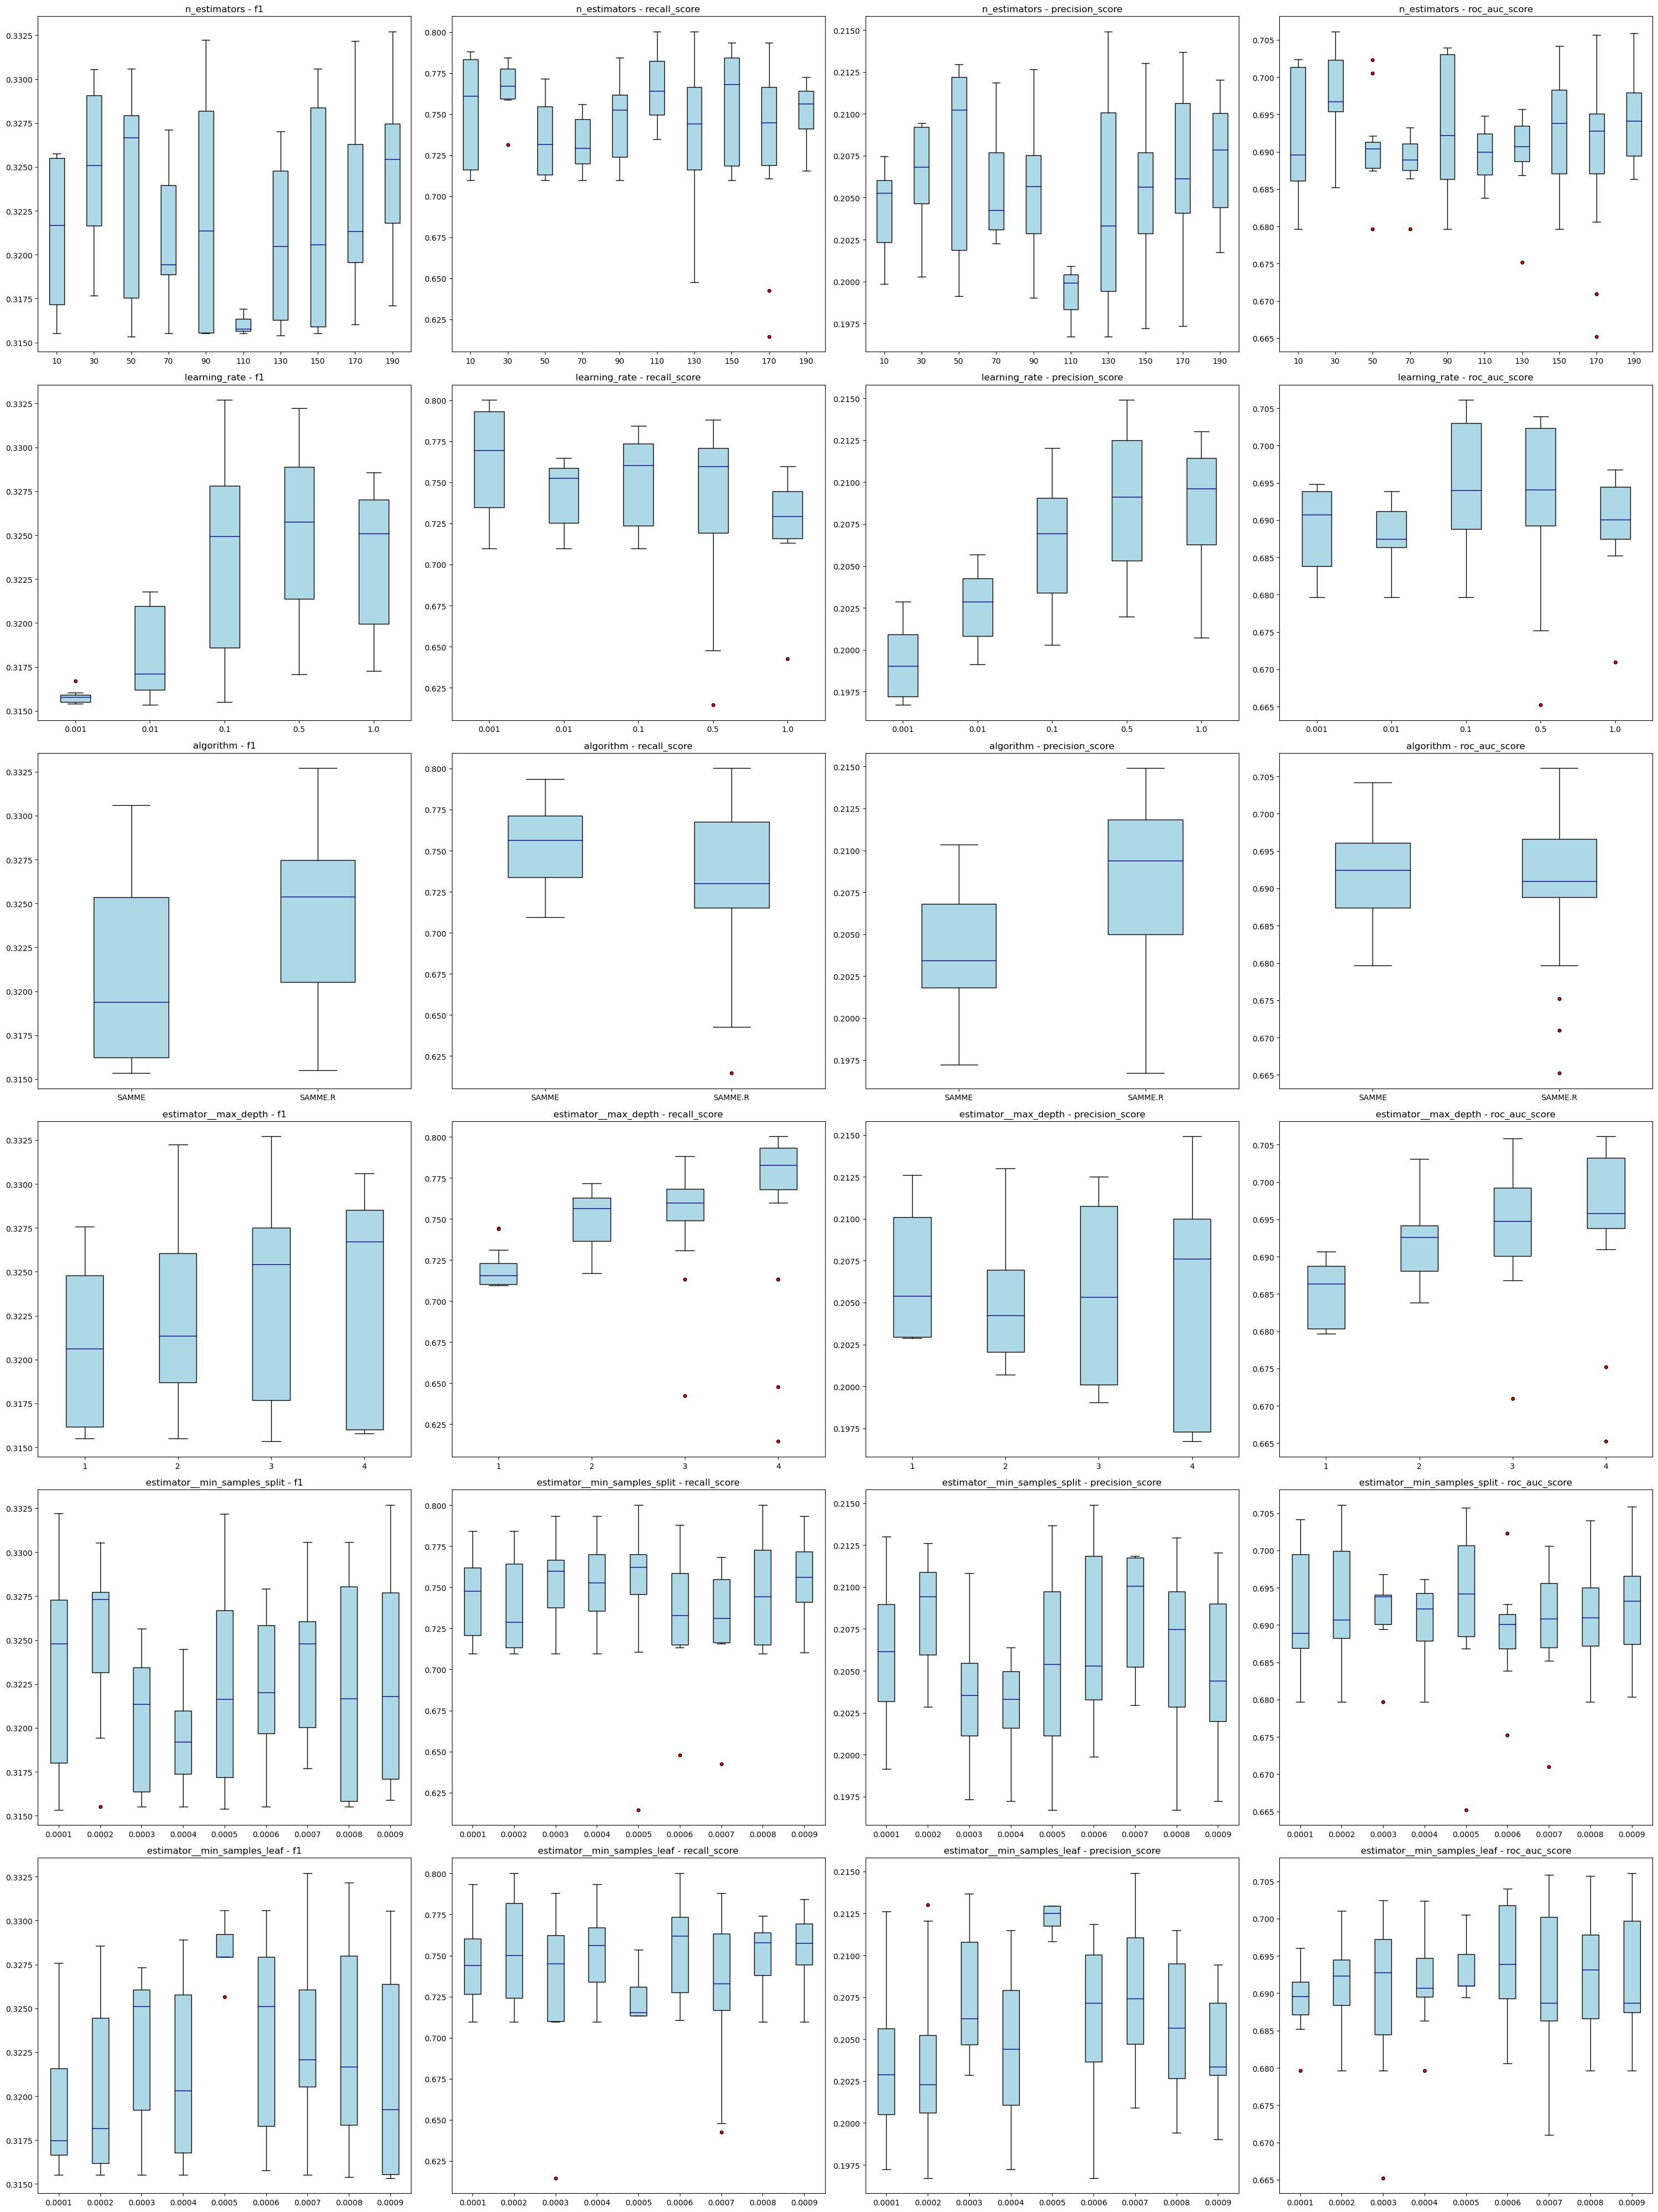

In [238]:
# num_best_models = 90

# best_models = sorted(adaboost_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

# plot_metrics(adaboost_result, adaboost_params, best_models, figsize_param = (30,40))

In [239]:
# best_adaboost = sorted(adaboost_result, key = lambda x: -x[1]['f1'][1])[0]
# print('Best Model: {}'.format(best_adaboost[0]))
# print('F1: {}'.format(round(best_adaboost[1]['f1'][1],4)))

Best Model: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 0.0007, 'estimator__min_samples_split': 0.0009000000000000001, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.0004,
                       min_samples_split=0.0009000000000000001), 'learning_rate': 0.1, 'n_estimators': 190, 'random_state': 42}
F1: 0.3327


#### SGD

In [30]:
# from sklearn.linear_model import SGDClassifier

# ###logloss optimization

# model = SGDClassifier(max_iter=2000, tol=1e-4, class_weight = 'balanced')


# sgd_log_params = {
#     'alpha': np.arange(0.0001, 0.0011, 0.0001),
#     'penalty': ['l2', 'l1'],
#     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#     'eta0': [0.001, 0.01, 0.1, 0.5, 1.0],
#     'loss': ['log_loss'],
#     'epsilon': [0.01, 0.1, 0.2],
#     'power_t': [0.1, 0.5, 1.0],
# }

# sgd_log_result = []
# for i in tqdm(range(100)):
#     random_params = {}
#     for key, values in sgd_log_params.items():
#         random_params[key] = random.choice(values)
        
#     sgd_log_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params, 
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = False, 
#                      cv=5))

  1%|▍                                          | 1/100 [00:12<20:07, 12.20s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=0.1,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.313, F1_val: 0.316


  2%|▊                                          | 2/100 [00:22<18:09, 11.11s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', eta0=0.1, loss='log_loss',
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.319, F1_val: 0.330


  3%|█▎                                         | 3/100 [00:24<11:01,  6.82s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.217, F1_val: 0.192


  4%|█▋                                         | 4/100 [00:29<09:42,  6.07s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.303, F1_val: 0.299


  5%|██▏                                        | 5/100 [00:39<11:56,  7.54s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.314, F1_val: 0.316


  6%|██▌                                        | 6/100 [00:49<13:03,  8.34s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.2, eta0=0.5,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.324, F1_val: 0.333


  7%|███                                        | 7/100 [00:57<12:54,  8.33s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.322, F1_val: 0.325


  8%|███▍                                       | 8/100 [01:07<13:19,  8.69s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.01, eta0=0.001,
              loss='log_loss', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.226, F1_val: 0.221


  9%|███▊                                       | 9/100 [01:16<13:27,  8.88s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced', eta0=1.0,
              loss='log_loss', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.239, F1_val: 0.239


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.5, learning_rate='constant', loss='log_loss',
              max_iter=2000, tol=0.0001)
F1 train: 0.121, F1_val: 0.121


 11%|████▌                                     | 11/100 [01:27<11:07,  7.50s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.2, eta0=0.01,
              loss='log_loss', max_iter=2000, tol=0.0001)
F1 train: 0.291, F1_val: 0.286


 12%|█████                                     | 12/100 [01:29<08:27,  5.77s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.218, F1_val: 0.212


 13%|█████▍                                    | 13/100 [01:38<09:51,  6.80s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.1, loss='log_loss',
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.281, F1_val: 0.286


 14%|█████▉                                    | 14/100 [01:50<12:11,  8.50s/it]

SGDClassifier(class_weight='balanced', eta0=1.0, loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.214, F1_val: 0.211


 15%|██████▎                                   | 15/100 [01:53<09:35,  6.77s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', eta0=0.5,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.250, F1_val: 0.244


 16%|██████▋                                   | 16/100 [02:00<09:39,  6.90s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.2, eta0=0.001,
              loss='log_loss', max_iter=2000, tol=0.0001)
F1 train: 0.258, F1_val: 0.241


 17%|███████▏                                  | 17/100 [02:02<07:22,  5.33s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.01, learning_rate='constant',
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.215, F1_val: 0.195


 18%|███████▌                                  | 18/100 [02:04<05:49,  4.27s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.156, F1_val: 0.115


 19%|███████▉                                  | 19/100 [02:12<07:31,  5.57s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.316, F1_val: 0.317


 20%|████████▍                                 | 20/100 [02:21<08:47,  6.59s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.1,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.315, F1_val: 0.319


 21%|████████▊                                 | 21/100 [02:24<07:18,  5.55s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=0.01,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.224, F1_val: 0.199


 22%|█████████▏                                | 22/100 [02:28<06:24,  4.93s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.1, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.189, F1_val: 0.178


 23%|█████████▋                                | 23/100 [02:36<07:34,  5.91s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.5,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.321, F1_val: 0.330


 24%|██████████                                | 24/100 [02:40<06:44,  5.32s/it]

SGDClassifier(class_weight='balanced', eta0=0.1, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.307, F1_val: 0.298


 25%|██████████▌                               | 25/100 [02:42<05:18,  4.24s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.243, F1_val: 0.218


 26%|██████████▉                               | 26/100 [02:50<06:52,  5.57s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.5,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.286, F1_val: 0.292


 27%|███████████▎                              | 27/100 [02:54<06:07,  5.03s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.306, F1_val: 0.303


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 28%|███████████▊                              | 28/100 [02:56<04:49,  4.02s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', eta0=0.1,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.125, F1_val: 0.123


 29%|████████████▏                             | 29/100 [03:08<07:31,  6.36s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.1, loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.318, F1_val: 0.327


 30%|████████████▌                             | 30/100 [03:09<05:45,  4.93s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.001, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.201, F1_val: 0.201


 31%|█████████████                             | 31/100 [03:15<05:51,  5.10s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced', eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.269, F1_val: 0.267


 32%|█████████████▍                            | 32/100 [03:17<04:40,  4.13s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.262, F1_val: 0.232


 33%|█████████████▊                            | 33/100 [03:18<03:47,  3.40s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=0.1, learning_rate='constant', loss='log_loss',
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.249, F1_val: 0.241


 34%|██████████████▎                           | 34/100 [03:25<04:51,  4.42s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=0.1, loss='log_loss', max_iter=2000, power_t=1.0,
              tol=0.0001)
F1 train: 0.254, F1_val: 0.247


 35%|██████████████▋                           | 35/100 [03:27<03:52,  3.58s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced', eta0=1.0,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.208, F1_val: 0.188


 36%|███████████████                           | 36/100 [03:37<05:59,  5.62s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.5,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.312, F1_val: 0.312


 37%|███████████████▌                          | 37/100 [03:47<07:08,  6.81s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.2, eta0=0.001, loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.230, F1_val: 0.228


 38%|███████████████▉                          | 38/100 [03:48<05:25,  5.25s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.217, F1_val: 0.212


 39%|████████████████▍                         | 39/100 [03:59<06:53,  6.78s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced', eta0=0.5,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.298, F1_val: 0.298


 40%|████████████████▊                         | 40/100 [04:03<05:55,  5.93s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.238, F1_val: 0.237


 41%|█████████████████▏                        | 41/100 [04:05<04:43,  4.80s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.001, learning_rate='constant',
              loss='log_loss', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.282, F1_val: 0.267


 42%|█████████████████▋                        | 42/100 [04:12<05:24,  5.59s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.246, F1_val: 0.246


 43%|██████████████████                        | 43/100 [04:20<06:00,  6.32s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.320, F1_val: 0.321


 44%|██████████████████▍                       | 44/100 [04:22<04:35,  4.92s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.239, F1_val: 0.219


 45%|██████████████████▉                       | 45/100 [04:30<05:28,  5.98s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.292, F1_val: 0.287


 46%|███████████████████▎                      | 46/100 [04:32<04:17,  4.76s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=0.1,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.238, F1_val: 0.237


 47%|███████████████████▋                      | 47/100 [04:41<05:18,  6.02s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.01, eta0=0.5, learning_rate='adaptive', loss='log_loss',
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.308, F1_val: 0.309


 48%|████████████████████▏                     | 48/100 [04:49<05:35,  6.45s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.01, learning_rate='adaptive',
              loss='log_loss', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.320, F1_val: 0.320


 49%|████████████████████▌                     | 49/100 [04:57<05:52,  6.90s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.001,
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.212, F1_val: 0.209


 50%|█████████████████████                     | 50/100 [04:59<04:43,  5.68s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', eta0=0.01,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.225, F1_val: 0.217


 51%|█████████████████████▍                    | 51/100 [05:09<05:35,  6.85s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.1,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.319, F1_val: 0.322


 52%|█████████████████████▊                    | 52/100 [05:13<04:40,  5.84s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.238, F1_val: 0.222


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.122, F1_val: 0.122


 54%|██████████████████████▋                   | 54/100 [05:24<04:49,  6.28s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.01, loss='log_loss',
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.273, F1_val: 0.281


 55%|███████████████████████                   | 55/100 [05:33<05:10,  6.90s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.295, F1_val: 0.294


 56%|███████████████████████▌                  | 56/100 [05:40<05:13,  7.13s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.319, F1_val: 0.319


 57%|███████████████████████▉                  | 57/100 [05:48<05:17,  7.40s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.316, F1_val: 0.317


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.121, F1_val: 0.121


 59%|████████████████████████▊                 | 59/100 [05:59<04:34,  6.68s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=1.0, learning_rate='adaptive', loss='log_loss',
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.291, F1_val: 0.289


 60%|█████████████████████████▏                | 60/100 [06:03<03:47,  5.69s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced', eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.249, F1_val: 0.241


 61%|█████████████████████████▌                | 61/100 [06:04<02:54,  4.48s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.1, learning_rate='constant', loss='log_loss',
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.242, F1_val: 0.226


 62%|██████████████████████████                | 62/100 [06:07<02:31,  3.99s/it]

SGDClassifier(class_weight='balanced', eta0=0.001, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, tol=0.0001)
F1 train: 0.269, F1_val: 0.262


 63%|██████████████████████████▍               | 63/100 [06:09<02:02,  3.32s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.001, learning_rate='constant',
              loss='log_loss', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.196, F1_val: 0.163


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.133, F1_val: 0.130


 65%|███████████████████████████▎              | 65/100 [06:15<01:58,  3.37s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', eta0=0.001,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.302, F1_val: 0.299


 66%|███████████████████████████▋              | 66/100 [06:27<03:19,  5.86s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=0.1,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.313, F1_val: 0.315


 67%|████████████████████████████▏             | 67/100 [06:37<03:53,  7.07s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.301, F1_val: 0.302


 68%|████████████████████████████▌             | 68/100 [06:40<03:10,  5.94s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.267, F1_val: 0.263


 69%|████████████████████████████▉             | 69/100 [06:42<02:24,  4.66s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.001, learning_rate='constant',
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.220, F1_val: 0.171


 70%|█████████████████████████████▍            | 70/100 [06:53<03:17,  6.58s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', eta0=1.0, loss='log_loss',
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.297, F1_val: 0.305


 71%|█████████████████████████████▊            | 71/100 [06:54<02:27,  5.10s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.239, F1_val: 0.224


 72%|██████████████████████████████▏           | 72/100 [06:56<01:55,  4.11s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', eta0=0.001,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.242, F1_val: 0.221


 73%|██████████████████████████████▋           | 73/100 [07:03<02:16,  5.07s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', eta0=0.001,
              loss='log_loss', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.264, F1_val: 0.242


 74%|███████████████████████████████           | 74/100 [07:06<01:51,  4.28s/it]

SGDClassifier(class_weight='balanced', eta0=0.001, learning_rate='constant',
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.280, F1_val: 0.266


 75%|███████████████████████████████▌          | 75/100 [07:08<01:27,  3.51s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.225, F1_val: 0.217


 76%|███████████████████████████████▉          | 76/100 [07:16<02:01,  5.06s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.01,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.318, F1_val: 0.320


 77%|████████████████████████████████▎         | 77/100 [07:18<01:32,  4.03s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.218, F1_val: 0.214


 78%|████████████████████████████████▊         | 78/100 [07:25<01:48,  4.92s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=1.0, loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.252, F1_val: 0.242


 79%|█████████████████████████████████▏        | 79/100 [07:35<02:15,  6.46s/it]

SGDClassifier(alpha=0.0007, class_weight='balanced', epsilon=0.01, eta0=0.001,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.303, F1_val: 0.314


 80%|█████████████████████████████████▌        | 80/100 [07:38<01:49,  5.46s/it]

SGDClassifier(alpha=0.00030000000000000003, class_weight='balanced',
              epsilon=0.2, eta0=0.01, learning_rate='invscaling',
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.273, F1_val: 0.257


 81%|██████████████████████████████████        | 81/100 [07:48<02:10,  6.88s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=1.0, loss='log_loss', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.300, F1_val: 0.310


 82%|██████████████████████████████████▍       | 82/100 [08:00<02:31,  8.42s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.5, loss='log_loss',
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.268, F1_val: 0.267


 83%|██████████████████████████████████▊       | 83/100 [08:02<01:48,  6.39s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.01,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.232, F1_val: 0.214


 84%|███████████████████████████████████▎      | 84/100 [08:06<01:30,  5.67s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.001, learning_rate='adaptive',
              loss='log_loss', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.305, F1_val: 0.302


 85%|███████████████████████████████████▋      | 85/100 [08:10<01:16,  5.12s/it]

SGDClassifier(alpha=0.0002, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.307, F1_val: 0.302


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 86%|████████████████████████████████████      | 86/100 [08:11<00:56,  4.06s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.1, learning_rate='constant', loss='log_loss',
              max_iter=2000, tol=0.0001)
F1 train: 0.097, F1_val: 0.085


 87%|████████████████████████████████████▌     | 87/100 [08:18<01:04,  4.96s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', eta0=0.01,
              loss='log_loss', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.244, F1_val: 0.229


 88%|████████████████████████████████████▉     | 88/100 [08:27<01:11,  5.96s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced', eta0=0.001,
              loss='log_loss', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.266, F1_val: 0.258


 89%|█████████████████████████████████████▍    | 89/100 [08:29<00:51,  4.72s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='constant', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.175, F1_val: 0.150


 90%|█████████████████████████████████████▊    | 90/100 [08:32<00:44,  4.44s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', eta0=1.0,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.237, F1_val: 0.229


 91%|██████████████████████████████████████▏   | 91/100 [08:41<00:52,  5.85s/it]

SGDClassifier(alpha=0.0009000000000000001, class_weight='balanced', epsilon=0.2,
              eta0=1.0, loss='log_loss', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.310, F1_val: 0.318


 92%|██████████████████████████████████████▋   | 92/100 [08:50<00:54,  6.76s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.304, F1_val: 0.307


 93%|███████████████████████████████████████   | 93/100 [08:52<00:36,  5.21s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.201, F1_val: 0.201


 94%|███████████████████████████████████████▍  | 94/100 [09:01<00:38,  6.34s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.001,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.292, F1_val: 0.299


 95%|███████████████████████████████████████▉  | 95/100 [09:04<00:26,  5.28s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.278, F1_val: 0.250


 96%|████████████████████████████████████████▎ | 96/100 [09:05<00:16,  4.21s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', eta0=0.01,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.214, F1_val: 0.213


 97%|████████████████████████████████████████▋ | 97/100 [09:13<00:15,  5.28s/it]

SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='adaptive', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.291, F1_val: 0.284


 98%|█████████████████████████████████████████▏| 98/100 [09:23<00:13,  6.63s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced', eta0=0.01,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.308, F1_val: 0.313


 99%|█████████████████████████████████████████▌| 99/100 [09:31<00:06,  6.96s/it]

SGDClassifier(alpha=0.0006000000000000001, class_weight='balanced',
              epsilon=0.01, eta0=0.5, loss='log_loss', max_iter=2000,
              tol=0.0001)
F1 train: 0.261, F1_val: 0.245


100%|█████████████████████████████████████████| 100/100 [09:33<00:00,  5.74s/it]

SGDClassifier(alpha=0.0004, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='invscaling', loss='log_loss', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.246, F1_val: 0.242


In [31]:
# with open('Learning_results/sgd_log_model_selection.pkl', 'wb') as file:
    # pickle.dump(sgd_log_result, file)

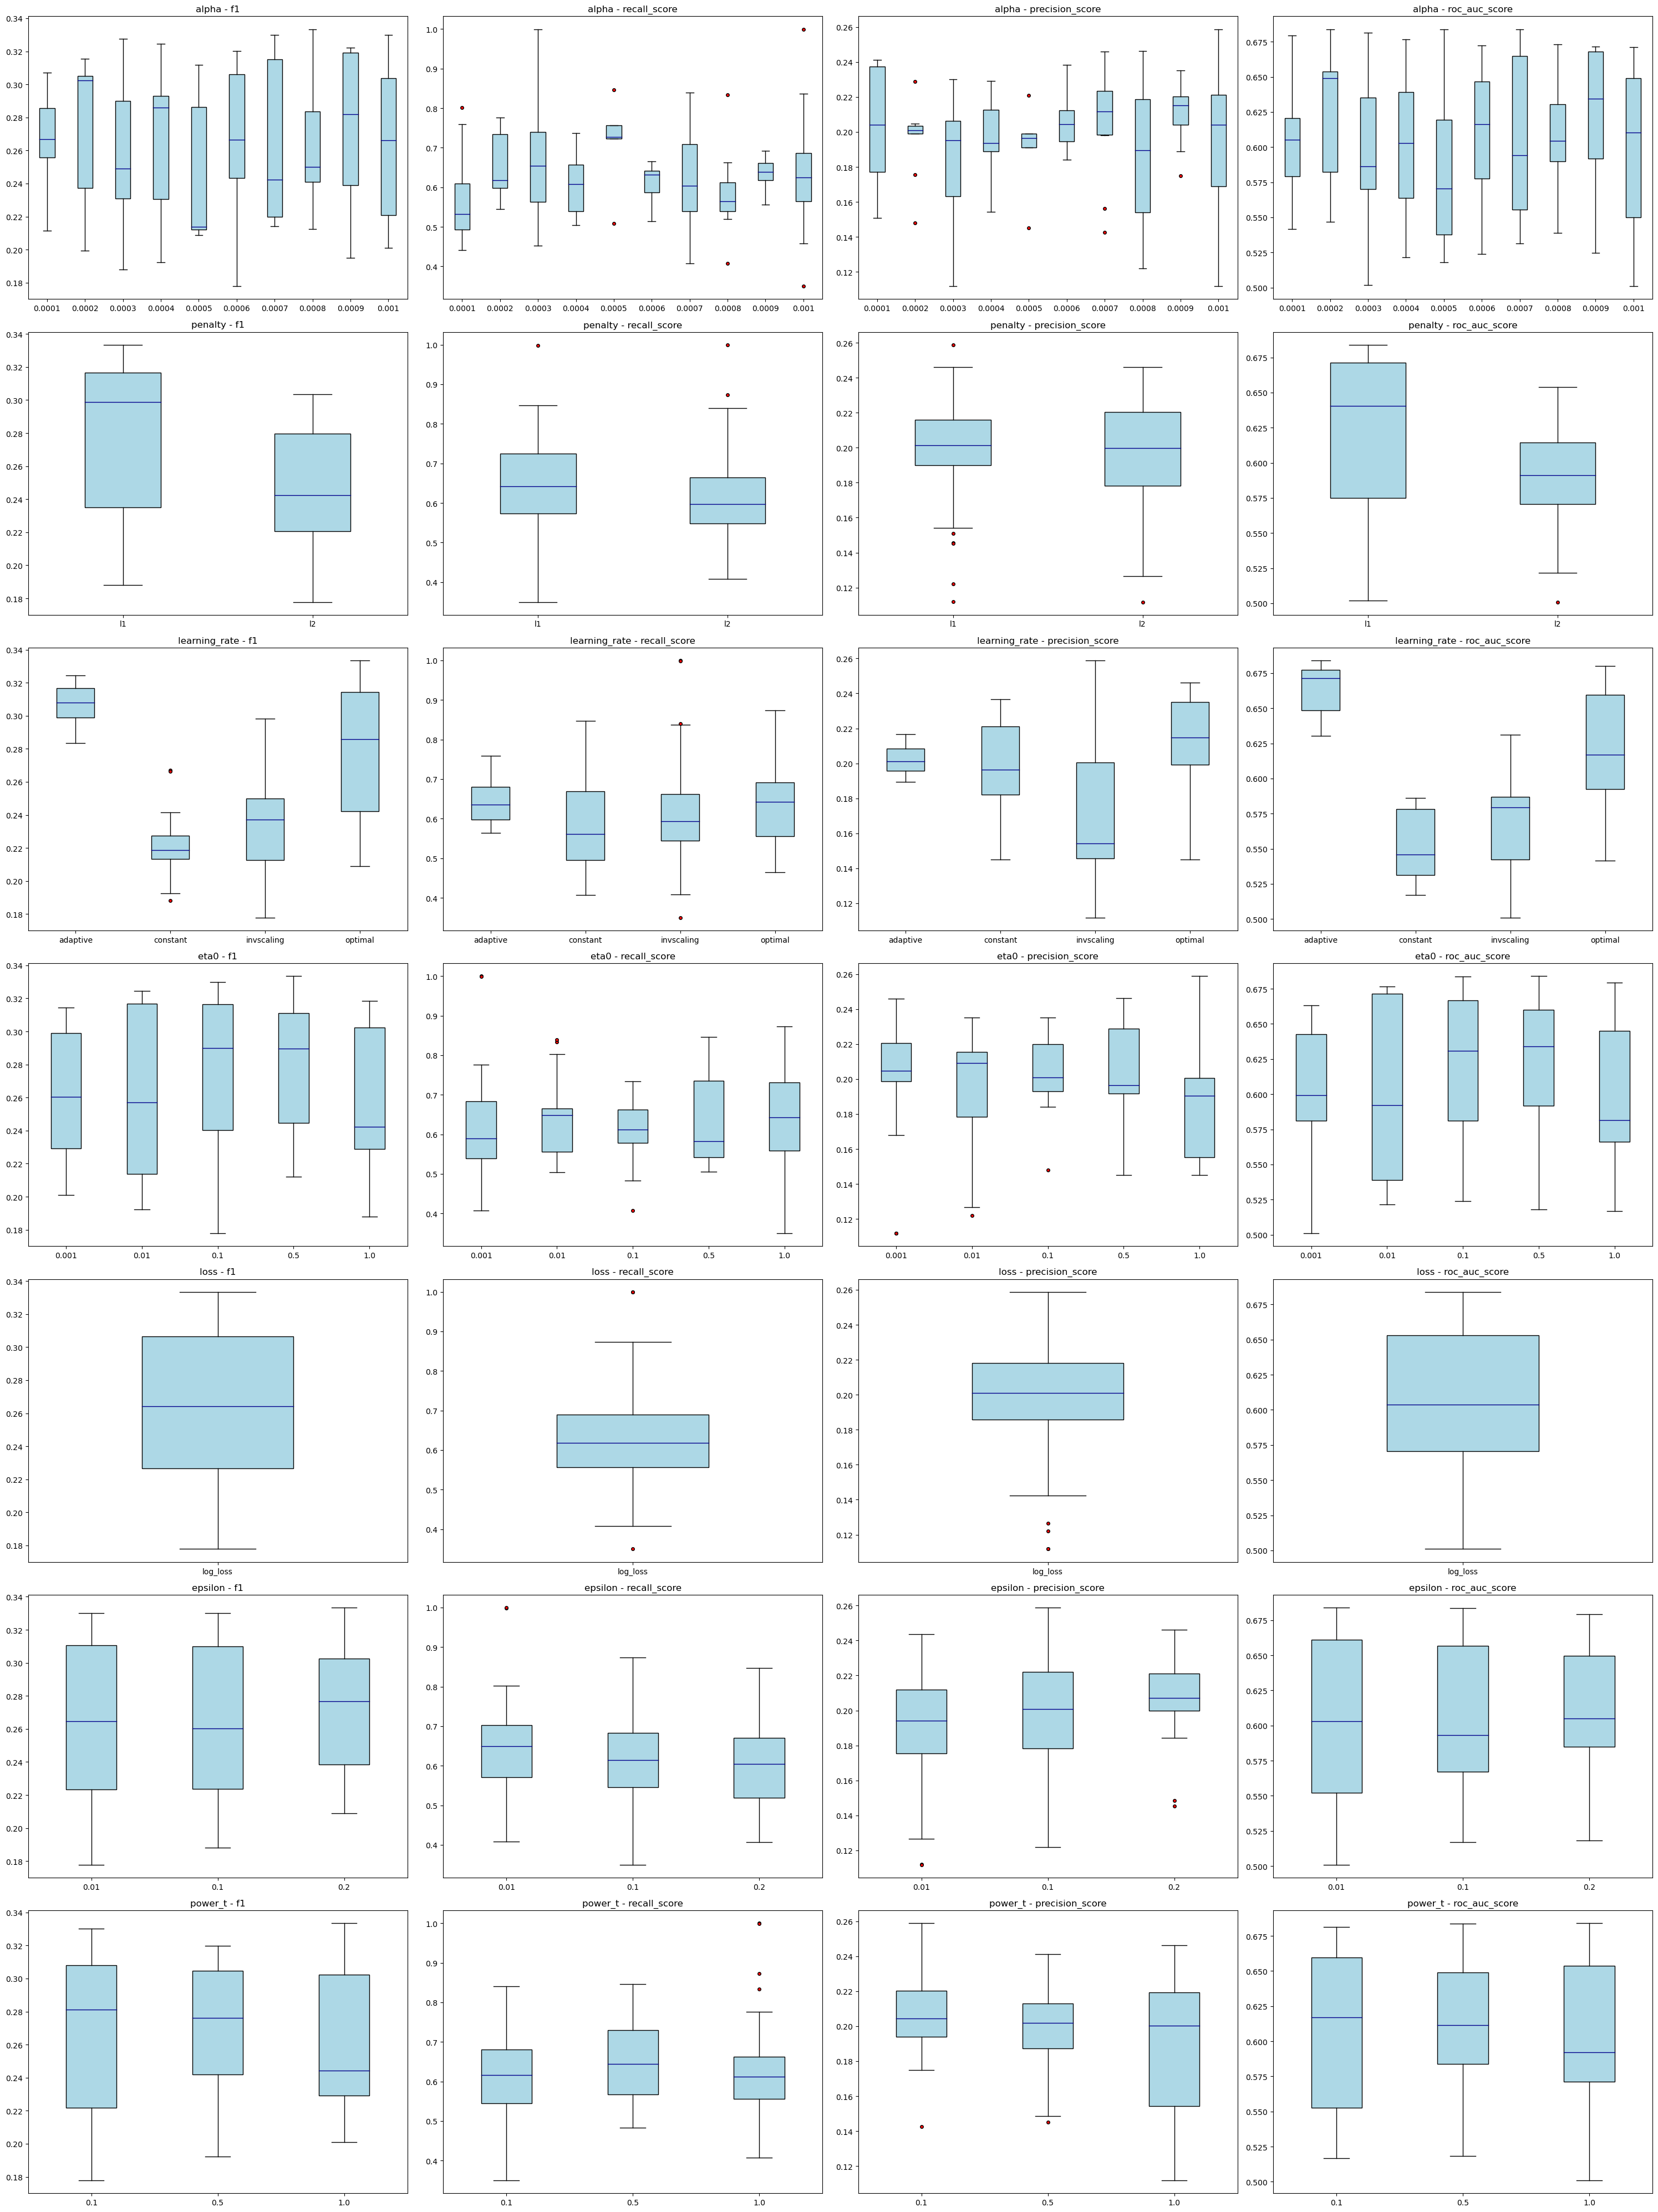

In [32]:
# num_best_models = 90

# best_models = sorted(sgd_log_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

# plot_metrics(sgd_log_result, sgd_log_params, best_models, figsize_param = (30,40))

In [33]:
# best_sgd_log = sorted(sgd_log_result, key = lambda x: -x[1]['f1'][1])[0]
# print('Best Model: {}'.format(SGDClassifier(**best_sgd_log[0])))
# print('F1: {}'.format(round(best_sgd_log[1]['f1'][1],4)))

Best Model: SGDClassifier(alpha=0.0008, class_weight='balanced', epsilon=0.2, eta0=0.5,
              loss='log_loss', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1: 0.3334


In [280]:
# from sklearn.linear_model import SGDClassifier

# ###hinge loss (svm) optimization

# model = SGDClassifier(max_iter=2000, tol=1e-4, class_weight = 'balanced', )


# sgd_svm_params = {
#     'alpha': [ 0.0001, 0.0005, 0.001, 0.01],
#     'penalty': ['l2', 'l1'],
#     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#     'eta0': [0.001, 0.01, 0.1, 0.5, 1.0],
#     'loss': ['hinge', 'squared_hinge'],
#     'epsilon': [0.01, 0.1, 0.2],
#     'power_t': [0.1, 0.5, 1.0],
# }

# sgd_svm_result = []
# for i in tqdm(range(100)):
#     random_params = {}
#     for key, values in sgd_svm_params.items():
#         random_params[key] = random.choice(values)
        
#     sgd_svm_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params, 
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = False, 
#                      cv=5))

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▍                                          | 1/100 [00:01<01:51,  1.12s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='constant', max_iter=2000, tol=0.0001)
F1 train: 0.091, F1_val: 0.090


  2%|▊                                          | 2/100 [00:02<02:05,  1.28s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.212, F1_val: 0.142


  3%|█▎                                         | 3/100 [00:04<02:18,  1.43s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='invscaling', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.249, F1_val: 0.243


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.249, F1_val: 0.261


  5%|██▏                                        | 5/100 [01:03<28:34, 18.05s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.305, F1_val: 0.321


  6%|██▌                                        | 6/100 [01:22<28:35, 18.25s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.306, F1_val: 0.320


  7%|███                                        | 7/100 [01:29<22:27, 14.48s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=1.0,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.295, F1_val: 0.299


  8%|███▍                                       | 8/100 [01:31<16:27, 10.73s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.001, max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.279, F1_val: 0.260


  9%|███▊                                       | 9/100 [01:33<11:43,  7.73s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', max_iter=2000, tol=0.0001)
F1 train: 0.092, F1_val: 0.090


 10%|████▏                                     | 10/100 [01:42<12:17,  8.20s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.302, F1_val: 0.307


 11%|████▌                                     | 11/100 [01:43<08:53,  6.00s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='invscaling', max_iter=2000, power_t=1.0,
              tol=0.0001)
F1 train: 0.162, F1_val: 0.161


 12%|█████                                     | 12/100 [01:54<11:04,  7.56s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=1.0,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.273, F1_val: 0.281


 13%|█████▍                                    | 13/100 [01:59<09:53,  6.82s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.291, F1_val: 0.276


 14%|█████▉                                    | 14/100 [02:10<11:39,  8.13s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.1,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.287, F1_val: 0.288


 15%|██████▎                                   | 15/100 [02:11<08:29,  5.99s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='invscaling', max_iter=2000, power_t=1.0,
              tol=0.0001)
F1 train: 0.180, F1_val: 0.178


 16%|██████▋                                   | 16/100 [02:16<07:49,  5.59s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.244, F1_val: 0.235


 17%|███████▏                                  | 17/100 [02:21<07:41,  5.57s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.01,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.294, F1_val: 0.277


 18%|███████▌                                  | 18/100 [02:28<08:07,  5.95s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.316, F1_val: 0.315


 19%|███████▉                                  | 19/100 [02:29<06:02,  4.48s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              tol=0.0001)
F1 train: 0.198, F1_val: 0.166


 20%|████████▍                                 | 20/100 [02:44<09:53,  7.41s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.277, F1_val: 0.293


 21%|████████▊                                 | 21/100 [02:46<07:36,  5.78s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='invscaling',
              loss='squared_hinge', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.229, F1_val: 0.198


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.01,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.224, F1_val: 0.222


 23%|█████████▋                                | 23/100 [03:46<22:07, 17.24s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              tol=0.0001)
F1 train: 0.261, F1_val: 0.276


 24%|██████████                                | 24/100 [04:02<21:14, 16.77s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.1,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.278, F1_val: 0.288


 25%|██████████▌                               | 25/100 [04:03<15:11, 12.16s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='constant', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.185, F1_val: 0.169


 26%|██████████▉                               | 26/100 [04:26<18:50, 15.28s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.255, F1_val: 0.264


 27%|███████████▎                              | 27/100 [04:33<15:26, 12.69s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              tol=0.0001)
F1 train: 0.228, F1_val: 0.200


 28%|███████████▊                              | 28/100 [04:34<11:10,  9.31s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.240, F1_val: 0.206


 29%|████████████▏                             | 29/100 [04:42<10:39,  9.01s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.01,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.204, F1_val: 0.220


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 30%|████████████▌                             | 30/100 [04:43<07:44,  6.64s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.103, F1_val: 0.104


 31%|█████████████                             | 31/100 [04:47<06:42,  5.83s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.1, max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.308, F1_val: 0.320


 32%|█████████████▍                            | 32/100 [04:59<08:39,  7.64s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=0.001,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.255, F1_val: 0.261


 33%|█████████████▊                            | 33/100 [05:05<07:47,  6.98s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, max_iter=2000, tol=0.0001)
F1 train: 0.266, F1_val: 0.268


 34%|██████████████▎                           | 34/100 [05:08<06:34,  5.97s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', max_iter=2000, tol=0.0001)
F1 train: 0.245, F1_val: 0.229


 35%|██████████████▋                           | 35/100 [05:10<05:06,  4.72s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1,
              learning_rate='invscaling', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.230, F1_val: 0.227


 36%|███████████████                           | 36/100 [05:13<04:19,  4.06s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.5,
              max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.280, F1_val: 0.274


 37%|███████████████▌                          | 37/100 [05:20<05:17,  5.04s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='adaptive', max_iter=2000, tol=0.0001)
F1 train: 0.292, F1_val: 0.296


 38%|███████████████▉                          | 38/100 [05:41<10:15,  9.93s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.302, F1_val: 0.320


 39%|████████████████▍                         | 39/100 [05:53<10:40, 10.50s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.5,
              loss='squared_hinge', max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.282, F1_val: 0.289


 40%|████████████████▊                         | 40/100 [06:00<09:22,  9.37s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.311, F1_val: 0.311


 41%|█████████████████▏                        | 41/100 [06:06<08:24,  8.55s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.5,
              learning_rate='adaptive', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.262, F1_val: 0.257


 42%|█████████████████▋                        | 42/100 [06:08<06:20,  6.55s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', max_iter=2000, power_t=0.1,
              tol=0.0001)
F1 train: 0.184, F1_val: 0.177


 43%|██████████████████                        | 43/100 [06:13<05:40,  5.98s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.1,
              learning_rate='adaptive', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.265, F1_val: 0.255


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 44%|██████████████████▍                       | 44/100 [06:15<04:31,  4.85s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=1.0,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.121, F1_val: 0.122


 45%|██████████████████▉                       | 45/100 [06:20<04:20,  4.74s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='adaptive', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.265, F1_val: 0.252


 46%|███████████████████▎                      | 46/100 [06:26<04:34,  5.08s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, max_iter=2000, power_t=0.1,
              tol=0.0001)
F1 train: 0.228, F1_val: 0.222


 47%|███████████████████▋                      | 47/100 [06:46<08:34,  9.71s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.305, F1_val: 0.318


 48%|████████████████████▏                     | 48/100 [06:47<06:14,  7.19s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.206, F1_val: 0.201


 49%|████████████████████▌                     | 49/100 [06:58<06:53,  8.10s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='adaptive', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.282, F1_val: 0.286


 50%|█████████████████████                     | 50/100 [07:00<05:23,  6.48s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1,
              learning_rate='invscaling', max_iter=2000, tol=0.0001)
F1 train: 0.268, F1_val: 0.250


 51%|█████████████████████▍                    | 51/100 [07:04<04:42,  5.77s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.01,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.310, F1_val: 0.311


 52%|█████████████████████▊                    | 52/100 [07:10<04:32,  5.67s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.294, F1_val: 0.277


 53%|██████████████████████▎                   | 53/100 [07:11<03:25,  4.36s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.206, F1_val: 0.189


 54%|██████████████████████▋                   | 54/100 [07:12<02:37,  3.41s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.215, F1_val: 0.194


 55%|███████████████████████                   | 55/100 [07:21<03:44,  4.98s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.001,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.215, F1_val: 0.235


 56%|███████████████████████▌                  | 56/100 [07:23<03:03,  4.17s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1, max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.269, F1_val: 0.249


 57%|███████████████████████▉                  | 57/100 [07:25<02:23,  3.33s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.180, F1_val: 0.139


 58%|████████████████████████▎                 | 58/100 [07:32<03:08,  4.49s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.295, F1_val: 0.300


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 59%|████████████████████████▊                 | 59/100 [08:12<10:21, 15.17s/it]

SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='invscaling',
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=1.0,
              tol=0.0001)
F1 train: 0.218, F1_val: 0.217


 60%|█████████████████████████▏                | 60/100 [08:15<07:35, 11.39s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.001, max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.249, F1_val: 0.244


 61%|█████████████████████████▌                | 61/100 [08:21<06:31, 10.05s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', eta0=1.0,
              learning_rate='adaptive', max_iter=2000, tol=0.0001)
F1 train: 0.267, F1_val: 0.257


 62%|██████████████████████████                | 62/100 [08:30<06:05,  9.63s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.302, F1_val: 0.307


 63%|██████████████████████████▍               | 63/100 [08:44<06:38, 10.76s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.01,
              loss='squared_hinge', max_iter=2000, penalty='l1', power_t=0.1,
              tol=0.0001)
F1 train: 0.282, F1_val: 0.295


 64%|██████████████████████████▉               | 64/100 [08:45<04:43,  7.88s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.218, F1_val: 0.205


 65%|███████████████████████████▎              | 65/100 [08:46<03:28,  5.95s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.245, F1_val: 0.212


 66%|███████████████████████████▋              | 66/100 [08:53<03:32,  6.25s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.1,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.294, F1_val: 0.298


 67%|████████████████████████████▏             | 67/100 [08:54<02:36,  4.75s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=0.01,
              learning_rate='constant', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.218, F1_val: 0.200


 68%|████████████████████████████▌             | 68/100 [09:09<04:05,  7.66s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              tol=0.0001)
F1 train: 0.305, F1_val: 0.321


 69%|████████████████████████████▉             | 69/100 [09:10<02:59,  5.79s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.228, F1_val: 0.186


 70%|█████████████████████████████▍            | 70/100 [09:15<02:45,  5.51s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.5,
              max_iter=2000, penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.286, F1_val: 0.264


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 71%|█████████████████████████████▊            | 71/100 [09:17<02:04,  4.29s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='invscaling', max_iter=2000, power_t=1.0,
              tol=0.0001)
F1 train: 0.158, F1_val: 0.158


 72%|██████████████████████████████▏           | 72/100 [09:21<02:01,  4.34s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.001,
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.260, F1_val: 0.240


 73%|██████████████████████████████▋           | 73/100 [09:26<02:01,  4.49s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.01,
              max_iter=2000, tol=0.0001)
F1 train: 0.179, F1_val: 0.135


 74%|███████████████████████████████           | 74/100 [09:34<02:24,  5.55s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='adaptive', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.272, F1_val: 0.269


 75%|███████████████████████████████▌          | 75/100 [09:37<01:59,  4.78s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1, max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.290, F1_val: 0.278


 76%|███████████████████████████████▉          | 76/100 [09:40<01:44,  4.34s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='invscaling', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.265, F1_val: 0.263


 77%|████████████████████████████████▎         | 77/100 [09:41<01:18,  3.41s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.01,
              learning_rate='constant', max_iter=2000, tol=0.0001)
F1 train: 0.184, F1_val: 0.172


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='invscaling', max_iter=2000, power_t=0.1,
              tol=0.0001)
F1 train: 0.081, F1_val: 0.081


 79%|█████████████████████████████████▏        | 79/100 [09:44<00:50,  2.40s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='constant', max_iter=2000, penalty='l1',
              tol=0.0001)
F1 train: 0.245, F1_val: 0.225


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|█████████████████████████████████▌        | 80/100 [09:46<00:40,  2.04s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', eta0=0.1,
              learning_rate='constant', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.139, F1_val: 0.141


 81%|██████████████████████████████████        | 81/100 [09:47<00:35,  1.86s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='constant', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.267, F1_val: 0.232


 82%|██████████████████████████████████▍       | 82/100 [09:48<00:31,  1.76s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.238, F1_val: 0.229


 83%|██████████████████████████████████▊       | 83/100 [09:50<00:27,  1.64s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.1,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.233, F1_val: 0.183


 84%|███████████████████████████████████▎      | 84/100 [09:57<00:50,  3.17s/it]

SGDClassifier(class_weight='balanced', eta0=1.0, learning_rate='invscaling',
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.238, F1_val: 0.219


 85%|███████████████████████████████████▋      | 85/100 [10:02<00:55,  3.70s/it]

SGDClassifier(class_weight='balanced', epsilon=0.01, eta0=1.0, max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.270, F1_val: 0.277


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.5,
              loss='squared_hinge', max_iter=2000, power_t=0.1, tol=0.0001)
F1 train: 0.239, F1_val: 0.243


 87%|████████████████████████████████████▌     | 87/100 [10:43<02:18, 10.63s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.5,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.246, F1_val: 0.218


 88%|████████████████████████████████████▉     | 88/100 [10:46<01:41,  8.43s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.001,
              learning_rate='adaptive', max_iter=2000, penalty='l1',
              power_t=0.1, tol=0.0001)
F1 train: 0.308, F1_val: 0.298


 89%|█████████████████████████████████████▍    | 89/100 [10:50<01:15,  6.87s/it]

SGDClassifier(class_weight='balanced', eta0=0.5, learning_rate='invscaling',
              max_iter=2000, tol=0.0001)
F1 train: 0.230, F1_val: 0.198


 90%|█████████████████████████████████████▊    | 90/100 [11:12<01:56, 11.65s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1 train: 0.292, F1_val: 0.325


 91%|██████████████████████████████████████▏   | 91/100 [11:14<01:17,  8.59s/it]

SGDClassifier(class_weight='balanced', eta0=0.5, learning_rate='constant',
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.181, F1_val: 0.167


 92%|██████████████████████████████████████▋   | 92/100 [11:17<00:54,  6.87s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', eta0=1.0,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=0.1, tol=0.0001)
F1 train: 0.245, F1_val: 0.236


 93%|███████████████████████████████████████   | 93/100 [11:22<00:45,  6.51s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.001,
              max_iter=2000, penalty='l1', tol=0.0001)
F1 train: 0.254, F1_val: 0.259


 94%|███████████████████████████████████████▍  | 94/100 [11:26<00:33,  5.57s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.5,
              learning_rate='invscaling', max_iter=2000, penalty='l1',
              power_t=1.0, tol=0.0001)
F1 train: 0.247, F1_val: 0.247


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 95%|███████████████████████████████████████▉  | 95/100 [12:04<01:17, 15.49s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=0.01,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              penalty='l1', power_t=1.0, tol=0.0001)
F1 train: 0.202, F1_val: 0.199


 96%|████████████████████████████████████████▎ | 96/100 [12:07<00:46, 11.70s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.2, eta0=0.001,
              max_iter=2000, tol=0.0001)
F1 train: 0.285, F1_val: 0.273


 97%|████████████████████████████████████████▋ | 97/100 [12:31<00:46, 15.40s/it]

SGDClassifier(alpha=0.0005, class_weight='balanced', epsilon=0.2, eta0=0.01,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              penalty='l1', tol=0.0001)
F1 train: 0.262, F1_val: 0.276


 98%|█████████████████████████████████████████▏| 98/100 [12:39<00:25, 12.99s/it]

SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.2, eta0=1.0,
              learning_rate='invscaling', loss='squared_hinge', max_iter=2000,
              power_t=1.0, tol=0.0001)
F1 train: 0.235, F1_val: 0.212


 99%|█████████████████████████████████████████▌| 99/100 [12:49<00:12, 12.32s/it]

SGDClassifier(class_weight='balanced', epsilon=0.2, eta0=0.001,
              learning_rate='adaptive', loss='squared_hinge', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.306, F1_val: 0.320


100%|█████████████████████████████████████████| 100/100 [12:50<00:00,  7.71s/it]

SGDClassifier(alpha=0.01, class_weight='balanced', epsilon=0.01, eta0=1.0,
              learning_rate='constant', loss='squared_hinge', max_iter=2000,
              power_t=0.1, tol=0.0001)
F1 train: 0.158, F1_val: 0.157


In [284]:
# with open('Learning_results/sgd_svm_model_selection.pkl', 'wb') as file:
#     pickle.dump(sgd_svm_result, file)

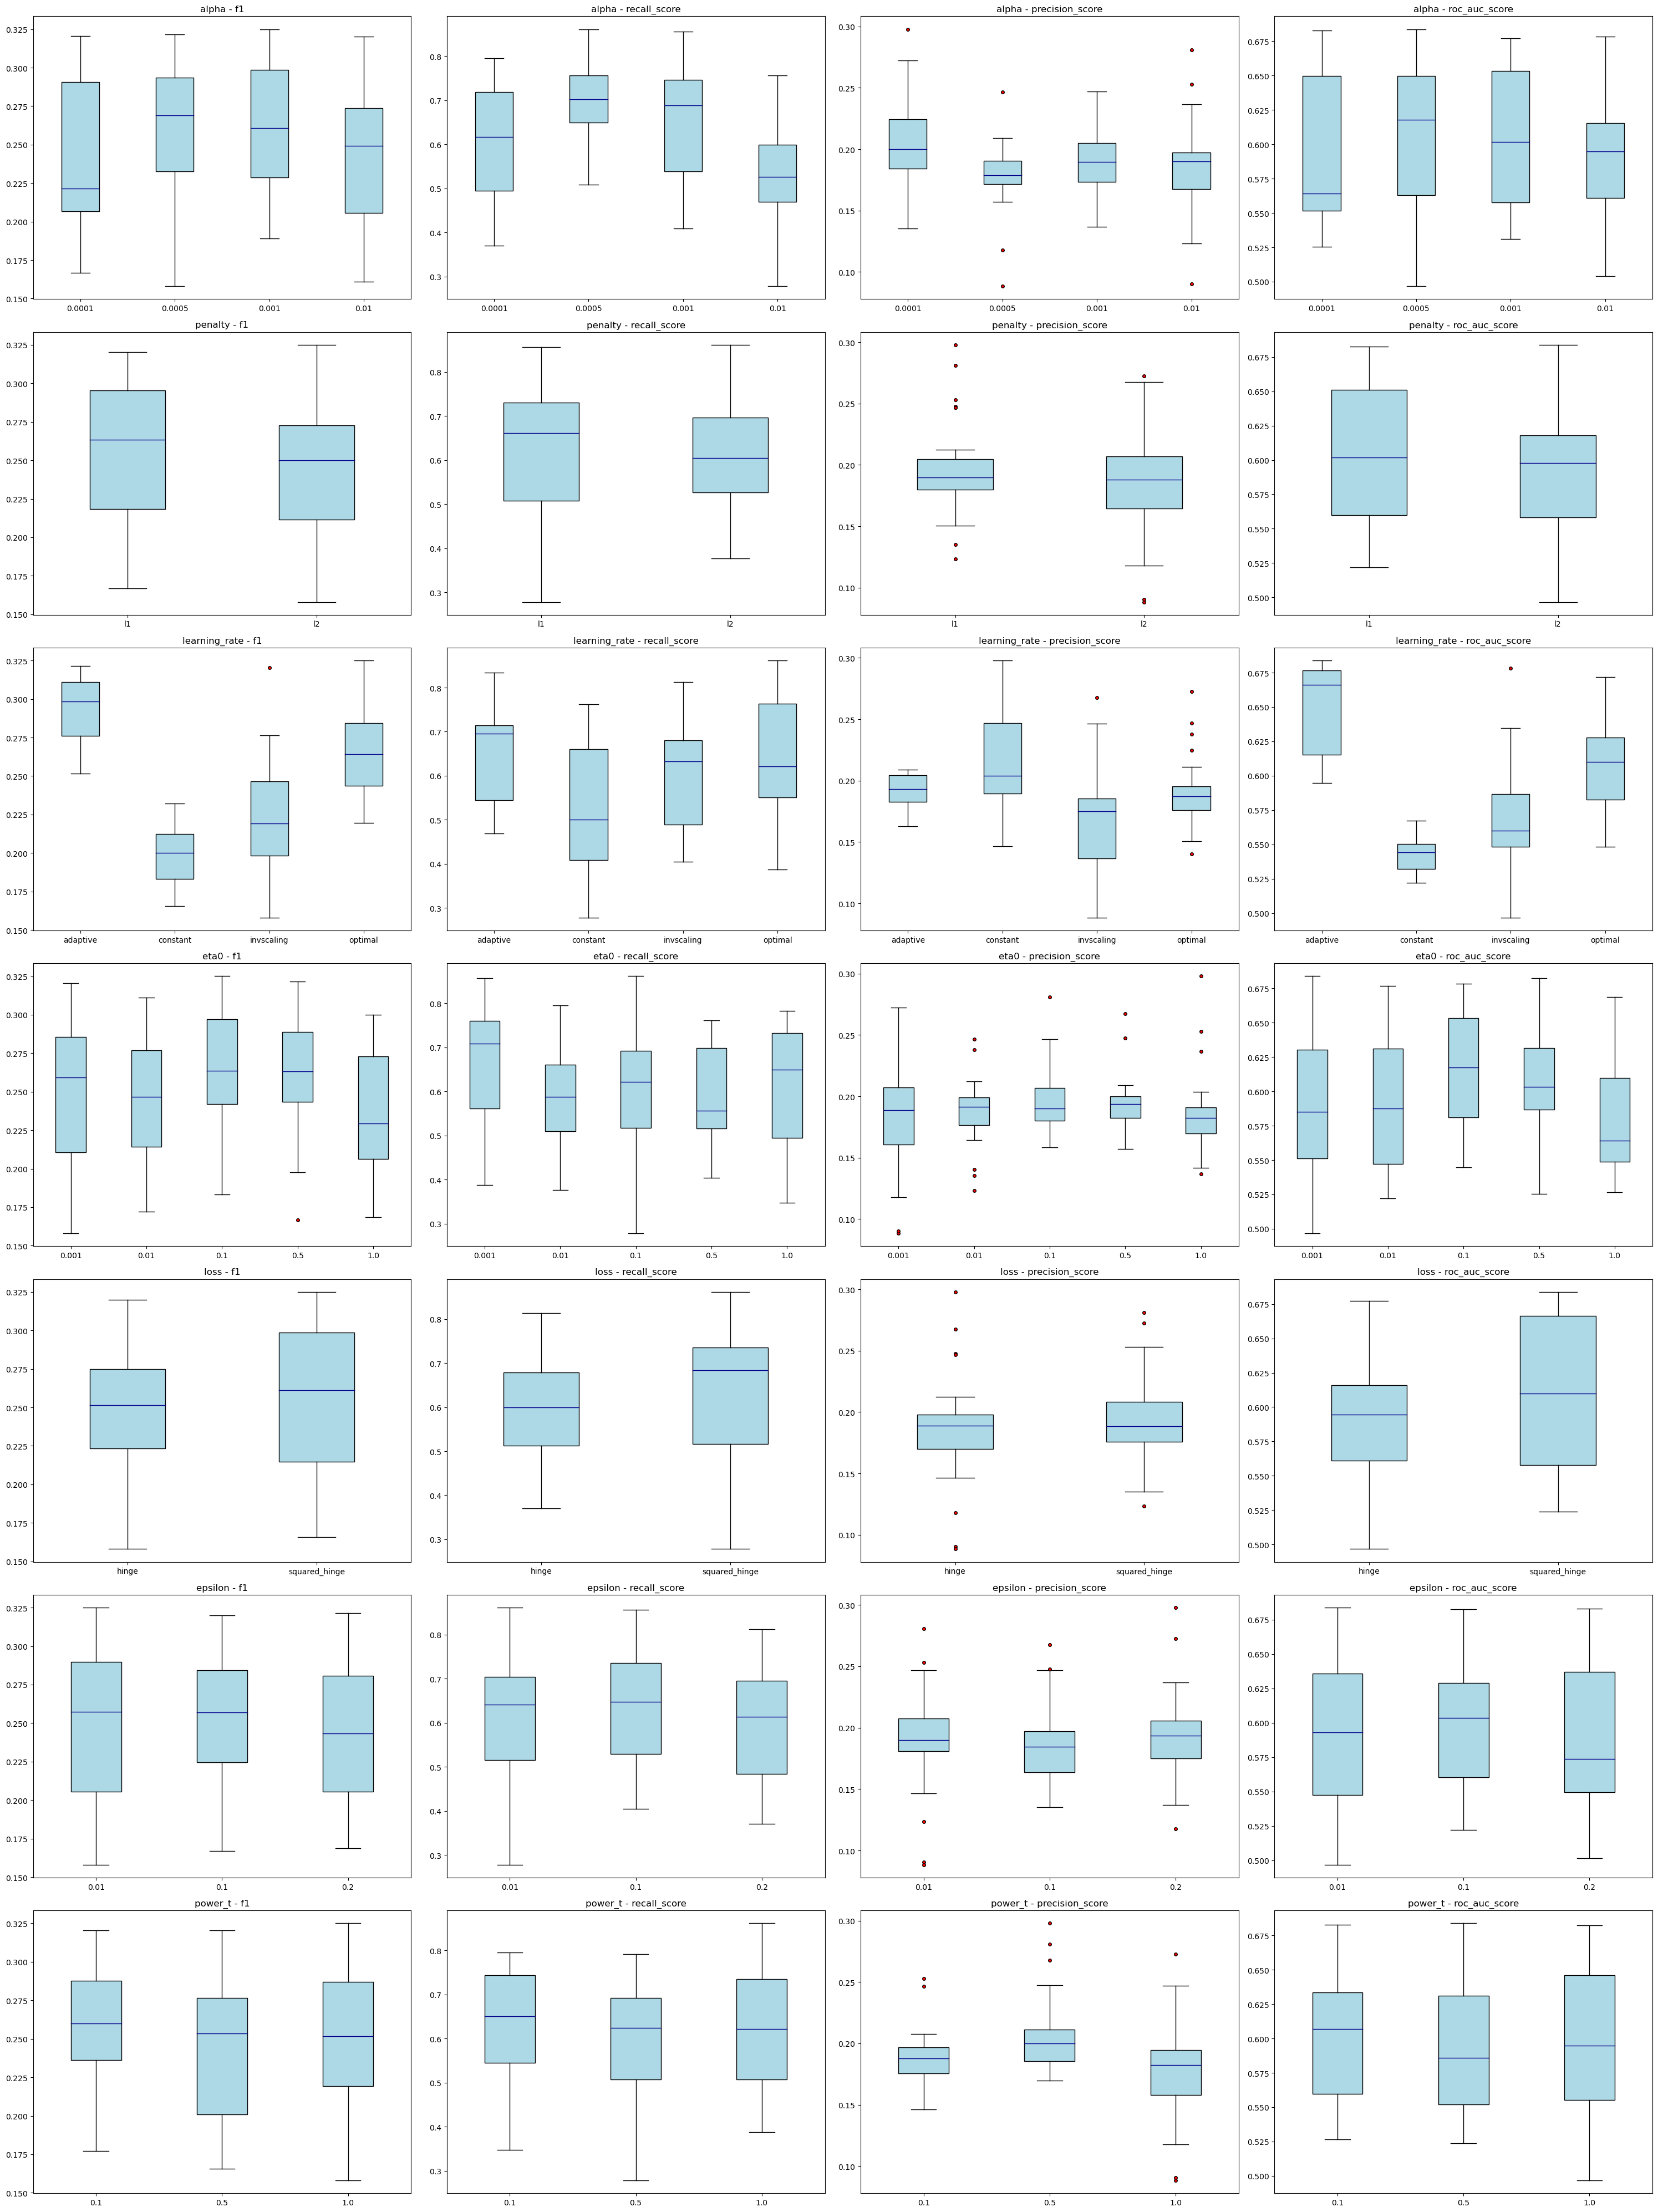

In [285]:
# num_best_models = 90

# best_models = sorted(sgd_svm_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

# plot_metrics(sgd_svm_result, sgd_svm_params, best_models, figsize_param = (30,40))

In [286]:
# best_sgd_svm = sorted(sgd_svm_result, key = lambda x: -x[1]['f1'][1])[0]
# print('Best Model: {}'.format(SGDClassifier(**best_sgd_svm[0])))
# print('F1: {}'.format(round(best_sgd_svm[1]['f1'][1],4)))

Best Model: SGDClassifier(alpha=0.001, class_weight='balanced', epsilon=0.01, eta0=0.1,
              loss='squared_hinge', max_iter=2000, power_t=1.0, tol=0.0001)
F1: 0.325


#### Gaussian NB

In [243]:
# model = GaussianNB()

# gnb_params = {
#     'var_smoothing': 1e-9,
# }

# gnb_upsample_params = []
# gnb_result = []
# for upsample in [True,False]:
#     for upsample_type in ['simple', 'SMOTE']:
#         if upsample == False:
#            upsample_type = None 
#         gnb_upsample_params.append([upsample, upsample_type])
#         print(upsample, upsample_type)
#         gnb_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      gnb_params, 
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = upsample, 
#                      upsample_type = upsample_type,
#                      cv=5))
        
    

True simple
GaussianNB()
F1 train: 0.688, F1_val: 0.234
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


GaussianNB()
F1 train: 0.801, F1_val: 0.243
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


GaussianNB()
F1 train: 0.269, F1_val: 0.269
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


GaussianNB()
F1 train: 0.269, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


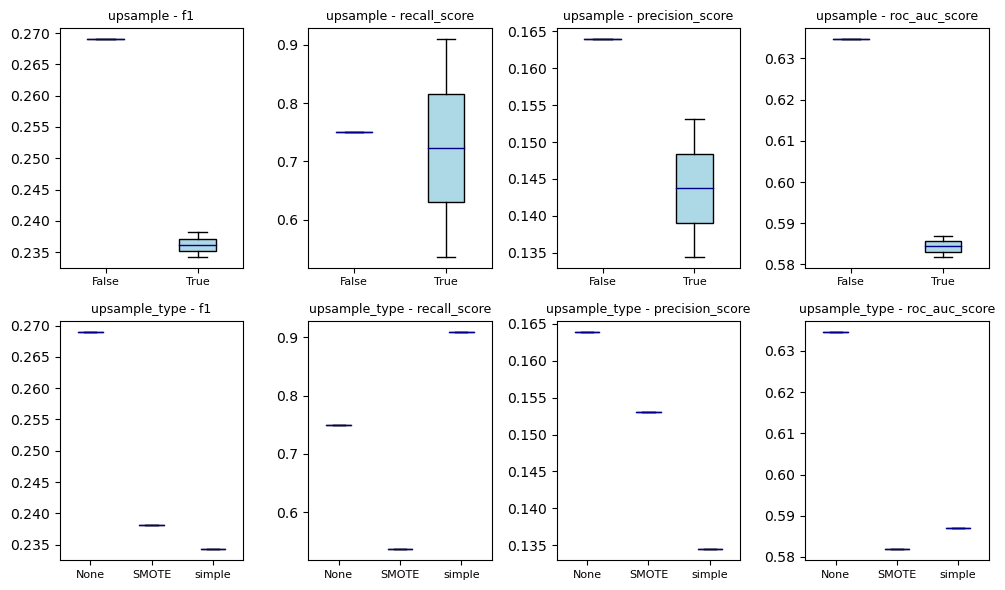

In [298]:
# upsample_list = ['upsample', 'upsample_type']

# fig,ax = plt.subplots(ncols = len(cnb_result[0][1]), nrows = len(upsample_list), figsize = (10,6))
    
# for m in range(len(cnb_result[0][1])):
#     for key in range(len(upsample_list)):
#         hyperparam = upsample_list[key]
#         metric = list(cnb_result[0][1].keys())[m]
#         hyperparam_df = pd.DataFrame(list(zip([i[key] for i in cnb_upsample_params], [( cnb_result[i][1][metric][1]) for i in range(len(cnb_result))])),
#                                      columns = ['hyperparameter', metric]).fillna('None')
#         if hyperparam_df['hyperparameter'].dtype == 'O':
#             hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
#         hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
        
#         ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
#         labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
#         patch_artist=True,
#         widths=0.4,         
#         medianprops=dict(color='darkblue'),
#         boxprops=dict(facecolor='lightblue', edgecolor='black'),
#          whiskerprops=dict(color='black'), 
#          capprops=dict(color='black'),
#         flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
#                           ) 
#         ax[key, m].tick_params(axis='x', labelsize=8)
#         ax[key, m].set_title(hyperparam + ' - ' + metric, fontsize=9)

#         ax[key, m].xaxis.grid(False)
#         ax[key, m].yaxis.grid(False)
# plt.tight_layout()
# plt.savefig('Images/gradient_boosting_upsample_results.png')
# plt.show()

In [242]:
# model = GaussianNB()

# gnb_result = []
# gnb_params = {
#     'var_smoothing': 1e-9,
# }

# gnb_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      gnb_params, 
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = False, 
#                      cv=5))

GaussianNB()
F1 train: 0.269, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [302]:
# with open('Learning_results/gnb_model_selection.pkl', 'wb') as file:
#     pickle.dump(gnb_result, file)

#### MLP Classifier

In [230]:
# model = MLPClassifier(verbose = False)

# params = {
#     'hidden_layer_sizes': [(50, 50), (100,), (30,30)],
#     'activation': ['logistic', 'tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],
#     'max_iter': [50]
# }

# mlp_upsample_params = []
# mlp_result = []
# for i in tqdm(range(30)):
#     random_params = {}
#     for key, values in params.items():
#         random_params[key] = random.choice(values)
        
#     upsample = random.choice([True,False])
#     if upsample == True:
#        upsample_type = random.choice(['simple', 'SMOTE'])
#     else:
#        upsample_type = None
#     mlp_upsample_params.append([upsample, upsample_type])
#     print(upsample, upsample_type)
#     mlp_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params, 
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = upsample, 
#                      upsample_type = upsample_type,
#                      cv=5))

  0%|                                                    | 0/30 [00:00<?, ?it/s]

False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarni

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.000
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', learning_rate='invscaling', max_iter=50)
F1 train: 0.755, F1_val: 0.312
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=50,
              solver='sgd')
F1 train: 0.575, F1_val: 0.249
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.889, F1_val: 0.203
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              max_iter=50)
F1 train: 0.730, F1_val: 0.310
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(alpha=0.001, learning_rate='invscaling', max_iter=50)
F1 train: 0.080, F1_val: 0.095
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.056, F1_val: 0.070
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=50)
F1 train: 0.682, F1_val: 0.313
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sa

MLPClassifier(alpha=0.01, learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.017, F1_val: 0.001
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=50)
F1 train: 0.892, F1_val: 0.199
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='adaptive',
              max_iter=50, solver='sgd')
F1 train: 0.010, F1_val: 0.001
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarni

MLPClassifier(activation='logistic', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.000
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=50)
F1 train: 0.741, F1_val: 0.316
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarni

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and t

MLPClassifier(activation='tanh', max_iter=50, solver='sgd')
F1 train: 0.004, F1_val: 0.001
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, learning_rate='invscaling',
              max_iter=50)
F1 train: 0.046, F1_val: 0.046
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(learning_rate='adaptive', max_iter=50)
F1 train: 0.894, F1_val: 0.180
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 63%|███████████████████████████▏               | 19/30 [09:53<06:31, 35.62s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.771, F1_val: 0.210
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.001, learning_rate='adaptive',
              max_iter=50, solver='sgd')
F1 train: 0.639, F1_val: 0.285
True SMOTE


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50)
F1 train: 0.892, F1_val: 0.210
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='invscaling',
              max_iter=50)
F1 train: 0.712, F1_val: 0.323
True simple


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              max_iter=50, solver='sgd')
F1 train: 0.639, F1_val: 0.282
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.001, learning_rate='adaptive',
              max_iter=50)
F1 train: 0.079, F1_val: 0.075
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.01, learning_rate='invscaling',
              max_iter=50)
F1 train: 0.050, F1_val: 0.051
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and t

MLPClassifier(learning_rate='adaptive', max_iter=50, solver='sgd')
F1 train: 0.025, F1_val: 0.001
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and t

MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=50,
              solver='sgd')
F1 train: 0.005, F1_val: 0.000
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(learning_rate='invscaling', max_iter=50)
F1 train: 0.078, F1_val: 0.097
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/a

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=50)
F1 train: 0.047, F1_val: 0.029
False None


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████

MLPClassifier(alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=50, solver='sgd')
F1 train: 0.000, F1_val: 0.001


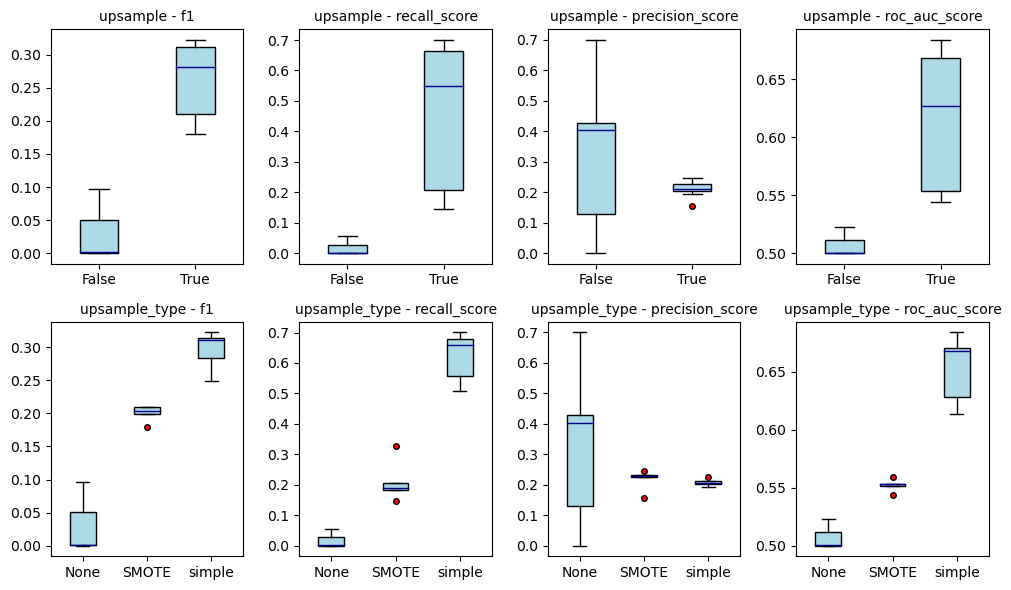

<Figure size 640x480 with 0 Axes>

In [231]:
# upsample_list = ['upsample', 'upsample_type']

# fig,ax = plt.subplots(ncols = len(mlp_result[0][1]), nrows = len(upsample_list), figsize = (10,6))
    
# for m in range(len(mlp_result[0][1])):
#     for key in range(len(upsample_list)):
#         hyperparam = upsample_list[key]
#         metric = list(mlp_result[0][1].keys())[m]
#         hyperparam_df = pd.DataFrame(list(zip([i[key] for i in mlp_upsample_params], [( mlp_result[i][1][metric][1]) for i in range(len(mlp_result))])),
#                                      columns = ['hyperparameter', metric]).fillna('None')
#         if hyperparam_df['hyperparameter'].dtype == 'O':
#             hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
#         hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
        
#         ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
#         labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
#         patch_artist=True,
#         widths=0.4,         
#         medianprops=dict(color='darkblue'),
#         boxprops=dict(facecolor='lightblue', edgecolor='black'),
#          whiskerprops=dict(color='black'), 
#          capprops=dict(color='black'),
#         flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
#                           ) 
#         ax[key, m].tick_params(axis='x', labelsize=10)
#         ax[key, m].set_title(hyperparam + ' - ' + metric, fontsize=10)

#         ax[key, m].xaxis.grid(False)
#         ax[key, m].yaxis.grid(False)
# plt.tight_layout()
# plt.show()
# plt.savefig('Images/mlp_upsample_results.png')

In [241]:
# ## Rerun with simple upsampling

# model = MLPClassifier(verbose = False)

# params = {
#     'hidden_layer_sizes': [(50, 50), (100,), (30,30), (80,80), (30,30,30), (100,100)],
#     'activation': ['logistic', 'tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.001, 0.01],
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],
#     'max_iter': [200, 300, 400]
# }

# mlp_upsample_params = []
# mlp_result = []
# for i in tqdm(range(100)):
#     random_params = {}
#     for key, values in params.items():
#         random_params[key] = random.choice(values)

#     mlp_result.append(cross_validation(data, 
#                      target, 
#                      model, 
#                      random_params, 
#                      scaling = True,
#                      features_for_scaling_minmax = features_for_scaling_minmax,
#                      features_for_scaling_standard = features_for_scaling_standard,
#                      upsample = True, 
#                      upsample_type = 'simple',
#                      cv=5))

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|▍                                          | 1/100 [00:21<34:42, 21.03s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(80, 80),
              learning_rate='invscaling', solver='sgd')
F1 train: 0.599, F1_val: 0.267


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.610, F1_val: 0.275


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  3%|█▏                                      | 3/100 [06:00<3:44:20, 138.77s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30, 30), max_iter=300,
              solver='sgd')
F1 train: 0.595, F1_val: 0.251


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30, 30),
              max_iter=400)
F1 train: 0.781, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|██                                      | 5/100 [15:25<5:47:12, 219.28s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=400)
F1 train: 0.785, F1_val: 0.295


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(80, 80),
              learning_rate='invscaling')
F1 train: 0.812, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50))
F1 train: 0.806, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  8%|███▏                                    | 8/100 [25:31<5:01:55, 196.91s/it]

MLPClassifier(activation='tanh', alpha=0.001, max_iter=300, solver='sgd')
F1 train: 0.638, F1_val: 0.293


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30))
F1 train: 0.748, F1_val: 0.309


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(hidden_layer_sizes=(50, 50), solver='sgd')
F1 train: 0.574, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|████▎                                  | 11/100 [30:07<2:53:28, 116.95s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=300, solver='sgd')
F1 train: 0.659, F1_val: 0.204


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 12%|████▋                                  | 12/100 [37:55<5:28:09, 223.74s/it]

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 100),
              max_iter=400, solver='sgd')
F1 train: 0.659, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.662, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=300)
F1 train: 0.812, F1_val: 0.296


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 15%|█████▊                                 | 15/100 [50:37<5:30:06, 233.01s/it]

MLPClassifier(activation='tanh', hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive', max_iter=300, solver='sgd')
F1 train: 0.656, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|██████▏                                | 16/100 [56:27<6:15:29, 268.20s/it]

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100),
              max_iter=300, solver='sgd')
F1 train: 0.674, F1_val: 0.281


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|██████▋                                | 17/100 [59:27<5:34:23, 241.73s/it]

MLPClassifier(learning_rate='adaptive', max_iter=300)
F1 train: 0.777, F1_val: 0.299


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30), solver='sgd')
F1 train: 0.661, F1_val: 0.279


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|███████                              | 19/100 [1:08:33<6:06:17, 271.32s/it]

MLPClassifier(hidden_layer_sizes=(80, 80), learning_rate='invscaling',
              max_iter=400)
F1 train: 0.872, F1_val: 0.262


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30))
F1 train: 0.762, F1_val: 0.301


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', max_iter=400, solver='sgd')
F1 train: 0.670, F1_val: 0.284


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 22%|████████▏                            | 22/100 [1:24:57<6:34:49, 303.71s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=300)
F1 train: 0.748, F1_val: 0.307


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              max_iter=300)
F1 train: 0.799, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive')
F1 train: 0.808, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30), max_iter=300)
F1 train: 0.775, F1_val: 0.296


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn

MLPClassifier(activation='logistic', alpha=0.001,
              hidden_layer_sizes=(30, 30, 30), learning_rate='invscaling',
              solver='sgd')
F1 train: 0.128, F1_val: 0.040


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh')
F1 train: 0.796, F1_val: 0.293


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 28%|██████████▎                          | 28/100 [1:46:00<4:43:54, 236.59s/it]

MLPClassifier(hidden_layer_sizes=(80, 80), learning_rate='adaptive',
              max_iter=400)
F1 train: 0.859, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 29%|██████████▋                          | 29/100 [1:46:10<3:19:26, 168.54s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=400, solver='sgd')
F1 train: 0.458, F1_val: 0.197


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 30%|█████████

MLPClassifier(activation='logistic', alpha=0.001,
              hidden_layer_sizes=(30, 30, 30), learning_rate='invscaling',
              max_iter=300, solver='sgd')
F1 train: 0.533, F1_val: 0.161


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 31%|███████████▊                          | 31/100 [1:46:31<1:41:03, 87.87s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=400, solver='sgd')
F1 train: 0.270, F1_val: 0.101


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(80, 80),
              max_iter=300)
F1 train: 0.893, F1_val: 0.259


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|████████████▏                        | 33/100 [1:53:43<2:30:50, 135.08s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30, 30),
              learning_rate='invscaling', solver='sgd')
F1 train: 0.558, F1_val: 0.232


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 34%|████████████▉                         | 34/100 [1:53:59<1:49:19, 99.38s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=300, solver='sgd')
F1 train: 0.577, F1_val: 0.235


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=300)
F1 train: 0.760, F1_val: 0.302


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|█████████████▎                       | 36/100 [2:00:59<2:46:42, 156.29s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive', max_iter=300, solver='sgd')
F1 train: 0.664, F1_val: 0.293


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 37%|█████████████▋                       | 37/100 [2:11:07<5:06:17, 291.70s/it]

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', max_iter=400, solver='sgd')
F1 train: 0.654, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.657, F1_val: 0.289


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 39%|██████████████▍                      | 39/100 [2:15:59<3:38:43, 215.14s/it]

MLPClassifier(max_iter=300, solver='sgd')
F1 train: 0.620, F1_val: 0.264


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 40%|██████████████▊                      | 40/100 [2:16:13<2:34:46, 154.77s/it]

MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='invscaling',
              max_iter=300, solver='sgd')
F1 train: 0.605, F1_val: 0.261


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(80, 80),
              learning_rate='invscaling', max_iter=300)
F1 train: 0.895, F1_val: 0.255


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 42%|███████████████▌                     | 42/100 [2:24:42<3:03:52, 190.22s/it]

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30, 30),
              solver='sgd')
F1 train: 0.574, F1_val: 0.259


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001)
F1 train: 0.803, F1_val: 0.294


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.665, F1_val: 0.275


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 45%|████████████████▋                    | 45/100 [2:37:31<3:56:07, 257.59s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(80, 80),
              max_iter=400)
F1 train: 0.879, F1_val: 0.257


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 46%|█████████████████                    | 46/100 [2:39:23<3:12:44, 214.16s/it]

MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30), max_iter=400)
F1 train: 0.730, F1_val: 0.317


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 47%|█████████████████▍                   | 47/100 [2:39:36<2:15:41, 153.62s/it]

MLPClassifier(activation='logistic', alpha=0.001, learning_rate='invscaling',
              solver='sgd')
F1 train: 0.582, F1_val: 0.229


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, learning_rate='invscaling',
              max_iter=300)
F1 train: 0.808, F1_val: 0.286


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 49%|██████████████████▏                  | 49/100 [2:43:32<1:47:29, 126.46s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(80, 80),
              learning_rate='invscaling', solver='sgd')
F1 train: 0.515, F1_val: 0.162


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=400)
F1 train: 0.770, F1_val: 0.300


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 80))
F1 train: 0.879, F1_val: 0.269


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 52%|███████████████████▏                 | 52/100 [2:55:13<2:32:13, 190.29s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30), max_iter=400,
              solver='sgd')
F1 train: 0.637, F1_val: 0.284


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 53%|███████████████████▌                 | 53/100 [2:55:41<1:50:56, 141.62s/it]

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100),
              learning_rate='invscaling', max_iter=400, solver='sgd')
F1 train: 0.589, F1_val: 0.246


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(learning_rate='adaptive')
F1 train: 0.773, F1_val: 0.297


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 55%|████████████████████▎                | 55/100 [2:59:49<1:38:43, 131.63s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=400)
F1 train: 0.724, F1_val: 0.314


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 56%|█████████████████████▎                | 56/100 [3:00:00<1:10:06, 95.61s/it]

MLPClassifier(activation='logistic', alpha=0.01,
              hidden_layer_sizes=(30, 30, 30), max_iter=400, solver='sgd')
F1 train: 0.632, F1_val: 0.204


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 57%|█████████████████████                | 57/100 [3:05:51<2:03:26, 172.25s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(80, 80),
              max_iter=300, solver='sgd')
F1 train: 0.663, F1_val: 0.283


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30),
              learning_rate='invscaling')
F1 train: 0.754, F1_val: 0.302


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(80, 80),
              learning_rate='adaptive')
F1 train: 0.809, F1_val: 0.288


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 60%|██████████████████████▏              | 60/100 [3:14:41<1:55:17, 172.95s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30), max_iter=300,
              solver='sgd')
F1 train: 0.663, F1_val: 0.282


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              solver='sgd')
F1 train: 0.688, F1_val: 0.272


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh')
F1 train: 0.797, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 63%|███████████████████████▎             | 63/100 [3:22:39<1:27:57, 142.63s/it]

MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              solver='sgd')
F1 train: 0.611, F1_val: 0.268


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 30, 30),
              max_iter=300)
F1 train: 0.767, F1_val: 0.289


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 65%|█████████

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', solver='sgd')
F1 train: 0.412, F1_val: 0.152


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, learning_rate='adaptive',
              solver='sgd')
F1 train: 0.663, F1_val: 0.271


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 100))
F1 train: 0.888, F1_val: 0.250


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(hidden_layer_sizes=(50, 50), solver='sgd')
F1 train: 0.627, F1_val: 0.264


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001)
F1 train: 0.801, F1_val: 0.286


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 70%|█████████████████████████▉           | 70/100 [3:42:05<1:18:11, 156.39s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=400)
F1 train: 0.755, F1_val: 0.300


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(hidden_layer_sizes=(80, 80))
F1 train: 0.850, F1_val: 0.259


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=400)
F1 train: 0.838, F1_val: 0.286


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=300)
F1 train: 0.817, F1_val: 0.280


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 74%|███████████████████████████▍         | 74/100 [4:00:33<1:43:55, 239.84s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=300)
F1 train: 0.800, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50),
              max_iter=300)
F1 train: 0.799, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 76%|████████████████████████████         | 76/100 [4:05:18<1:11:19, 178.32s/it]

MLPClassifier(hidden_layer_sizes=(30, 30), learning_rate='invscaling',
              max_iter=400, solver='sgd')
F1 train: 0.594, F1_val: 0.253


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(30, 30))
F1 train: 0.745, F1_val: 0.304


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 100), max_iter=300,
              solver='sgd')
F1 train: 0.652, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 100),
              learning_rate='adaptive', solver='sgd')
F1 train: 0.626, F1_val: 0.284


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 80%|█████████████████████████████▌       | 80/100 [4:20:59<1:10:40, 212.01s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='adaptive', max_iter=400)
F1 train: 0.732, F1_val: 0.307


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 81%|█████████████████████████████▉       | 81/100 [4:25:08<1:10:40, 223.18s/it]

MLPClassifier(activation='tanh', alpha=0.001, learning_rate='adaptive',
              max_iter=400)
F1 train: 0.812, F1_val: 0.276


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(80, 80),
              solver='sgd')
F1 train: 0.644, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 83%|████████████████████████████████▎      | 83/100 [4:29:25<46:36, 164.47s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50),
              learning_rate='invscaling', max_iter=400, solver='sgd')
F1 train: 0.264, F1_val: 0.111


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(80, 80),
              max_iter=300, solver='sgd')
F1 train: 0.627, F1_val: 0.293


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 85%|█████████████████████████████████▏     | 85/100 [4:37:54<50:17, 201.19s/it]

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30, 30),
              learning_rate='invscaling')
F1 train: 0.761, F1_val: 0.299


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_m

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(80, 80),
              learning_rate='adaptive', max_iter=300, solver='sgd')
F1 train: 0.668, F1_val: 0.291


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 87%|█████████████████████████████████▉     | 87/100 [4:48:46<57:32, 265.61s/it]

MLPClassifier(alpha=0.01, hidden_layer_sizes=(80, 80), max_iter=400)
F1 train: 0.850, F1_val: 0.272


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 88%|██████████████████████████████████▎    | 88/100 [4:51:31<47:06, 235.56s/it]

MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=400, solver='sgd')
F1 train: 0.625, F1_val: 0.273


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001)
F1 train: 0.789, F1_val: 0.292


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', learning_rate='invscaling', max_iter=400)
F1 train: 0.829, F1_val: 0.282


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', learning_rate='invscaling', max_iter=300)
F1 train: 0.817, F1_val: 0.278


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 92%|███████████████████████████████████▉   | 92/100 [5:07:41<33:26, 250.84s/it]

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(80, 80),
              learning_rate='invscaling', max_iter=300)
F1 train: 0.746, F1_val: 0.304


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(30, 30))
F1 train: 0.757, F1_val: 0.301


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive')
F1 train: 0.808, F1_val: 0.281


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(alpha=0.001, hidden_layer_sizes=(30, 30, 30),
              learning_rate='adaptive')
F1 train: 0.760, F1_val: 0.305


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 96%|█████████████████████████████████████▍ | 96/100 [5:18:52<13:00, 195.15s/it]

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              learning_rate='adaptive', max_iter=300, solver='sgd')
F1 train: 0.657, F1_val: 0.294


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50),
              learning_rate='invscaling')
F1 train: 0.790, F1_val: 0.287


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 98%|█████████

MLPClassifier(activation='logistic', alpha=0.001,
              hidden_layer_sizes=(30, 30, 30), max_iter=300, solver='sgd')
F1 train: 0.532, F1_val: 0.161


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 99%|███████████████████████████████████████▌| 99/100 [5:21:58<01:36, 96.45s/it]

MLPClassifier(alpha=0.01, hidden_layer_sizes=(30, 30),
              learning_rate='invscaling', max_iter=300, solver='sgd')
F1 train: 0.590, F1_val: 0.253


/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████| 100/100 [5:30:48<00:00, 198.48s/it]

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100),
              max_iter=400, solver='sgd')
F1 train: 0.607, F1_val: 0.292


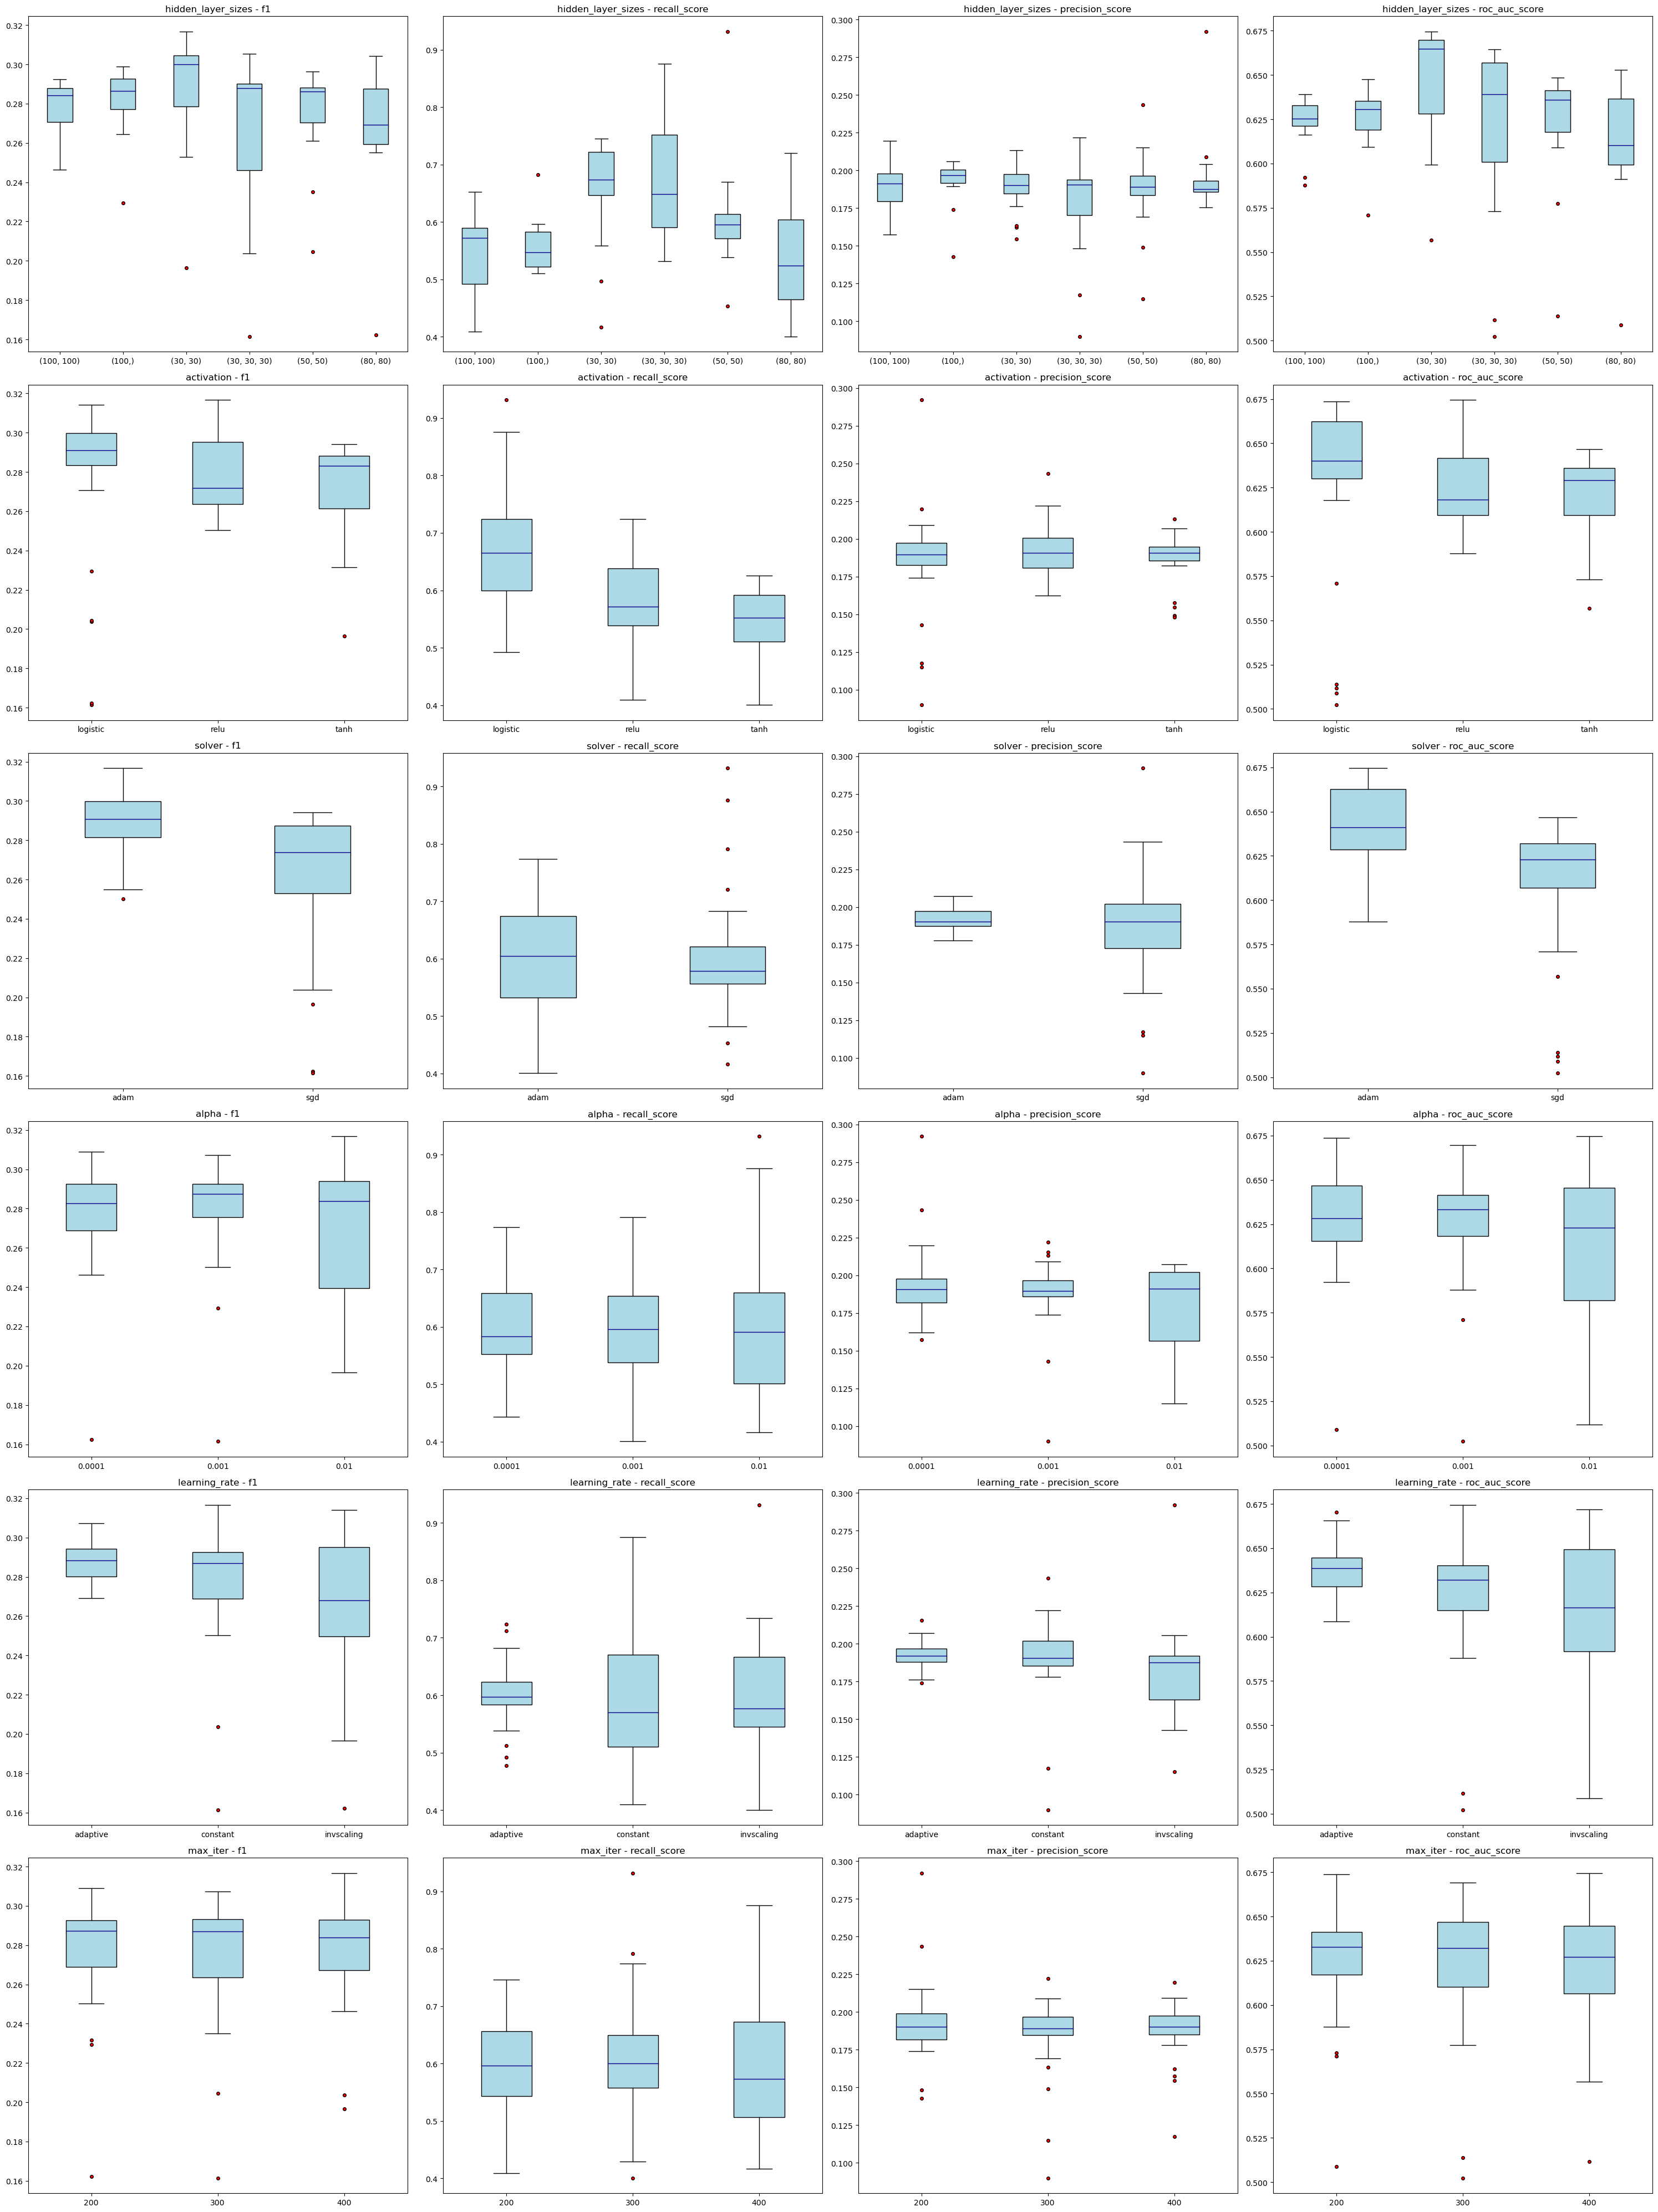

In [242]:
# num_best_models = 95

# best_models = sorted(mlp_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

# plot_metrics(mlp_result, params, best_models, figsize_param = (30,40))

In [243]:
# with open('Learning_results/mlp_model_selection.pkl', 'wb') as file:
#     pickle.dump(mlp_result, file)

In [244]:
# best_mlp = sorted(mlp_result, key = lambda x: -x[1]['f1'][1])[0]
# print('Best Model: {}'.format(best_mlp[0]))
# print('F1: {}'.format(round(best_mlp[1]['f1'][1],4)))

Best Model: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 400, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
F1: 0.3167


#### Handmade Stacking Classifier

In [464]:
# with open('Learning_results/rf_model_selection.pkl', 'rb') as file:
#     rf_result_loaded = pickle.load(file)
# with open('Learning_results/gb_model_selection.pkl', 'rb') as file:
#     gb_result_loaded = pickle.load(file)
# with open('Learning_results/adaboost_model_selection.pkl', 'rb') as file:
#     adaboost_result_loaded = pickle.load(file)
# with open('Learning_results/mlp_model_selection.pkl', 'rb') as file:
#     mlp_result_loaded = pickle.load(file)
# with open('Learning_results/sgd_svm_model_selection.pkl', 'rb') as file:
#     sgd_svm_result_loaded = pickle.load(file)
# with open('Learning_results/sgd_log_model_selection.pkl', 'rb') as file:
#     sgd_log_result_loaded = pickle.load(file)
# with open('Learning_results/gnb_model_selection.pkl', 'rb') as file:
#     gnb_result_loaded = pickle.load(file)

In [465]:
# best_rf_loaded = sorted(rf_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
# rf = RandomForestClassifier(**best_rf_loaded[0])

# best_gb_loaded = sorted(gb_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
# gb = GradientBoostingClassifier(**best_gb_loaded[0])

# best_sgd_svm_loaded = sorted(sgd_svm_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
# sgd_svm = SGDClassifier(**best_sgd_svm_loaded[0])

# best_mlp_loaded = sorted(mlp_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
# mlp = MLPClassifier(**best_mlp_loaded[0])

# best_sgd_log_loaded = sorted(sgd_log_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
# sgd_log = SGDClassifier(**best_sgd_log_loaded[0])

# best_gnb_loaded = sorted(gnb_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
# gnb = GaussianNB(**best_gnb_loaded[0])

# best_adaboost_loaded = sorted(adaboost_result_loaded, key = lambda x: -x[1]['f1'][1])[0]
# adaboost = AdaBoostClassifier(**{key: value for key, value in best_adaboost_loaded[0].items() if not key.startswith('estimator_')})


In [466]:
# models_all = [[rf, False],
#               [gb, True], 
#               [sgd_svm, False], 
#               [mlp, True], 
#               [sgd_log, False], 
#               [gnb, False], 
#               [adaboost, True]
#               ]

In [467]:
# #creation of general df for stacking and voting running each model on each fold

# full_df_stacked_train = pd.DataFrame()
# full_df_stacked_val = pd.DataFrame()

# scaling = True
# cv = 5
# multiclass = False
# upsample_type = 'simple'
# features_for_scaling_minmax_full = features_for_scaling_minmax
# upsample_size = 1

# # create stratified folds
# skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
# split = list(skf.split(data.drop(columns = target), data[target]))
# all_train_index = [i[0] for i in split]
# all_val_index = [i[1] for i in split]


# for i in tqdm(range(cv)):
#     df_stacked_train = pd.DataFrame()
#     df_stacked_val = pd.DataFrame()
#     for j in tqdm(models_all):
#         upsample = j[1]
#         val_index = all_val_index[i]
#         train_index = all_train_index[i]
#         train_data, val_data = data.loc[train_index], data.loc[val_index]
        
#         #creating features on patient level that we will use
#         train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
#         features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale
    
#         # Scaling features
#         if scaling == True:
#             if len(features_for_scaling_minmax) > 0:
#                 val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
#                 train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
#             if len(features_for_scaling_standard) > 0:
#                 val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
#                 train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')

#         y_train_general = train_data.set_index('encounter_id')[target]
#         # Upsampling only train data 
#         if upsample == True:
#             train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)
    
#         # Defining train and val datasets
#         X_train = train_data.set_index('encounter_id').drop(target, axis=1).drop(columns = ['patient_id'])
#         y_train = train_data.set_index('encounter_id')[target]
        
#         X_val = val_data.set_index('encounter_id').drop(target, axis=1).drop(columns = ['patient_id'])
#         y_val = val_data.set_index('encounter_id')[target]

#         # Fit and predict
#         model = j[0]
#         model.fit(X_train, y_train)
#         y_pred_train = model.predict(X_train)
#         y_pred_val = model.predict(X_val)

#         # print(str(model).split('(')[0], [f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])

#         X_train[target] = y_pred_train
#         X_train = X_train.drop_duplicates().sort_index()
#         X_val[target] = y_pred_val
#         X_val = X_val.drop_duplicates().sort_index()

#         if 'loss' in j[0].get_params().keys() and 'hinge' in j[0].get_params()['loss']:
#             df_stacked_train[str(model).split('(')[0] + '_SVM'] = X_train[target]
#             df_stacked_val[str(model).split('(')[0] + '_SVM'] = X_val[target]
#         else:
#             df_stacked_train[str(model).split('(')[0]] = X_train[target]
#             df_stacked_val[str(model).split('(')[0]] = X_val[target]
        
#     df_stacked_train['cv'] = i
#     df_stacked_val['cv'] = i
#     df_stacked_train[target] = y_train_general.sort_index()
#     df_stacked_val[target] = y_val.sort_index()

#     full_df_stacked_train = pd.concat([df_stacked_train, full_df_stacked_train], axis = 0)
#     full_df_stacked_val = pd.concat([df_stacked_val, full_df_stacked_val], axis = 0)

 29%|████████████▊                                | 2/7 [00:22<00:56, 11.38s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 29%|████████████▊                                | 2/7 [00:25<01:05, 13.06s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 29%|████████████▊                                | 2/7 [00:27<01:10, 14.03s/it]/Users/antonkutsenko/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(

 

In [468]:
# from itertools import combinations

# models_comb = list(combinations(full_df_stacked_train.columns.drop(['cv', 'readmitted_binary']), 2))
# models_comb.extend(list(combinations(full_df_stacked_train.columns.drop(['cv', 'readmitted_binary']), 3)))
# models_comb.extend(list(combinations(full_df_stacked_train.columns.drop(['cv', 'readmitted_binary']), 4)))
# models_comb.extend(list(combinations(full_df_stacked_train.columns.drop(['cv', 'readmitted_binary']), 5)))
# models_comb.extend(list(combinations(full_df_stacked_train.columns.drop(['cv', 'readmitted_binary']), 6)))
# models_comb.extend(list(combinations(full_df_stacked_train.columns.drop(['cv', 'readmitted_binary']), 7)))
# len(models_comb)

120

In [469]:
# stacking_results = []

# for models in tqdm(models_comb):
#     f1 = []
#     confusion_matrix_list = []
#     precision_score_list = []
#     recall_score_list = []
#     roc_auc_score_list = []
#     for i in range(cv):
#     # Defining train and val datasets
#         # add columns select 
#         X_train = full_df_stacked_train[full_df_stacked_train['cv'] == i][list(models)].fillna(0).astype(int)
#         y_train = full_df_stacked_train[full_df_stacked_train['cv'] == i][target].drop(columns = ['cv'])
            
#         X_val = full_df_stacked_val[full_df_stacked_val['cv'] == i][list(models)].fillna(0).astype(int)
#         y_val = full_df_stacked_val[full_df_stacked_val['cv'] == i][target]
    
#         model = DecisionTreeClassifier(
#             class_weight = 'balanced'
#                                   )
#         model.fit(X_train, y_train)
#         y_pred_train = model.predict(X_train)
#         y_pred_val = model.predict(X_val)

        
#         f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
#         recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
#         precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
#         roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
            
#         confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])
    
#         # Printing results
#     print(models)
#     print('F1 train: {:.4f}, F1_val: {:.4f}'.format(np.array(f1).mean(axis = 0)[0],
#                                                    np.array(f1).mean(axis = 0)[1]))
#     # print(np.round(model.coef_, 2))
#     stacking_results.append([models, 
#             {'f1' : np.array(f1).mean(axis = 0), 
#              'recall_score' : np.array(recall_score_list).mean(axis = 0),
#              'precision_score' : np.array(precision_score_list).mean(axis = 0),
#              'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
#             }, 
#             {'f1' : f1, 
#              'recall_score' : recall_score_list,
#              'precision_score' : precision_score_list,
#              'roc_auc_score' : roc_auc_score_list,
#              'confusion_matrix': confusion_matrix_list
#             },
#             X_train.columns
#             ])
#     stacking_results

  1%|▎                                          | 1/120 [00:00<00:34,  3.47it/s]

('RandomForestClassifier', 'GradientBoostingClassifier')
F1 train: 0.4686, F1_val: 0.3505


  2%|▋                                          | 2/120 [00:00<00:33,  3.56it/s]

('RandomForestClassifier', 'SGDClassifier_SVM')
F1 train: 0.4686, F1_val: 0.3505


  2%|█                                          | 3/120 [00:00<00:32,  3.59it/s]

('RandomForestClassifier', 'MLPClassifier')
F1 train: 0.4686, F1_val: 0.3505


  3%|█▍                                         | 4/120 [00:01<00:32,  3.57it/s]

('RandomForestClassifier', 'SGDClassifier')
F1 train: 0.4686, F1_val: 0.3505


  4%|█▊                                         | 5/120 [00:01<00:31,  3.60it/s]

('RandomForestClassifier', 'GaussianNB')
F1 train: 0.4686, F1_val: 0.3505


  5%|██▏                                        | 6/120 [00:01<00:31,  3.61it/s]

('RandomForestClassifier', 'AdaBoostClassifier')
F1 train: 0.4686, F1_val: 0.3505


  6%|██▌                                        | 7/120 [00:01<00:31,  3.57it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM')
F1 train: 0.3708, F1_val: 0.3387


  7%|██▊                                        | 8/120 [00:02<00:31,  3.55it/s]

('GradientBoostingClassifier', 'MLPClassifier')
F1 train: 0.3816, F1_val: 0.3365


  8%|███▏                                       | 9/120 [00:02<00:31,  3.48it/s]

('GradientBoostingClassifier', 'SGDClassifier')
F1 train: 0.3708, F1_val: 0.3387


  8%|███▌                                      | 10/120 [00:02<00:31,  3.47it/s]

('GradientBoostingClassifier', 'GaussianNB')
F1 train: 0.3708, F1_val: 0.3387


  9%|███▊                                      | 11/120 [00:03<00:31,  3.44it/s]

('GradientBoostingClassifier', 'AdaBoostClassifier')
F1 train: 0.3731, F1_val: 0.3386


 10%|████▏                                     | 12/120 [00:03<00:31,  3.43it/s]

('SGDClassifier_SVM', 'MLPClassifier')
F1 train: 0.3597, F1_val: 0.3084


 11%|████▌                                     | 13/120 [00:03<00:30,  3.48it/s]

('SGDClassifier_SVM', 'SGDClassifier')
F1 train: 0.3038, F1_val: 0.3095


 12%|████▉                                     | 14/120 [00:03<00:30,  3.51it/s]

('SGDClassifier_SVM', 'GaussianNB')
F1 train: 0.2896, F1_val: 0.2891


 12%|█████▎                                    | 15/120 [00:04<00:29,  3.51it/s]

('SGDClassifier_SVM', 'AdaBoostClassifier')
F1 train: 0.3613, F1_val: 0.3316


 13%|█████▌                                    | 16/120 [00:04<00:29,  3.48it/s]

('MLPClassifier', 'SGDClassifier')
F1 train: 0.3597, F1_val: 0.3084


 14%|█████▉                                    | 17/120 [00:04<00:29,  3.49it/s]

('MLPClassifier', 'GaussianNB')
F1 train: 0.3597, F1_val: 0.3084


 15%|██████▎                                   | 18/120 [00:05<00:29,  3.49it/s]

('MLPClassifier', 'AdaBoostClassifier')
F1 train: 0.3653, F1_val: 0.3221


 16%|██████▋                                   | 19/120 [00:05<00:28,  3.56it/s]

('SGDClassifier', 'GaussianNB')
F1 train: 0.3205, F1_val: 0.3258


 17%|███████                                   | 20/120 [00:05<00:28,  3.55it/s]

('SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.3613, F1_val: 0.3316


 18%|███████▎                                  | 21/120 [00:06<00:29,  3.35it/s]

('GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3613, F1_val: 0.3316


 18%|███████▋                                  | 22/120 [00:06<00:28,  3.39it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM')
F1 train: 0.4686, F1_val: 0.3505


 19%|████████                                  | 23/120 [00:06<00:28,  3.39it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier')
F1 train: 0.4686, F1_val: 0.3505


 20%|████████▍                                 | 24/120 [00:06<00:27,  3.43it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier')
F1 train: 0.4686, F1_val: 0.3505


 21%|████████▊                                 | 25/120 [00:07<00:27,  3.45it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB')
F1 train: 0.4686, F1_val: 0.3505


 22%|█████████                                 | 26/120 [00:07<00:30,  3.05it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier')
F1 train: 0.4686, F1_val: 0.3505


 22%|█████████▍                                | 27/120 [00:07<00:29,  3.16it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier')
F1 train: 0.4684, F1_val: 0.3501


 23%|█████████▊                                | 28/120 [00:08<00:28,  3.27it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier')
F1 train: 0.4686, F1_val: 0.3505


 24%|██████████▏                               | 29/120 [00:08<00:27,  3.35it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB')
F1 train: 0.4686, F1_val: 0.3505


 25%|██████████▌                               | 30/120 [00:08<00:26,  3.35it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier')
F1 train: 0.4688, F1_val: 0.3506


 26%|██████████▊                               | 31/120 [00:09<00:27,  3.29it/s]

('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier')
F1 train: 0.4698, F1_val: 0.3499


 27%|███████████▏                              | 32/120 [00:09<00:26,  3.36it/s]

('RandomForestClassifier', 'MLPClassifier', 'GaussianNB')
F1 train: 0.4740, F1_val: 0.3478


 28%|███████████▌                              | 33/120 [00:09<00:25,  3.41it/s]

('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier')
F1 train: 0.4686, F1_val: 0.3505


 28%|███████████▉                              | 34/120 [00:09<00:24,  3.46it/s]

('RandomForestClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.4686, F1_val: 0.3505


 29%|████████████▎                             | 35/120 [00:10<00:24,  3.49it/s]

('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.4728, F1_val: 0.3485


 30%|████████████▌                             | 36/120 [00:10<00:23,  3.52it/s]

('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4725, F1_val: 0.3490


 31%|████████████▉                             | 37/120 [00:10<00:23,  3.50it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier')
F1 train: 0.3864, F1_val: 0.3361


 32%|█████████████▎                            | 38/120 [00:11<00:23,  3.48it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier')
F1 train: 0.3708, F1_val: 0.3387


 32%|█████████████▋                            | 39/120 [00:11<00:23,  3.46it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB')
F1 train: 0.3708, F1_val: 0.3387


 33%|██████████████                            | 40/120 [00:11<00:23,  3.41it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier')
F1 train: 0.3759, F1_val: 0.3393


 34%|██████████████▎                           | 41/120 [00:11<00:23,  3.42it/s]

('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier')
F1 train: 0.3804, F1_val: 0.3351


 35%|██████████████▋                           | 42/120 [00:12<00:22,  3.44it/s]

('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB')
F1 train: 0.3816, F1_val: 0.3359


 36%|███████████████                           | 43/120 [00:12<00:22,  3.45it/s]

('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier')
F1 train: 0.3835, F1_val: 0.3378


 37%|███████████████▍                          | 44/120 [00:12<00:21,  3.46it/s]

('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.3708, F1_val: 0.3387


 38%|███████████████▊                          | 45/120 [00:13<00:21,  3.46it/s]

('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.3753, F1_val: 0.3369


 38%|████████████████                          | 46/120 [00:13<00:21,  3.46it/s]

('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3750, F1_val: 0.3374


 39%|████████████████▍                         | 47/120 [00:13<00:21,  3.45it/s]

('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier')
F1 train: 0.3595, F1_val: 0.3084


 40%|████████████████▊                         | 48/120 [00:13<00:20,  3.45it/s]

('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB')
F1 train: 0.3597, F1_val: 0.3084


 41%|█████████████████▏                        | 49/120 [00:14<00:20,  3.45it/s]

('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier')
F1 train: 0.3719, F1_val: 0.3223


 42%|█████████████████▌                        | 50/120 [00:14<00:20,  3.47it/s]

('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB')
F1 train: 0.3068, F1_val: 0.3098


 42%|█████████████████▊                        | 51/120 [00:14<00:19,  3.47it/s]

('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.3613, F1_val: 0.3316


 43%|██████████████████▏                       | 52/120 [00:15<00:19,  3.47it/s]

('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3613, F1_val: 0.3316


 44%|██████████████████▌                       | 53/120 [00:15<00:19,  3.46it/s]

('MLPClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.3597, F1_val: 0.3084


 45%|██████████████████▉                       | 54/120 [00:15<00:19,  3.45it/s]

('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.3704, F1_val: 0.3196


 46%|███████████████████▎                      | 55/120 [00:15<00:18,  3.45it/s]

('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3696, F1_val: 0.3207


 47%|███████████████████▌                      | 56/120 [00:16<00:18,  3.44it/s]

('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3613, F1_val: 0.3316


 48%|███████████████████▉                      | 57/120 [00:16<00:18,  3.45it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier')
F1 train: 0.4709, F1_val: 0.3493


 48%|████████████████████▎                     | 58/120 [00:16<00:17,  3.46it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier')
F1 train: 0.4686, F1_val: 0.3505


 49%|████████████████████▋                     | 59/120 [00:17<00:17,  3.45it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB')
F1 train: 0.4686, F1_val: 0.3505


 50%|█████████████████████                     | 60/120 [00:17<00:17,  3.45it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier')
F1 train: 0.4688, F1_val: 0.3506


 51%|█████████████████████▎                    | 61/120 [00:17<00:17,  3.46it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier')
F1 train: 0.4698, F1_val: 0.3499


 52%|█████████████████████▋                    | 62/120 [00:17<00:16,  3.44it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB')
F1 train: 0.4740, F1_val: 0.3478


 52%|██████████████████████                    | 63/120 [00:18<00:16,  3.44it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier')
F1 train: 0.4686, F1_val: 0.3505


 53%|██████████████████████▍                   | 64/120 [00:18<00:16,  3.45it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.4686, F1_val: 0.3505


 54%|██████████████████████▊                   | 65/120 [00:18<00:15,  3.47it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.4731, F1_val: 0.3485


 55%|███████████████████████                   | 66/120 [00:19<00:15,  3.47it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4727, F1_val: 0.3490


 56%|███████████████████████▍                  | 67/120 [00:19<00:15,  3.47it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier')
F1 train: 0.4695, F1_val: 0.3493


 57%|███████████████████████▊                  | 68/120 [00:19<00:15,  3.46it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB')
F1 train: 0.4731, F1_val: 0.3473


 57%|████████████████████████▏                 | 69/120 [00:20<00:14,  3.46it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier')
F1 train: 0.4703, F1_val: 0.3492


 58%|████████████████████████▌                 | 70/120 [00:20<00:14,  3.47it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB')
F1 train: 0.4686, F1_val: 0.3505


 59%|████████████████████████▊                 | 71/120 [00:20<00:14,  3.47it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.4728, F1_val: 0.3489


 60%|█████████████████████████▏                | 72/120 [00:20<00:13,  3.47it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4724, F1_val: 0.3490


 61%|█████████████████████████▌                | 73/120 [00:21<00:13,  3.48it/s]

('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.4746, F1_val: 0.3469


 62%|█████████████████████████▉                | 74/120 [00:21<00:13,  3.47it/s]

('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.4740, F1_val: 0.3478


 62%|██████████████████████████▎               | 75/120 [00:21<00:12,  3.47it/s]

('RandomForestClassifier', 'MLPClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4773, F1_val: 0.3463


 63%|██████████████████████████▌               | 76/120 [00:22<00:12,  3.47it/s]

('RandomForestClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4728, F1_val: 0.3483


 64%|██████████████████████████▉               | 77/120 [00:22<00:12,  3.43it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier')
F1 train: 0.3808, F1_val: 0.3309


 65%|███████████████████████████▎              | 78/120 [00:22<00:12,  3.41it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB')
F1 train: 0.3758, F1_val: 0.3279


 66%|███████████████████████████▋              | 79/120 [00:22<00:12,  3.33it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier')
F1 train: 0.3822, F1_val: 0.3294


 67%|████████████████████████████              | 80/120 [00:23<00:11,  3.34it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB')
F1 train: 0.3708, F1_val: 0.3387


 68%|████████████████████████████▎             | 81/120 [00:23<00:11,  3.34it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.3771, F1_val: 0.3376


 68%|████████████████████████████▋             | 82/120 [00:23<00:11,  3.28it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3765, F1_val: 0.3374


 69%|█████████████████████████████             | 83/120 [00:24<00:11,  3.26it/s]

('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.3828, F1_val: 0.3352


 70%|█████████████████████████████▍            | 84/120 [00:24<00:10,  3.29it/s]

('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.3790, F1_val: 0.3256


 71%|█████████████████████████████▊            | 85/120 [00:24<00:10,  3.31it/s]

('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3788, F1_val: 0.3265


 72%|██████████████████████████████            | 86/120 [00:25<00:10,  3.30it/s]

('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3768, F1_val: 0.3370


 72%|██████████████████████████████▍           | 87/120 [00:25<00:10,  3.29it/s]

('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.3596, F1_val: 0.3086


 73%|██████████████████████████████▊           | 88/120 [00:25<00:09,  3.30it/s]

('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.3747, F1_val: 0.3212


 74%|███████████████████████████████▏          | 89/120 [00:26<00:09,  3.11it/s]

('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3748, F1_val: 0.3216


 75%|███████████████████████████████▌          | 90/120 [00:26<00:09,  3.16it/s]

('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3613, F1_val: 0.3316


 76%|███████████████████████████████▊          | 91/120 [00:26<00:09,  3.20it/s]

('MLPClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3720, F1_val: 0.3199


 77%|████████████████████████████████▏         | 92/120 [00:26<00:08,  3.17it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier')
F1 train: 0.4700, F1_val: 0.3495


 78%|████████████████████████████████▌         | 93/120 [00:27<00:08,  3.16it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB')
F1 train: 0.4735, F1_val: 0.3475


 78%|████████████████████████████████▉         | 94/120 [00:27<00:08,  3.19it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier')
F1 train: 0.4705, F1_val: 0.3493


 79%|█████████████████████████████████▎        | 95/120 [00:27<00:07,  3.25it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB')
F1 train: 0.4686, F1_val: 0.3505


 80%|█████████████████████████████████▌        | 96/120 [00:28<00:07,  3.16it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.4731, F1_val: 0.3489


 81%|█████████████████████████████████▉        | 97/120 [00:28<00:07,  3.21it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4725, F1_val: 0.3489


 82%|██████████████████████████████████▎       | 98/120 [00:28<00:06,  3.26it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.4746, F1_val: 0.3469


 82%|██████████████████████████████████▋       | 99/120 [00:29<00:06,  3.29it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.4743, F1_val: 0.3477


 83%|██████████████████████████████████▏      | 100/120 [00:29<00:06,  3.29it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4776, F1_val: 0.3463


 84%|██████████████████████████████████▌      | 101/120 [00:29<00:05,  3.32it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4734, F1_val: 0.3484


 85%|██████████████████████████████████▊      | 102/120 [00:30<00:05,  3.34it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.4738, F1_val: 0.3462


 86%|███████████████████████████████████▏     | 103/120 [00:30<00:05,  3.35it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.4740, F1_val: 0.3479


 87%|███████████████████████████████████▌     | 104/120 [00:30<00:04,  3.36it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4768, F1_val: 0.3460


 88%|███████████████████████████████████▉     | 105/120 [00:30<00:04,  3.37it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4732, F1_val: 0.3483


 88%|████████████████████████████████████▏    | 106/120 [00:31<00:04,  3.37it/s]

('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4776, F1_val: 0.3453


 89%|████████████████████████████████████▌    | 107/120 [00:31<00:03,  3.33it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.3761, F1_val: 0.3281


 90%|████████████████████████████████████▉    | 108/120 [00:31<00:03,  3.31it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.3815, F1_val: 0.3257


 91%|█████████████████████████████████████▏   | 109/120 [00:32<00:03,  3.29it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3816, F1_val: 0.3273


 92%|█████████████████████████████████████▌   | 110/120 [00:32<00:03,  3.29it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3776, F1_val: 0.3373


 92%|█████████████████████████████████████▉   | 111/120 [00:32<00:02,  3.29it/s]

('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3806, F1_val: 0.3248


 93%|██████████████████████████████████████▎  | 112/120 [00:33<00:02,  3.28it/s]

('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3688, F1_val: 0.3164


 94%|██████████████████████████████████████▌  | 113/120 [00:33<00:02,  3.29it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'GaussianNB')
F1 train: 0.4742, F1_val: 0.3464


 95%|██████████████████████████████████████▉  | 114/120 [00:33<00:01,  3.28it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier')
F1 train: 0.4743, F1_val: 0.3479


 96%|███████████████████████████████████████▎ | 115/120 [00:33<00:01,  3.28it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4772, F1_val: 0.3461


 97%|███████████████████████████████████████▋ | 116/120 [00:34<00:01,  3.29it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4735, F1_val: 0.3484


 98%|███████████████████████████████████████▉ | 117/120 [00:34<00:00,  3.29it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4780, F1_val: 0.3452


 98%|████████████████████████████████████████▎| 118/120 [00:34<00:00,  3.29it/s]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4782, F1_val: 0.3441


 99%|████████████████████████████████████████▋| 119/120 [00:35<00:00,  3.27it/s]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.3819, F1_val: 0.3265


100%|█████████████████████████████████████████| 120/120 [00:35<00:00,  3.38it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier', 'GaussianNB', 'AdaBoostClassifier')
F1 train: 0.4786, F1_val: 0.3442


In [470]:
# stacking_results

# num_best_models = 95

# best_models = sorted(stacking_results, key = lambda x: -x[1]['f1'][1])[:num_best_models]

# best_models[0]

[('RandomForestClassifier',
  'GradientBoostingClassifier',
  'SGDClassifier_SVM',
  'AdaBoostClassifier'),
 {'f1': array([0.46883855, 0.35059923]),
  'recall_score': array([0.77990566, 0.62477987]),
  'precision_score': array([0.33516279, 0.24372562]),
  'roc_auc_score': array([0.79277889, 0.69059367])},
 {'f1': [[0.4703321661777231, 0.3400352733686067],
   [0.4691171613268531, 0.3530222145686241],
   [0.46827979812273, 0.3558091286307054],
   [0.4657353840364988, 0.3511669658886894],
   [0.47072822465492614, 0.3529625590694293]],
  'recall_score': [[0.7814465408805031, 0.6062893081761006],
   [0.7816037735849056, 0.6446540880503144],
   [0.7805031446540881, 0.6471698113207547],
   [0.7784591194968553, 0.6150943396226415],
   [0.7775157232704403, 0.610691823899371]],
  'precision_score': [[0.3364017869229728, 0.23627450980392156],
   [0.3351311265421695, 0.24306378942376097],
   [0.3344788087056128, 0.2453505007153076],
   [0.33225957989396687, 0.2457286432160804],
   [0.3375426621160

#### Weighted voting

In [474]:
# from itertools import combinations

# models_comb = list(combinations(full_df_stacked_train.columns.drop(['cv', 'readmitted_binary']), 3))

In [477]:
# import itertools

# step = 0.25
# combinations = list(itertools.product(np.arange(0, 1 + step, step), repeat=3))
# valid_combinations = [combo for combo in combinations if np.isclose(np.sum(combo), 1)]
# len(valid_combinations)


15

In [478]:
# weighted_voting_results = []

# for models in tqdm(models_comb):
#     for k in valid_combinations:
#         f1 = []
#         confusion_matrix_list = []
#         precision_score_list = []
#         recall_score_list = []
#         roc_auc_score_list = []
#         for i in range(cv):
#         # Defining train and val datasets
#             # add columns select 
#             X_train = full_df_stacked_train[full_df_stacked_train['cv'] == i][list(models)].fillna(0).astype(int)
#             y_train = full_df_stacked_train[full_df_stacked_train['cv'] == i][target].drop(columns = ['cv'])
                
#             X_val = full_df_stacked_val[full_df_stacked_val['cv'] == i][list(models)].fillna(0).astype(int)
#             y_val = full_df_stacked_val[full_df_stacked_val['cv'] == i][target]
    
#             y_pred_train = np.round(np.sum(X_train * k, axis = 1))
#             y_pred_val = np.round(np.sum(X_val * k, axis = 1))
            
#             f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
#             recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
#             precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
#             roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
                
#             confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])
        
#             # Printing results
#         print(models, k)
#         print('F1 train: {:.4f}, F1_val: {:.4f}'.format(np.array(f1).mean(axis = 0)[0],
#                                                        np.array(f1).mean(axis = 0)[1]))
#         # print(np.round(model.coef_, 2))
#         weighted_voting_results.append([models, 
#                 {'f1' : np.array(f1).mean(axis = 0), 
#                  'recall_score' : np.array(recall_score_list).mean(axis = 0),
#                  'precision_score' : np.array(precision_score_list).mean(axis = 0),
#                  'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
#                 }, 
#                 {'f1' : f1, 
#                  'recall_score' : recall_score_list,
#                  'precision_score' : precision_score_list,
#                  'roc_auc_score' : roc_auc_score_list,
#                  'confusion_matrix': confusion_matrix_list
#                 },
#                 k
#                 ])

  0%|                                                    | 0/35 [00:00<?, ?it/s]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (0.0, 0.0, 1.0)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (0.0, 0.25, 0.75)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (0.0, 0.5, 0.5)
F1 train: 0.3242, F1_val: 0.3104
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (0.0, 0.75, 0.25)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (0.0, 1.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (0.25, 0.0, 0.75)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (0.25, 0.25, 0.5)
F1 train: 0.3282, F1_val: 0.3104
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (0.25, 0.5, 0.25)
F1 trai

  3%|█▎                                          | 1/35 [00:05<02:58,  5.25s/it]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier_SVM') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3927, F1_val: 0.3371
('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3984, F1_val: 0.3371
('Ra

  6%|██▌                                         | 2/35 [00:10<02:53,  5.26s/it]

('RandomForestClassifier', 'GradientBoostingClassifier', 'MLPClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3216, F1_val: 0.3276
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3224, F1_val: 0.3276
('Random

  9%|███▊                                        | 3/35 [00:15<02:47,  5.23s/it]

('RandomForestClassifier', 'GradientBoostingClassifier', 'SGDClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2849, F1_val: 0.2743
('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2854, F1_val: 0.2743
('RandomForestClassifier', 'G

 11%|█████                                       | 4/35 [00:20<02:40,  5.19s/it]

('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3805, F1_val: 0.3404
('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train:

 14%|██████▎                                     | 5/35 [00:26<02:36,  5.23s/it]

('RandomForestClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3216, F1_val: 0.2936
('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.25, 0.25, 0.5)
F1 train: 0.4051, F1_val: 0.3263
('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (

 17%|███████▌                                    | 6/35 [00:31<02:31,  5.21s/it]

('RandomForestClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 0.5, 0.5)
F1 train: 0.2825, F1_val: 0.2976
('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3244, F1_val: 0.3250
('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.25, 0.5, 0.2

 20%|████████▊                                   | 7/35 [00:36<02:24,  5.17s/it]

('RandomForestClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2457, F1_val: 0.2508
('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2907, F1_val: 0.2727
('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.25, 0.5, 0.25)
F1 train: 0.3710, F1_

 23%|██████████                                  | 8/35 [00:41<02:18,  5.14s/it]

('RandomForestClassifier', 'SGDClassifier_SVM', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3206, F1_val: 0.3081
('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.4004, F1_val: 0.3387
('RandomForestClassifier', 'SGDClassifier_SVM', 

 26%|███████████▎                                | 9/35 [00:46<02:14,  5.16s/it]

('RandomForestClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3242, F1_val: 0.3187
('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3227, F1_val: 0.3262
('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (0.25, 0.5, 0.25)
F1 train: 0.4396, F1_val

 29%|████████████▎                              | 10/35 [00:51<02:08,  5.15s/it]

('RandomForestClassifier', 'MLPClassifier', 'SGDClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2915, F1_val: 0.2654
('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2880, F1_val: 0.2737
('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (0.25, 0.5, 0.25)
F1 train: 0.4500, F1_val: 0.3447
('RandomForestClassifier

 31%|█████████████▌                             | 11/35 [00:56<02:03,  5.13s/it]

('RandomForestClassifier', 'MLPClassifier', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3874, F1_val: 0.3318
('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3902, F1_val: 0.3389
('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.25, 0.5, 0.

 34%|██████████████▋                            | 12/35 [01:02<01:59,  5.18s/it]

('RandomForestClassifier', 'MLPClassifier', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2626, F1_val: 0.2707
('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2959, F1_val: 0.2739
('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.5, 0.25)
F1 train: 0.3410, F1_val: 0.3287
('RandomForestClass

 37%|███████████████▉                           | 13/35 [01:07<01:52,  5.11s/it]

('RandomForestClassifier', 'SGDClassifier', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3233, F1_val: 0.3226
('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250
('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.4319, F1_val: 0.3461
('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.5, 0.

 40%|█████████████████▏                         | 14/35 [01:12<01:47,  5.12s/it]

('RandomForestClassifier', 'SGDClassifier', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.2884, F1_val: 0.2704
('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2786, F1_val: 0.2738
('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.4419, F1_val: 0.3492
('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.5, 0.25)
F1 train: 0.

 43%|██████████████████▍                        | 15/35 [01:17<01:42,  5.11s/it]

('RandomForestClassifier', 'GaussianNB', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.4686, F1_val: 0.3505
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3216, F1_val: 0.2936
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2644, F1_val: 0.2687
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3774, F1_val: 0.3256
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'M

 46%|███████████████████▋                       | 16/35 [01:22<01:38,  5.17s/it]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'MLPClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 0.5, 0.5)
F1 train: 0.2825, F1_val: 0.2976
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2644, F1_val: 0.2687
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3169, F1_val: 0.3262
('GradientBoostingClassifier', 'SGDClassifier_SV

 49%|████████████████████▉                      | 17/35 [01:27<01:33,  5.17s/it]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'SGDClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2457, F1_val: 0.2508
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.2644, F1_val: 0.2687
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2833, F1_val: 0.2743
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (0.

 51%|██████████████████████                     | 18/35 [01:32<01:27,  5.15s/it]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3206, F1_val: 0.3081
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2644, F1_val: 0.2687
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3710, F1_val: 0.3368
('GradientBoosti

 54%|███████████████████████▎                   | 19/35 [01:38<01:23,  5.20s/it]

('GradientBoostingClassifier', 'SGDClassifier_SVM', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3242, F1_val: 0.3187
('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3176, F1_val: 0.3263
('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (0.25,

 57%|████████████████████████▌                  | 20/35 [01:43<01:18,  5.21s/it]

('GradientBoostingClassifier', 'MLPClassifier', 'SGDClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2915, F1_val: 0.2654
('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2827, F1_val: 0.2744
('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (0.25, 0.5, 0.25)
F1 train: 0.3906, F1_

 60%|█████████████████████████▊                 | 21/35 [01:48<01:12,  5.19s/it]

('GradientBoostingClassifier', 'MLPClassifier', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3874, F1_val: 0.3318
('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3706, F1_val: 0.3364
('GradientBoostingClassifier', 'MLPClassifier', 

 63%|███████████████████████████                | 22/35 [01:53<01:07,  5.22s/it]

('GradientBoostingClassifier', 'MLPClassifier', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2626, F1_val: 0.2707
('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2845, F1_val: 0.2742
('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.5, 0.25)
F1 train: 0.3212

 66%|████████████████████████████▎              | 23/35 [01:59<01:02,  5.17s/it]

('GradientBoostingClassifier', 'SGDClassifier', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3233, F1_val: 0.3226
('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250
('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3770, F1_val: 0.3390
('GradientBoostingClassifier', 'SGDClassifier', 

 69%|█████████████████████████████▍             | 24/35 [02:04<00:57,  5.19s/it]

('GradientBoostingClassifier', 'SGDClassifier', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.2884, F1_val: 0.2704
('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2786, F1_val: 0.2738
('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3786, F1_val: 0.3404
('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassif

 71%|██████████████████████████████▋            | 25/35 [02:09<00:51,  5.19s/it]

('GradientBoostingClassifier', 'GaussianNB', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3708, F1_val: 0.3387
('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3137, F1_val: 0.3250
('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3242, F1_val: 0.3187
('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3137, F1_val: 0.3250
('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3166, F1_val: 0.3242
('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (0.25, 0.5, 0.25)
F1 train: 0.3453, F1_val: 0.3156
('SGDClassifier_SVM', 'MLPClassifi

 74%|███████████████████████████████▉           | 26/35 [02:14<00:46,  5.21s/it]

('SGDClassifier_SVM', 'MLPClassifier', 'SGDClassifier') (1.0, 0.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2915, F1_val: 0.2654
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2846, F1_val: 0.2734
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.25, 0.5, 0.25)
F1 train: 0.3427, F1_val: 0.3063
('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (0.25, 0.75, 0.0

 77%|█████████████████████████████████▏         | 27/35 [02:20<00:42,  5.34s/it]

('SGDClassifier_SVM', 'MLPClassifier', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3874, F1_val: 0.3318
('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3597, F1_val: 0.3084
('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3722, F1_val: 0.3339
('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (0.25, 0.5, 0.25)
F1 train: 0.3734, F1_val: 0.3223
('SGDCla

 80%|██████████████████████████████████▍        | 28/35 [02:25<00:37,  5.32s/it]

('SGDClassifier_SVM', 'MLPClassifier', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2626, F1_val: 0.2707
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.3137, F1_val: 0.3250
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2725, F1_val: 0.2728
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.25, 0.5, 0.25)
F1 train: 0.3035, F1_val: 0.3131
('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (0.25, 0.75

 83%|███████████████████████████████████▋       | 29/35 [02:30<00:31,  5.27s/it]

('SGDClassifier_SVM', 'SGDClassifier', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3233, F1_val: 0.3226
('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3137, F1_val: 0.3250
('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250
('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3439, F1_val: 0.3285
('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.5, 0.25)
F1 train: 0.3167, F1_val: 0.3242
('SGDCla

 86%|████████████████████████████████████▊      | 30/35 [02:35<00:26,  5.23s/it]

('SGDClassifier_SVM', 'SGDClassifier', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.2884, F1_val: 0.2704
('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3402, F1_val: 0.3194
('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.5, 0.25)
F1 train: 0.2834, F1_val: 0.2727
('SGDClassifier_SVM', 'G

 89%|██████████████████████████████████████     | 31/35 [02:41<00:20,  5.21s/it]

('SGDClassifier_SVM', 'GaussianNB', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.2644, F1_val: 0.2687
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.0, 1.0)
F1 train: 0.2786, F1_val: 0.2738
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.25, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.5, 0.5)
F1 train: 0.2626, F1_val: 0.2707
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 0.75, 0.25)
F1 train: 0.3137, F1_val: 0.3250
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.0, 1.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.0, 0.75)
F1 train: 0.2786, F1_val: 0.2738
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.25, 0.5)
F1 train: 0.2872, F1_val: 0.2744
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.5, 0.25)
F1 train: 0.3197, F1_val: 0.3238
('MLPClassifier', 'SGDClassifier', 'GaussianNB') (0.25, 0.75, 0.0)
F1 train: 0.3137, F1_val: 0.3250

 91%|███████████████████████████████████████▎   | 32/35 [02:46<00:15,  5.16s/it]

('MLPClassifier', 'SGDClassifier', 'GaussianNB') (1.0, 0.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.3233, F1_val: 0.3226
('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.3137, F1_val: 0.3250
('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250
('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3804, F1_val: 0.3360
('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (0.25, 0.5, 0.25)
F1 train: 0.3168, F1_val: 0.3253
('MLPClassifier', 'SGDClassifier', 'AdaBoost

 94%|████████████████████████████████████████▌  | 33/35 [02:51<00:10,  5.18s/it]

('MLPClassifier', 'SGDClassifier', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.2884, F1_val: 0.2704
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2786, F1_val: 0.2738
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2786, F1_val: 0.2738
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3795, F1_val: 0.3348
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.5, 0.25)
F1 train: 0.2830, F1_val: 0.2741
('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25,

 97%|█████████████████████████████████████████▊ | 34/35 [02:56<00:05,  5.18s/it]

('MLPClassifier', 'GaussianNB', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3597, F1_val: 0.3084
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.0, 1.0)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.25, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.5, 0.5)
F1 train: 0.2884, F1_val: 0.2704
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 0.75, 0.25)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.0, 1.0, 0.0)
F1 train: 0.2786, F1_val: 0.2738
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.0, 0.75)
F1 train: 0.3613, F1_val: 0.3316
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.25, 0.5)
F1 train: 0.3349, F1_val: 0.3241
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.5, 0.25)
F1 train: 0.2843, F1_val: 0.2742
('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (0.25, 0.

100%|███████████████████████████████████████████| 35/35 [03:01<00:00,  5.19s/it]

('SGDClassifier', 'GaussianNB', 'AdaBoostClassifier') (1.0, 0.0, 0.0)
F1 train: 0.3137, F1_val: 0.3250


In [479]:
# best_models = sorted(weighted_voting_results, key = lambda x: -x[1]['f1'][1])

# best_models[0]

[('RandomForestClassifier', 'GradientBoostingClassifier', 'GaussianNB'),
 {'f1': array([0.43992815, 0.35160523]),
  'recall_score': array([0.75540881, 0.64062893]),
  'precision_score': array([0.31035987, 0.24233251]),
  'roc_auc_score': array([0.77222293, 0.69447309])},
 {'f1': [[0.43673469387755104, 0.34001027221366203],
   [0.4347355606654944, 0.35521628498727736],
   [0.444536767760698, 0.3554413024850043],
   [0.43570485684373433, 0.35397619458340523],
   [0.4479288556049614, 0.353382116723184]],
  'recall_score': [[0.7570754716981132, 0.6245283018867924],
   [0.7580188679245283, 0.6584905660377358],
   [0.7570754716981132, 0.6522012578616352],
   [0.7525157232704403, 0.6452830188679245],
   [0.7523584905660378, 0.6226415094339622]],
  'precision_score': [[0.3068833652007648, 0.2335920959774171],
   [0.30476009861558884, 0.243205574912892],
   [0.3146441874142325, 0.24428739693757362],
   [0.30661797680825165, 0.2438792488709294],
   [0.31889370209930024, 0.2466982307500623]],
  '

#### Plot of all results

In [480]:
# best_weighted_voting = sorted(weighted_voting_results, key = lambda x: -x[1]['f1'][1])[:num_best_models][0]
# best_stacking = sorted(stacking_results, key = lambda x: -x[1]['f1'][1])[:num_best_models][0]

In [492]:
# model_names = ['RF',
#                'GB',
#                'SGD_SVM',
#                'MLP',
#                'SGD_Log',
#                'GNB',
#                'AdaBoost',
#                'Stacking',
#                'Weighted Voting']

In [493]:
# all_best_models = [best_rf_loaded,
#                    best_gb_loaded,
#                    best_sgd_svm_loaded,
#                    best_mlp_loaded,
#                    best_sgd_log_loaded,
#                    best_gnb_loaded,
#                    best_adaboost_loaded,
#                    best_stacking,
#                    best_weighted_voting]
                   

In [494]:
# f1_scores = []
# stds = []
# for i in all_best_models:
#     f1_scores.append(i[1]['f1'][1])
#     stds.append(np.std([row[1] for row in i[2]['f1']]))

In [495]:
# data_for_plot = pd.DataFrame(list(zip(model_names, f1_scores, stds)), columns = ['model', 'f1', 'std'])
# data_for_plot = data_for_plot.sort_values('f1', ascending = False)

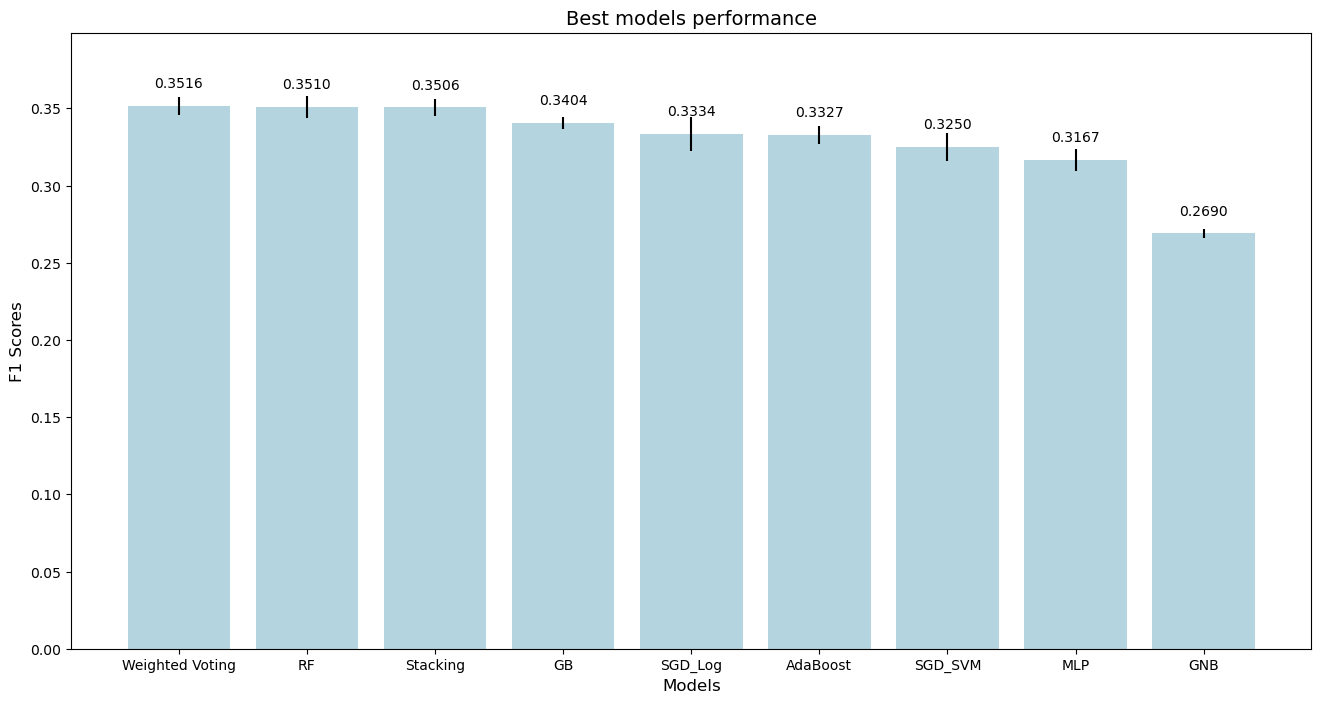

In [496]:
# import matplotlib as mpl

# mpl.rcParams.update({
#     'font.size': 12,            # Main font size
#     'axes.labelsize': 12,       # Font size of axis labels
#     'axes.titlesize': 14,       # Font size of plot title
#     'xtick.labelsize': 10,      # Font size of x-axis tick labels
#     'ytick.labelsize': 10,      # Font size of y-axis tick labels
#     'legend.fontsize': 10,      # Font size of legend
# })

# plt.figure(figsize=(16, 8))
# bar = sns.barplot(x=data_for_plot['model'], y=data_for_plot['f1'], 
#                  capsize=0.2, errwidth=1, 
#                  color="lightblue"
#                 )


# for i in range(len(data_for_plot)):
#     bar.errorbar(i, data_for_plot.iloc[i]['f1'], yerr=data_for_plot.iloc[i]['std'],  color='black', )
#     f1 = data_for_plot.iloc[i]['f1']

#     bar.text(i, f1 + 0.01, f'{f1:.4f}', ha='center', va='bottom', color='black', fontsize = 10)



# plt.xlabel('Models')
# plt.ylabel('F1 Scores')
# plt.title('Best models performance')
# plt.ylim(0, 0.399)


# plt.show()

In [486]:
# precisions = []
# stds = []
# for i in all_best_models:
#     precisions.append(i[1]['precision_score'][1])
#     stds.append(np.std([row[1] for row in i[2]['precision_score']]))

In [487]:
# data_for_plot = pd.DataFrame(list(zip(model_names, precisions, stds)), columns = ['model', 'precision_score', 'std'])
# data_for_plot = data_for_plot.sort_values('precision_score', ascending = False)

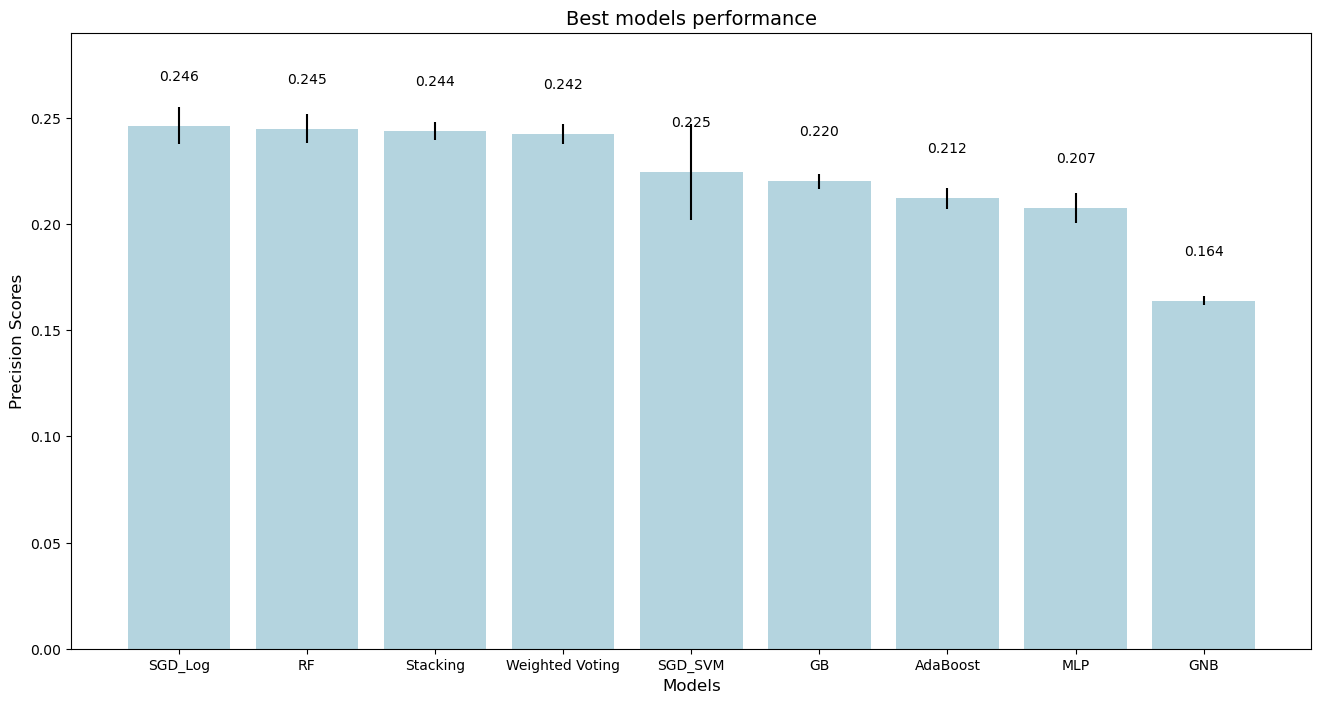

In [488]:
# plt.figure(figsize=(16, 8))
# bar = sns.barplot(x=data_for_plot['model'], y=data_for_plot['precision_score'], 
#                  capsize=0.2, errwidth=1, 
#                  color="lightblue"
#                 )

# for i in range(len(data_for_plot)):
#     bar.errorbar(i, data_for_plot.iloc[i]['precision_score'], yerr=data_for_plot.iloc[i]['std'],  color='black', )
#     f1 = data_for_plot.iloc[i]['precision_score']

#     bar.text(i, f1 + 0.02, f'{f1:.3f}', ha='center', va='bottom', color='black', fontsize = 10)


# # Set labels and title
# plt.xlabel('Models')
# plt.ylabel('Precision Scores')
# plt.title('Best models performance')
# plt.ylim(0, 0.29)


# # Show the plot
# plt.show()

In [489]:
# recalls = []
# stds = []
# for i in all_best_models:
#     recalls.append(i[1]['recall_score'][1])
#     stds.append(np.std([row[1] for row in i[2]['recall_score']]))

In [490]:
# data_for_plot = pd.DataFrame(list(zip(model_names, recalls, stds)), columns = ['model', 'recall_score', 'std'])
# data_for_plot = data_for_plot.sort_values('recall_score', ascending = False)

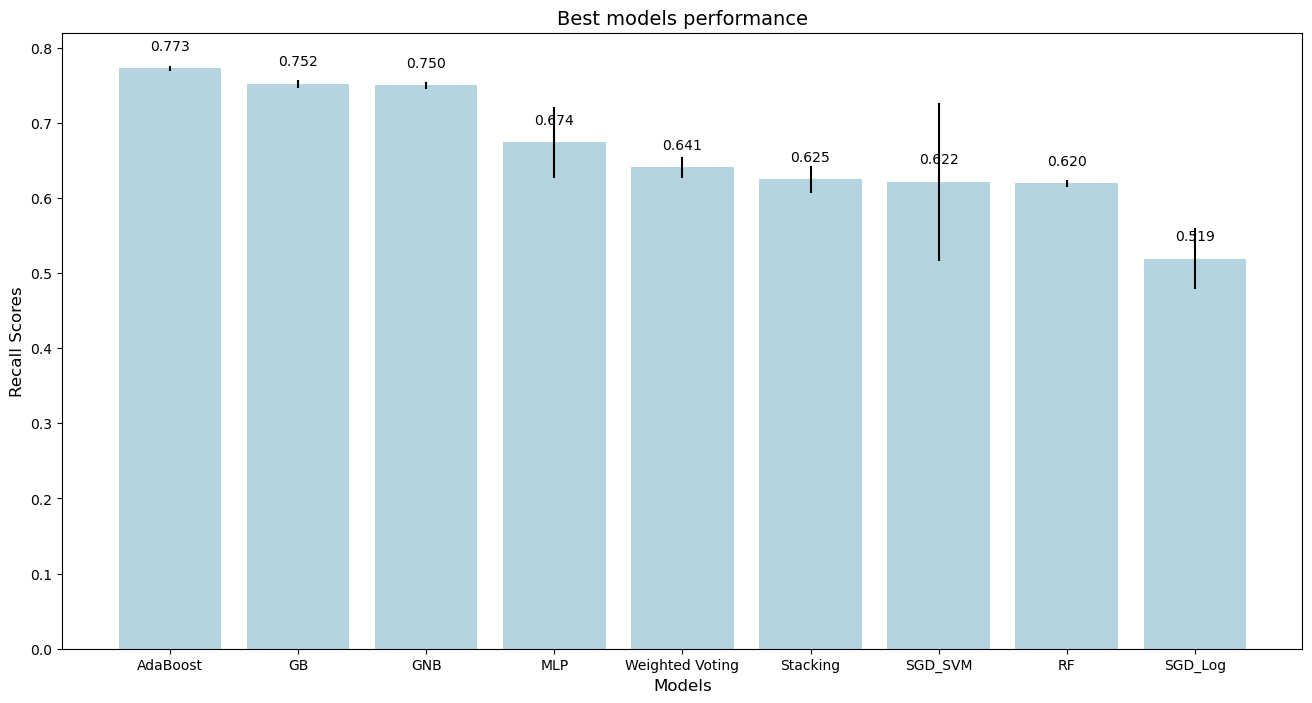

In [491]:
# plt.figure(figsize=(16, 8))
# bar = sns.barplot(x=data_for_plot['model'], y=data_for_plot['recall_score'], 
#                  capsize=0.2, errwidth=1, 
#                  color="lightblue"
#                 )

# for i in range(len(data_for_plot)):
#     bar.errorbar(i, data_for_plot.iloc[i]['recall_score'], yerr=data_for_plot.iloc[i]['std'],  color='black', )
#     f1 = data_for_plot.iloc[i]['recall_score']

#     bar.text(i, f1 + 0.02, f'{f1:.3f}', ha='center', va='bottom', color='black', fontsize = 10)


# # Set labels and title
# plt.xlabel('Models')
# plt.ylabel('Recall Scores')
# plt.title('Best models performance')
# plt.ylim(0, 0.82)


# # Show the plot
# plt.show()

### Submissions

In [ ]:
# ### Submit_v6

# columns_to_use = ['encounter_id', 'patient_id', 
                  
#                   'gender', 'age', 
#                   'has_weight',
                  
                  
#                   'outpatient_visits_in_previous_year',
#                   'emergency_visits_in_previous_year',
#                   'inpatient_visits_in_previous_year', 
#                   'total_visits', 
#                   'max_visits_of_one_type',
                  
#                   'average_pulse_bpm', 
#                   'length_of_stay_in_hospital', 
                  
#                   'number_lab_tests', 'more_than_one_lab_test',
#                   'non_lab_procedures', 
#                   'number_of_medications', 
#                   'number_diagnoses',
                  
#                   'glucose_test_result', 'glucose_test_performed', 
#                   'a1c_test_result','a1c_test_performed',
                  
#                   'change_in_meds_during_hospitalization', 
#                   'prescribed_diabetes_meds', 
                  
#                   'race_Asian', 'race_Caucasian', 'race_Hispanic',
#                   'race_Other', 'race_nan', 
                  
#                   'payer_code_HM', 'payer_code_MC',
#                   'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
#                   'payer_code_SP', 
                  
#                   'high_admission_source', 
#                   # 'medium_admission_source', 
#                   'low_admission_source',
                  
#                   'admission_type_big_share_Elective', 'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
                  
#                   'no_medical_specialty', 
                  
#                   'high_medical_specialty',
#                   # 'medium_medical_specialty',
#                   'low_medical_specialty',
                  
#                   'discharged_home_hospice', 'expired', 'very_high_discharge_disposition', 'high_discharge_disposition',
#                   # 'medium_discharge_disposition', 


#        'high_primary_diagnosis_category', 
#                   # 'medium_primary_diagnosis_category',
#        'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',
#        # 'medium_secondary_diagnosis_category',
#        'low_secondary_diagnosis_category',
#        'high_additional_diagnosis_category',
#        # 'medium_additional_diagnosis_category',
                  
#        'low_additional_diagnosis_category',
                   
#                   'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
#                   'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
#                   'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
#                   'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
#                   'rosiglitazone', 'glipizide', 
                  
#                   'insulin'
#                  ]
                 
# features_for_encoding = [
#     'admission_type',
#        'medical_specialty', 'discharge_disposition',
#        'admission_source', 
#     'primary_diagnosis',
#        'secondary_diagnosis', 'additional_diagnosis',
#         'primary_diagnosis_category', 'secondary_diagnosis_category', 'additional_diagnosis_category'
#                         ]

# features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
#        'emergency_visits_in_previous_year',
#        'inpatient_visits_in_previous_year', 'total_visits',
#        'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
#        'non_lab_procedures', 'number_diagnoses', 
#                                'glucose_test_result',
#        'a1c_test_result'
#                               ]
# features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

# columns_to_use_full = columns_to_use #+ features_for_encoding

# X_train = df_train[columns_to_use_full]
# y_train = df_train[target]
# X_test = df_test[columns_to_use_full]

# data = pd.concat([X_train, y_train], axis = 1)

# target = 'readmitted_binary'

# params = {'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': 'balanced_subsample',
#  'criterion': 'gini',
#  'max_depth': 24,
#  'max_features': 0.4,
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 0.000501,
#  'min_samples_split': 1e-06,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 260,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 42,
#  'verbose': 0,
#  'warm_start': False}

# model = RandomForestClassifier(**params)

# y_pred_test, y_pred_train, X_train = submit(X_train, 
#            y_train, 
#            X_test, 
#            model,
#            scaling = True,
#            features_for_scaling_minmax = features_for_scaling_minmax,
#            features_for_scaling_standard = features_for_scaling_standard,
#                                            )



# print(f1_score(y_pred_train, y_train))

# df_test['readmitted_binary'] = y_pred_test
# df_test['readmitted_binary'].replace({1:'Yes', 0:'No'}, inplace = True)
# # df_test[['encounter_id', 'readmitted_binary']].to_csv('submit_v6.csv', index = False)

In [ ]:
# ### Submit_v5

# df_train = pd.read_csv('Data/df_train_preprocessed.csv')
# df_test = pd.read_csv('Data/df_test_preprocessed.csv')
# columns_to_use = ['encounter_id', 'patient_id', 
                  
#                   'gender', 'age', 'has_weight',
                  
#                   'outpatient_visits_in_previous_year',
#                   'emergency_visits_in_previous_year',
#                   'inpatient_visits_in_previous_year', 
#                   'total_visits', 'max_visits_of_one_type',
                  
#                   'average_pulse_bpm', 
#                   'length_of_stay_in_hospital', 
                  
#                   'number_lab_tests', 'more_than_one_lab_test',
#                   'non_lab_procedures', 
#                   'number_of_medications', 
#                   'number_diagnoses',
                  
#                   'glucose_test_result', 'glucose_test_performed', 
#                   'a1c_test_result','a1c_test_performed',
                  
#                   'change_in_meds_during_hospitalization', 
#                   'prescribed_diabetes_meds', 
                  
#                   'race_Asian', 'race_Caucasian', 'race_Hispanic',
#                   'race_Other', 'race_nan', 
                  
#                   'payer_code_HM', 'payer_code_MC',
#                   'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
#                   'payer_code_SP', 
                  
#                   'high_admission_source', 'medium_admission_source', 'low_admission_source',
                  
#                   'admission_type_big_share_Elective', 'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
                  
#                   'no_medical_specialty', 'high_medical_specialty',
#                   'medium_medical_specialty', 'low_medical_specialty',
                  
#                   'discharged_home_hospice', 'expired', 'high_discharge_disposition',
#                   'medium_discharge_disposition', 
                   
#                   'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
#                   'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
#                   'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
#                   'medication_binary',
#                   'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
#                   'rosiglitazone', 'glipizide', 'insulin']
                 
# target =  'readmitted_binary'

# X_train = df_train[columns_to_use]
# y_train = df_train[target]
# X_test = df_test[columns_to_use]


# features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
#        'emergency_visits_in_previous_year',
#        'inpatient_visits_in_previous_year', 'total_visits',
#        'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
#        'non_lab_procedures', 'number_diagnoses', 'glucose_test_result',
#        'a1c_test_result']

# features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

# target = 'readmitted_binary'


# model = RandomForestClassifier(bootstrap=False, class_weight='balanced',
#                        criterion='entropy', max_depth=16, min_samples_leaf=10,
#                        min_samples_split=5, n_estimators=156)

# y_pred_test, y_pred_train, X_train = submit(X_train, 
#            y_train, 
#            X_test, 
#            model,
#            scaling = True,
#            features_for_scaling_minmax = features_for_scaling_minmax,
#            features_for_scaling_standard = features_for_scaling_standard)


# f1_score(y_pred_train, y_train)

### Final solution

In [270]:
features = ['gender',
 'non_lab_procedures',
 'number_diagnoses',
 'discharged_home_hospice',
 'low_secondary_diagnosis',
 'low_primary_diagnosis_category',
 'inpatient_visits_in_previous_year',
 'number_lab_tests',
 'low_primary_diagnosis',
 'metformin',
 'insulin',
 'diabetes_severity_group_Mild',
 'admission_type_big_share_Urgent',
 'race_Caucasian',
 'age',
 'high_primary_diagnosis',
 'total_visits',
 'expired',
 'high_additional_diagnosis',
 'high_additional_diagnosis_category',
 'very_high_discharge_disposition',
 'high_secondary_diagnosis',
 'low_additional_diagnosis',
 'admission_type_big_share_Emergency',
 'no_medical_specialty',
 'length_of_stay_in_hospital',
 'change_in_meds_during_hospitalization',
 'number_of_medications',
 'max_visits_of_one_type',
 'emergency_visits_in_previous_year',
 'a1c_test_result',
 'payer_code_No provider',
 'average_pulse_bpm',
 'payer_code_MC',
 'high_primary_diagnosis_category',
 'prescribed_diabetes_meds',
 'outpatient_visits_in_previous_year',
 'encounter_id',
 'patient_id']

df_train = pd.read_csv('Data/df_train_preprocessed.csv')
df_test = pd.read_csv('Data/df_test_preprocessed.csv')
target = 'readmitted_binary'

features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result','a1c_test_result'
                              ]
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

X_train_data = df_train[features]
y_train_data = df_train[target]
X_test_data = df_test[features]

features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(set(features)))
features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(set(features)))

data = pd.concat([X_train_data, y_train_data], axis = 1)



In [264]:
gnb = GaussianNB()
rf = RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.3,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0009000000000000002,
                       n_estimators=180, random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=9,
                           max_features=0.2,
                           min_samples_leaf=0.0006010000000000001,
                           min_samples_split=0.0009010000000000001,
                           n_estimators=170, random_state=42, subsample=0.7)

In [265]:
models_all = [[rf, False],
              [gb, True], 
              [gnb, False]
              ]

weights = [0.25, 0.5, 0.25]

#### Prediction on test with best model

In [271]:
scaling = True
cv = 5
multiclass = False
upsample_type = 'simple'
features_for_scaling_minmax_full = features_for_scaling_minmax
upsample_size = 1

df_stacked_train = pd.DataFrame()
df_stacked_test = pd.DataFrame()
for j in tqdm(models_all):
    upsample = j[1]
    train_data, test_data = data, X_test_data
    
    #creating features on patient level that we will use
    train_data, test_data, pat_features_scale = patient_features(train_data, test_data, multiclass = multiclass)
    features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale

    # Scaling features
    if scaling == True:
        if len(features_for_scaling_minmax) > 0:
            test_data = scaler(train_data, test_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
        if len(features_for_scaling_standard) > 0:
            test_data = scaler(train_data, test_data, features_for_scaling_standard, scaling_type = 'standard')
            train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')

    y_train_general = train_data.set_index('encounter_id')[target]
    # Upsampling only train data 
    if upsample == True:
        train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)

    # Defining train and val datasets
    X_train = train_data.set_index('encounter_id').drop(target, axis=1).drop(columns = ['patient_id'])
    y_train = train_data.set_index('encounter_id')[target]
    
    X_test = test_data.set_index('encounter_id').drop(columns = ['patient_id'])

    # Fit and predict
    model = j[0]
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_test)

    X_train[target] = y_pred_train
    X_train = X_train.drop_duplicates().sort_index()
    X_test[target] = y_pred_val
    X_test = X_test.drop_duplicates().sort_index()
    
    df_stacked_train[str(model).split('(')[0]] = X_train[target]
    df_stacked_test[str(model).split('(')[0]] = X_test[target]
    
df_stacked_train[target] = y_train_general.sort_index()


100%|█████████████████████████████████████████████| 3/3 [00:28<00:00,  9.42s/it]


In [296]:
y_pred_train = np.round(np.sum(df_stacked_train.drop(columns = [target]) * weights, axis = 1))
y_pred_test = np.round(np.sum(df_stacked_test * weights, axis = 1))
y_train = df_stacked_train[target]
print('F1_train: {:.4f}'.format(f1_score(y_train, y_pred_train)))

submission = pd.merge(df_test, y_pred_test.reset_index(), 
         on = 'encounter_id', 
         how = 'inner')[['encounter_id', 0]].rename(columns={0: 'readmitted_binary'})
submission['readmitted_binary'].replace({1:'Yes', 0:'No'}, inplace = True)
submission.to_csv('submit_v7.csv', index = False)

F1_train: 0.4011
